In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import iminuit as minuit


import scipy
from matplotlib import gridspec

from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy import optimize
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chisquare
from iminuit import cost


# bare ions

### a/q = 254/1, f033

                 datafile det            t   evt_num   x   y  ychan  xchan   0
0       r231f033_4841.lmd  C2   344.980908  14829591  25  31    979    957 NaN
1       r231f033_4841.lmd  C2   345.023059  14829594  25  12    836   1002 NaN
2       r231f033_4841.lmd  C2   345.054165  14829595  11  22    633    972 NaN
3       r231f033_4841.lmd  C2   345.054680  14829596   6  16    991   1039 NaN
4       r231f033_4841.lmd  C2   345.093900  14829597   4  22    889    975 NaN
...                   ...  ..          ...       ...  ..  ..    ...    ...  ..
329269  r231f033_4841.lmd  C2  5619.465270  15343264  22  19    943    915 NaN
329270  r231f033_4841.lmd  C2  5619.471966  15343265   7   4    974   1017 NaN
329271  r231f033_4841.lmd  C2  5619.537932  15343269  14  18   1022   1076 NaN
329272  r231f033_4841.lmd  C2  5619.618630  15343274   3  23    883    968 NaN
329273  r231f033_4841.lmd  C2  5619.621179  15343275  13  20    963    993 NaN

[329274 rows x 9 columns]
File: run231_033_output.t

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_76554/151121618.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_76554/151121618.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.12 (chi2/ndof = 2.3)    │              Nfcn = 93               │
│ EDM = 0.000104 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

Text(0.5, 1.0, 'sim')

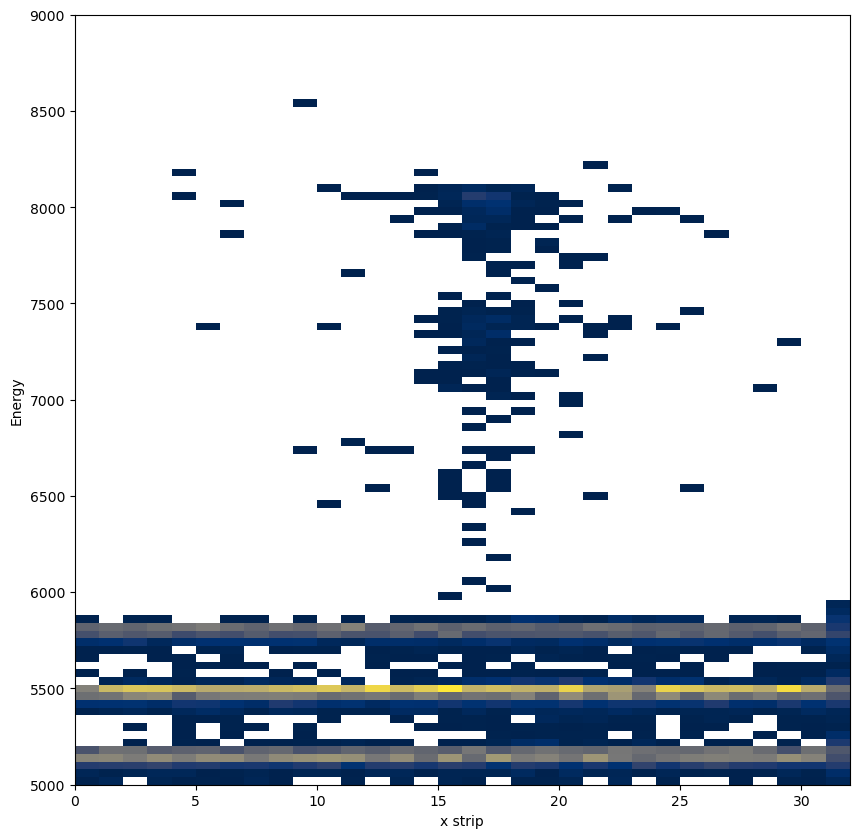

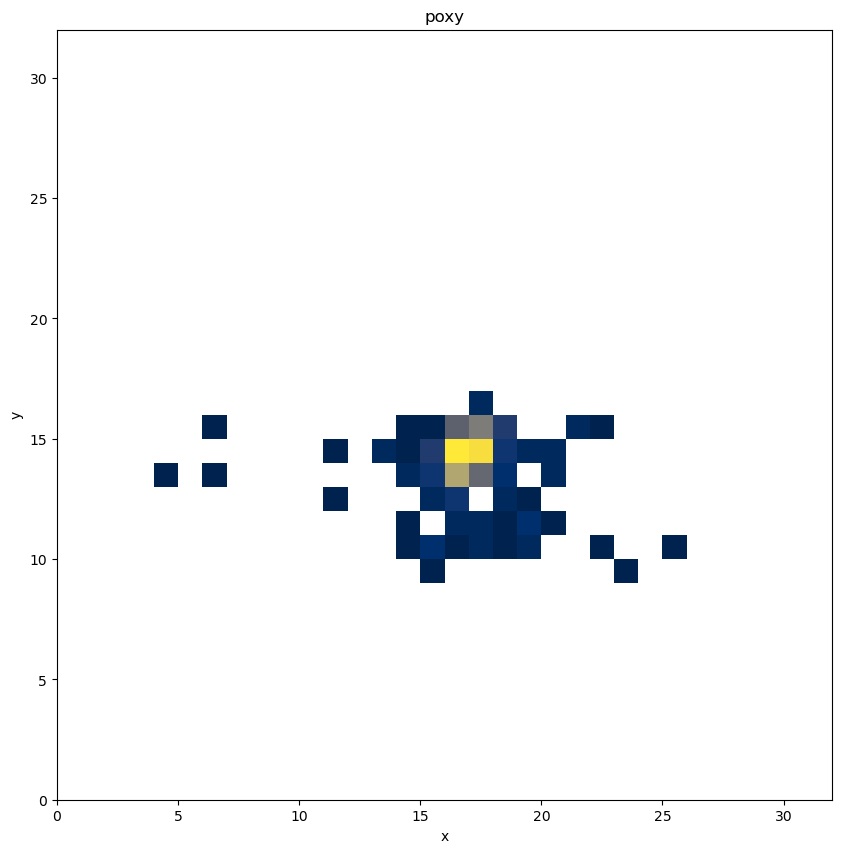

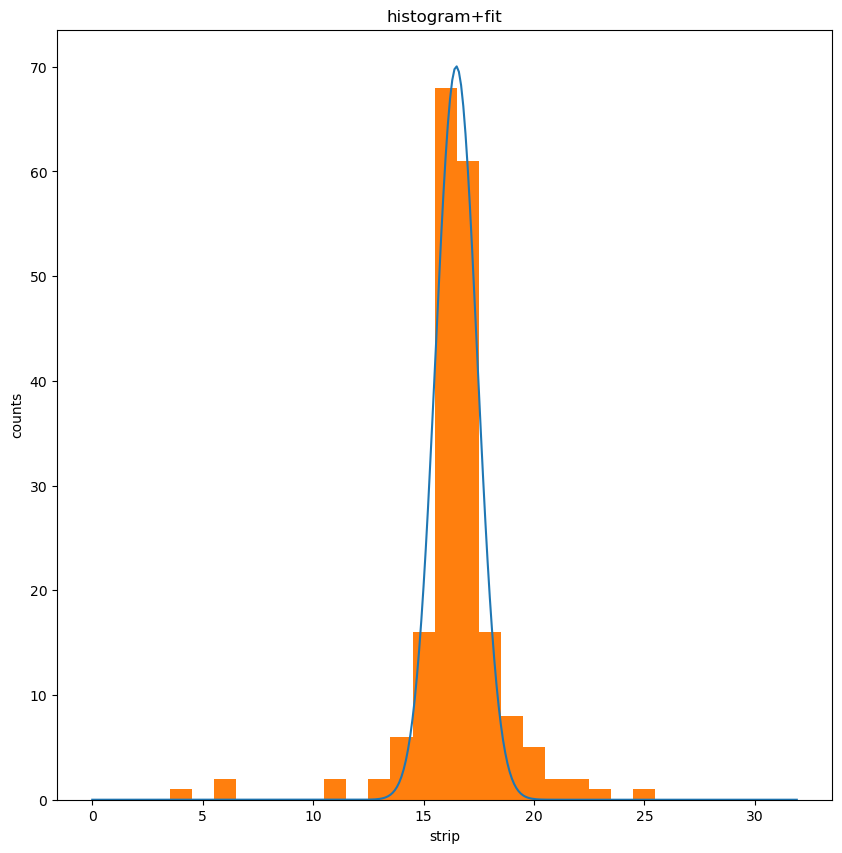

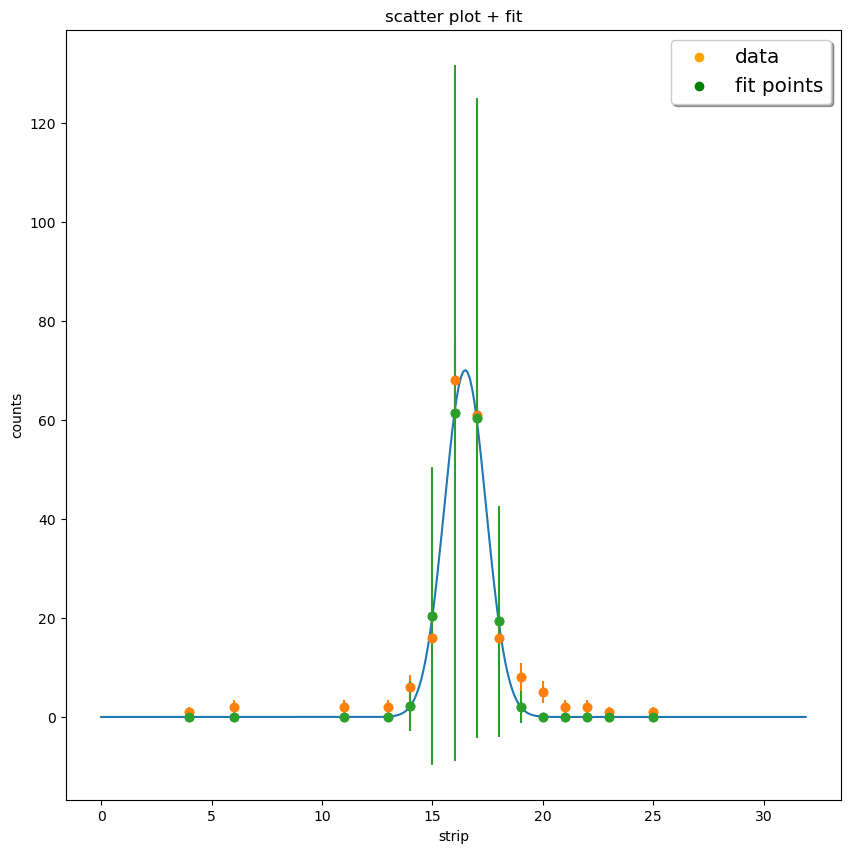

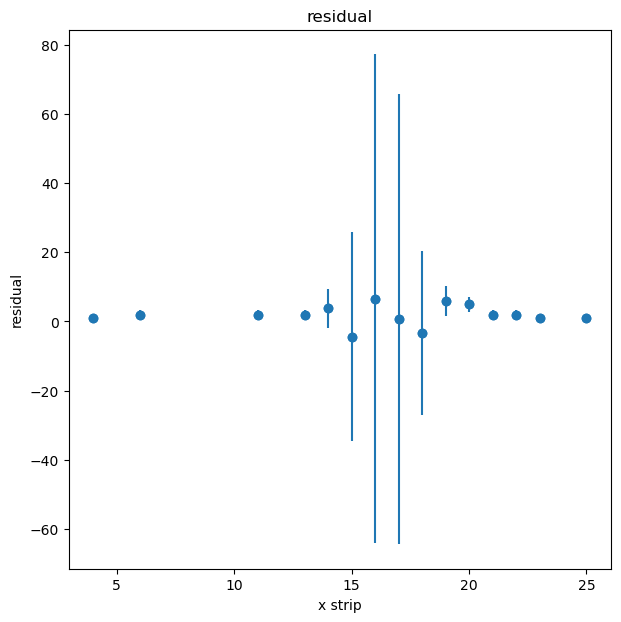

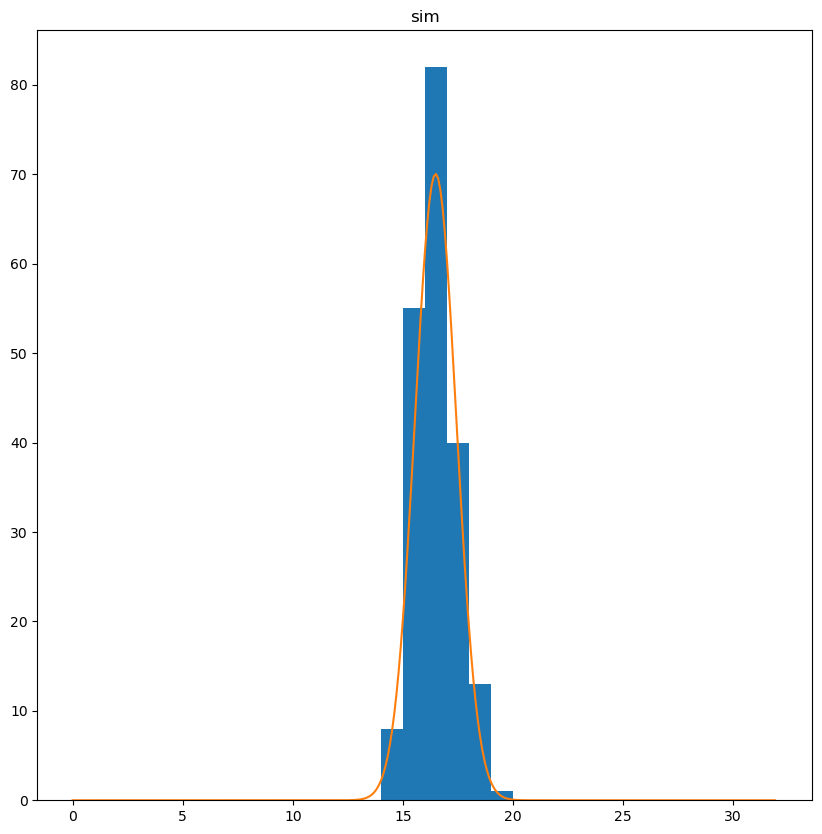

In [2]:
data = pd.read_csv('run231_033_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
print (data)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_033_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=9) & (df['y'] < 17) & (df['xE'] > 7600) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,16,1.4)

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))
plt.title("histogram+fit")


plt.plot(bins_,yy)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("counts")
plt.xlabel("strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
print(area1)
area_1=area1/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### a/q = 254/2 f022

File: run231_022_output.txt
3 2020-03-24 08:55:29
[' Baseline A/q=254/2 measurement', ' 50 ms trapping', ' no gas']
                    name det             t  evt_num   x   y  nX  nY  \
47427  r231f022_4828.lmd  DS  13012.582137  8186501  13  16   1   1   
47428  r231f022_4828.lmd  DS  13012.908803  8186527  16  13   1   1   
47429  r231f022_4828.lmd  DS  13012.915315  8186528  17  25   1   1   
47430  r231f022_4828.lmd  DS  13013.122563  8186552   3  11   1   1   
47431  r231f022_4828.lmd  DS  13014.033560  8186642   2  26   1   1   

                xE           yE  
47427  5468.447037  5486.368845  
47428  5487.713159  5445.782342  
47429  5809.061270  5477.240422  
47430  5116.136444  5145.538972  
47431  5483.525089  5487.195238  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.105 (chi2/ndof 

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1352922511.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1352922511.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

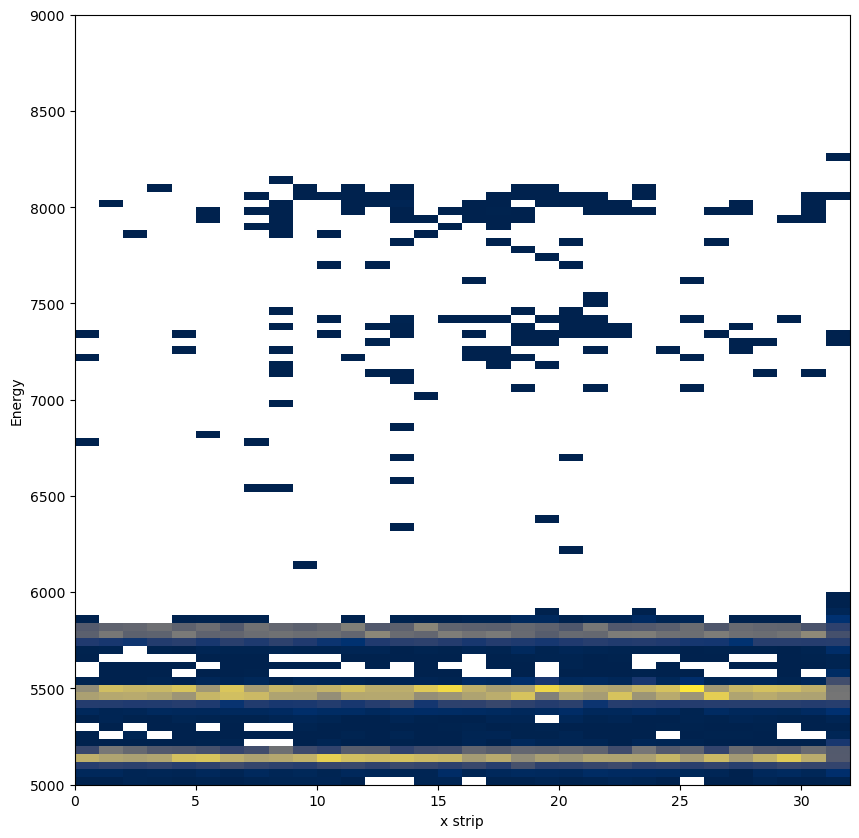

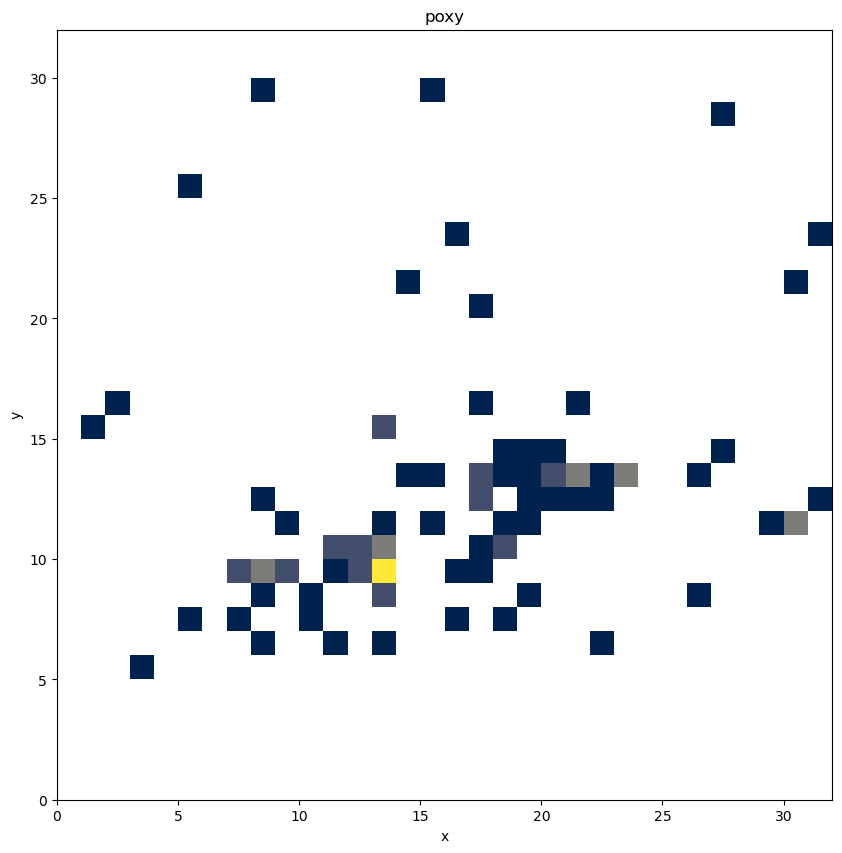

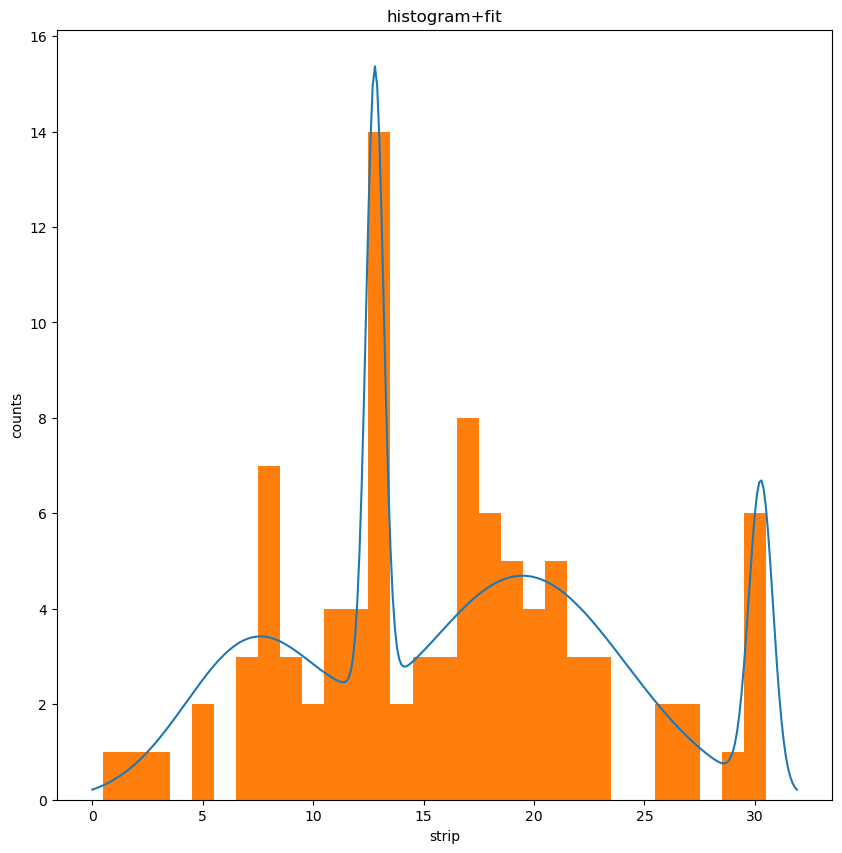

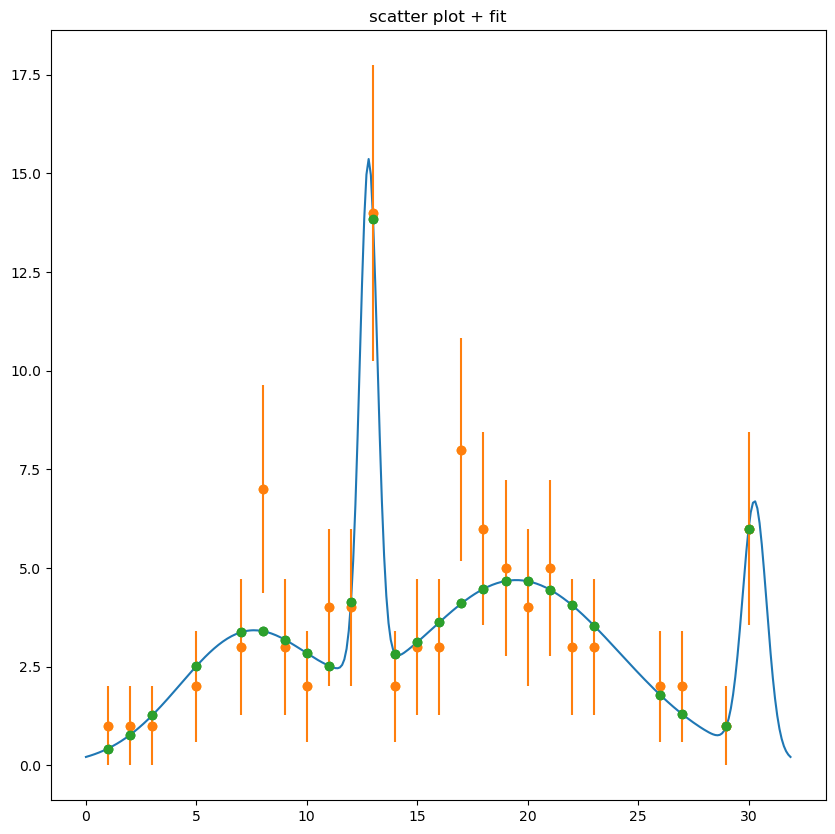

In [42]:
data = pd.read_csv('run231_022_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_022_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,6,9,1.4,13,14,.86,7,19,1,30,30,1.2)
m.limits = [(0,None),(0,None),(0,None),(0,None), (0,None), (0.4,None), (0,None ), (0,None), (0, None),(5,None),(25,None),(0, None)]

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (10,10))
plt.title("histogram+fit")


plt.plot(bins_,yy)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("counts")
plt.xlabel("strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 95
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### a/q = 254/2, f030

File: run231_030_output.txt
5 2020-03-24 16:49:27
[' back to bare No ions', ' mpod = 254/2+', ' BGS = 1741/405/608A', ' new ES offset = 15.622V', ' start at 7:08pm']
                    name det             t   evt_num   x   y  nX  nY  \
65216  r231f030_4837.lmd  DS  17753.742796  12088825   0   2   1   1   
65217  r231f030_4837.lmd  DS  17753.964339  12088848  16  19   1   1   
65218  r231f030_4837.lmd  DS  17753.992302  12088851   8   6   1   1   
65219  r231f030_4837.lmd  DS  17754.015779  12088854   1  13   1   1   
65220  r231f030_4837.lmd  DS  17754.119851  12088866  12   5   1   1   

                xE           yE  
65216  5499.537437  5445.347103  
65217  5488.706631  5496.176484  
65218  5133.705365  5145.819514  
65219  5166.101327  5176.716155  
65220  5841.474098  5845.094465  
374
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬─────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1996510391.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1996510391.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

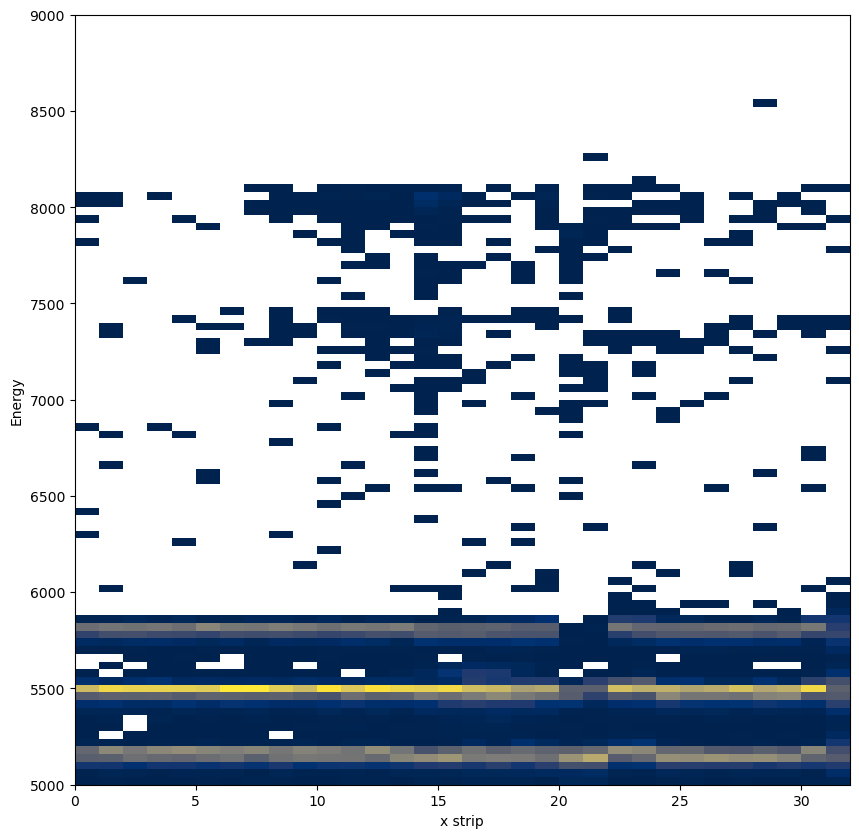

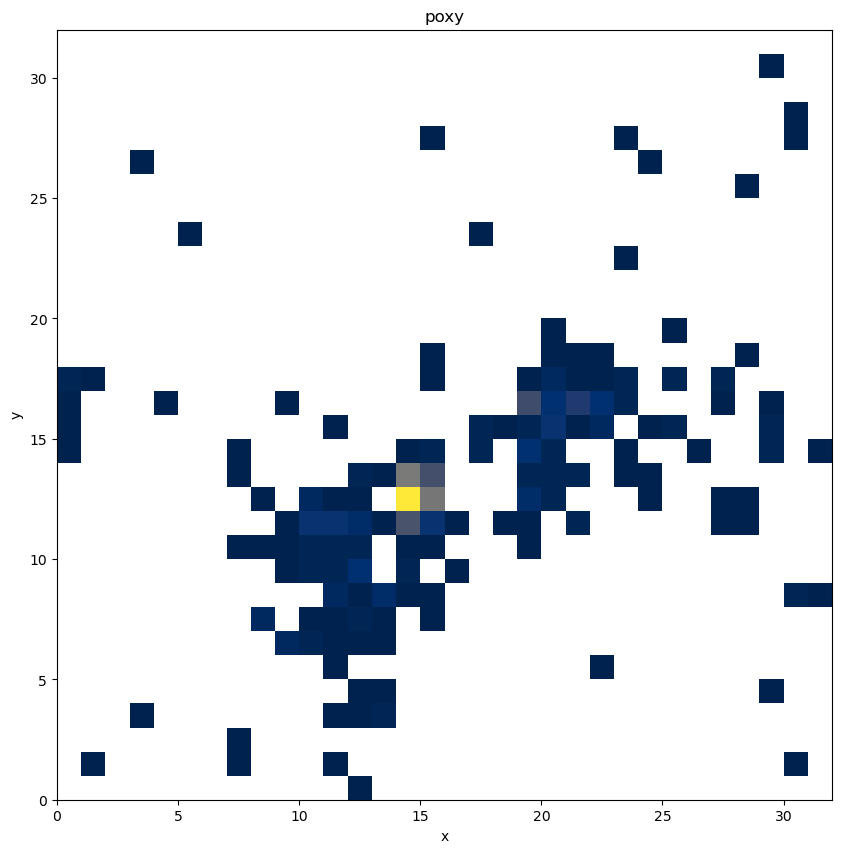

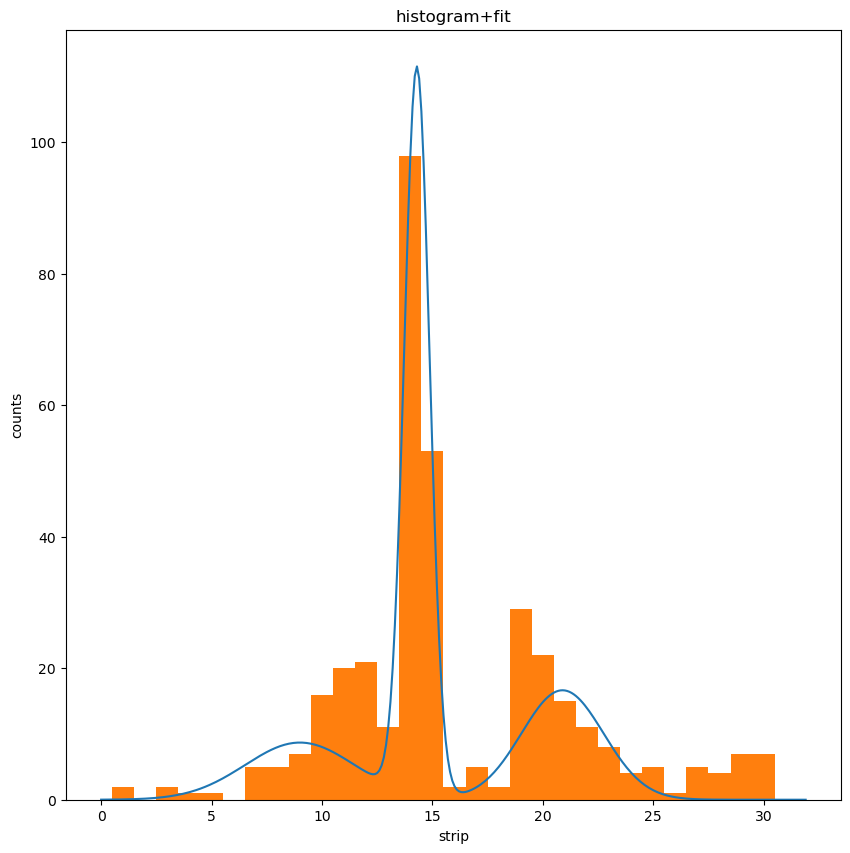

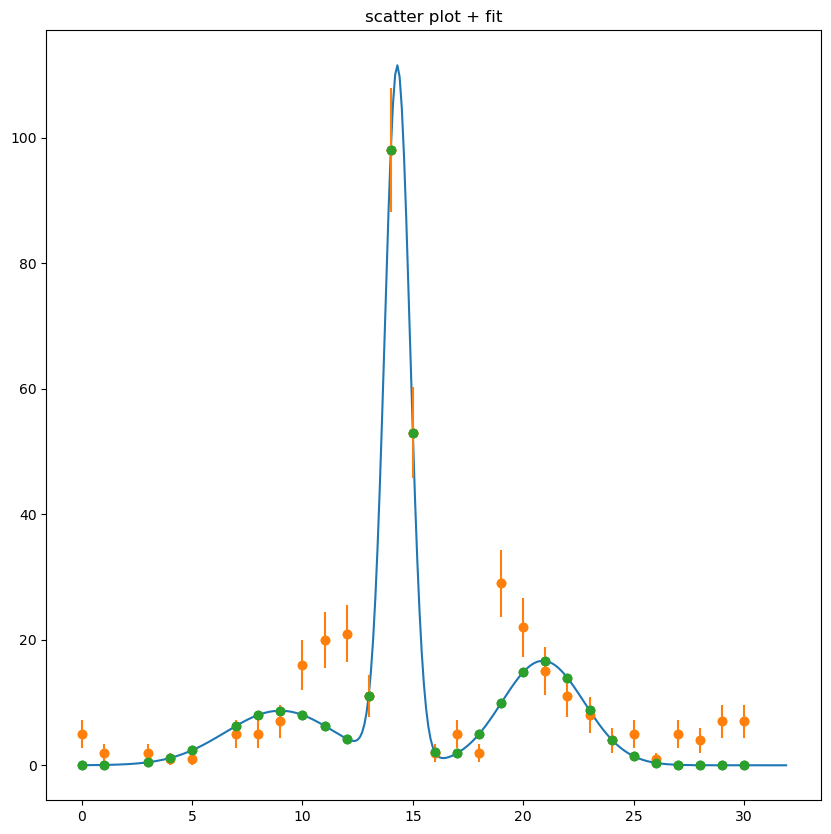

In [44]:
data = pd.read_csv('run231_030_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run030.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_030_output.txt', cal)
print (df.tail())

plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')




gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]


print (sum(newcounts))


def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,13,1.4,530,15,.86,310,20.4,1)

m.limits = [(0,None),(None,9),(0,None),(0,150), (None,None), (None,None), (0,50 ), (None,None), (None, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3)
#print(yy)
plt.figure(figsize = (10,10))
plt.title("histogram+fit")


plt.plot(bins_,yy)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("counts")
plt.xlabel("strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
total= area1+area2+area3
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total


plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3]
sigma = [exp_1,exp_2,exp_3]
area = [area_1,area_2,area_3]
n = 374
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### f052, a/q = 254/2

File: run231_052_output.txt
4 2020-03-26 23:44:10
[' mpod = 254/2+', ' count on DS', ' no gas', ' start at 2:02am']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 36.72 (chi2/ndof = 3.1)    │             Nfcn = 1674              │
│ EDM = 0.000123 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/3169562627.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/3169562627.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

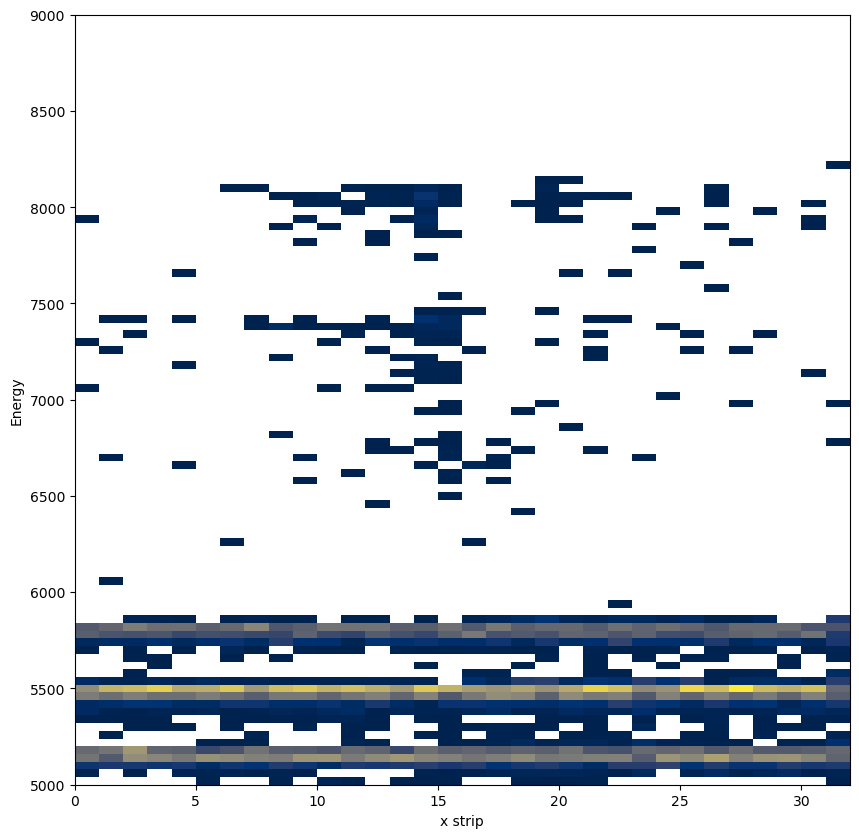

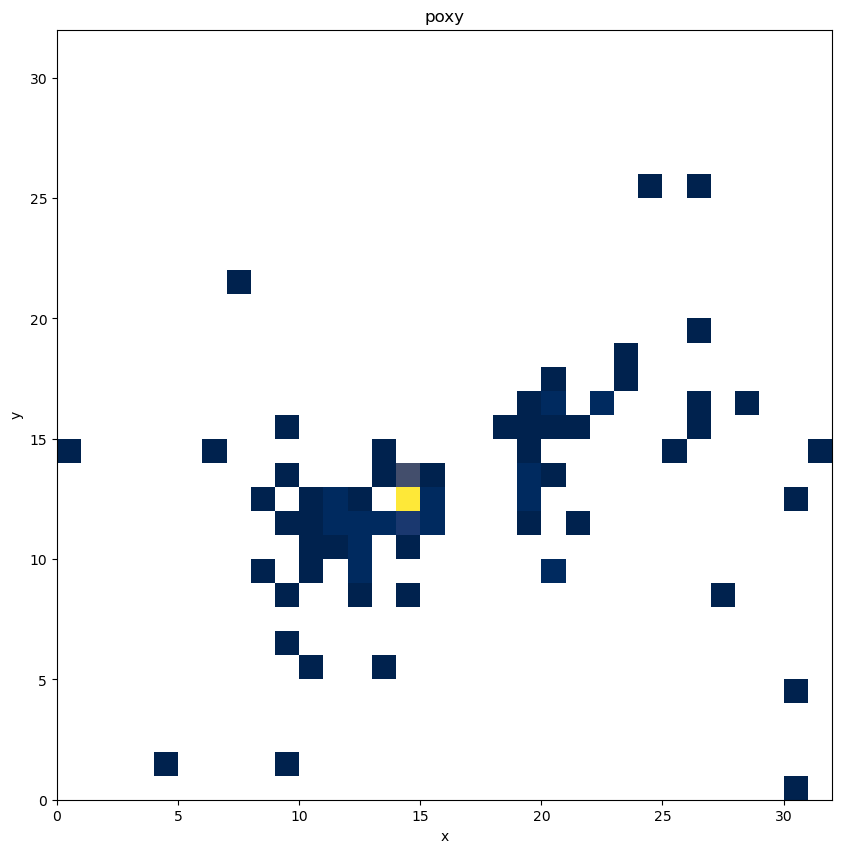

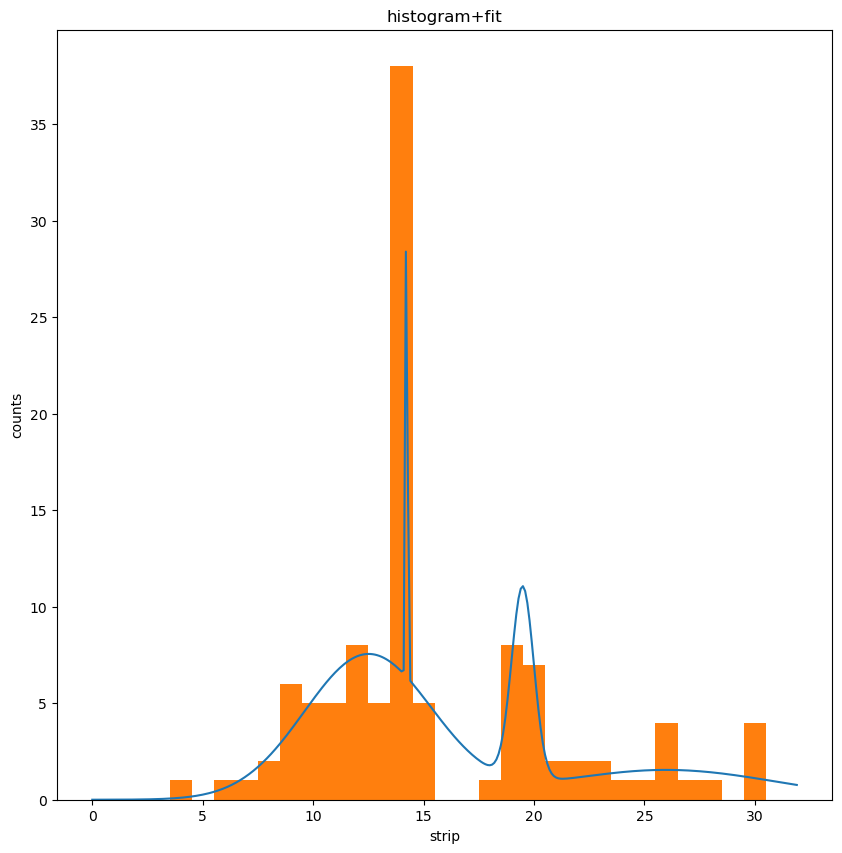

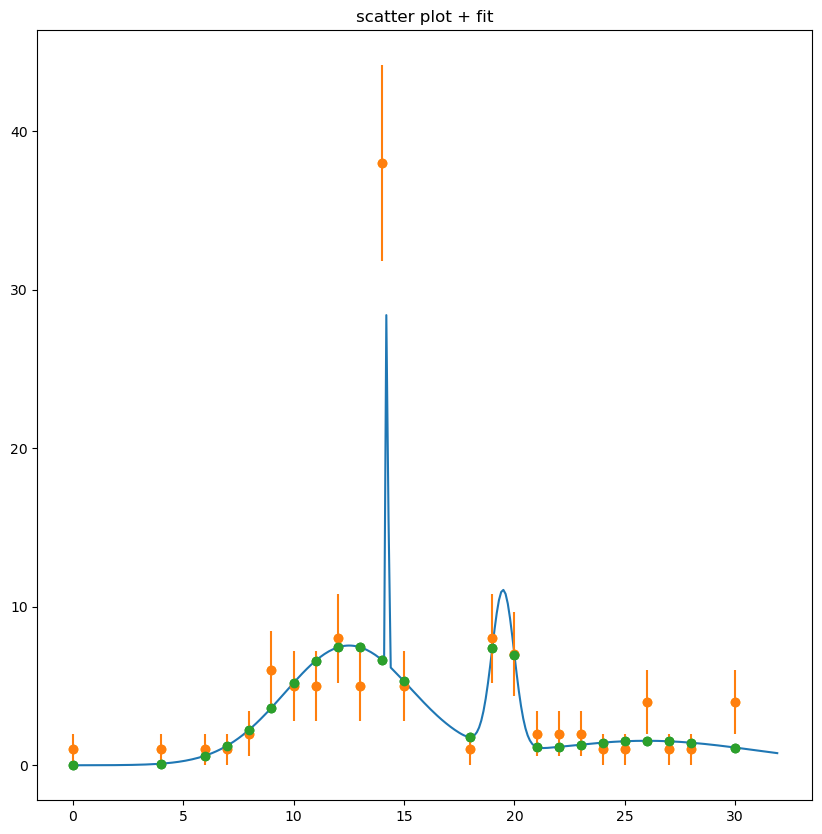

In [15]:
data = pd.read_csv('run231_052_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_052_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7600) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,13,1.4,530,15,.86,310,20,1,30,26,1.2)

m.limits = [(0,None),(9,13),(0,None),(31,41), (13,15), (0,None), (7,10 ), (17,20), (0, None),(0,None),(24,27),(0.3, 5)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (10,10))
plt.title("histogram+fit")


plt.plot(bins_,yy)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("counts")
plt.xlabel("strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 112
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")





# ----------------------------------------------------------------------------------

# water molecules 

## a/q = 308/2, No+ 3 waters, f032, ignore?


File: run231_032_output.txt
4 2020-03-24 22:04:14
[' Scale mpod to 308/2+', ' this should be No + 3 waters', ' see if it is slanted on the DS too', ' Just do a short 1 hour file']
                    name det            t   evt_num   x   y  nX  nY  \
15108  r231f032_4839.lmd  DS  3729.228703  12561711  29  11   1   1   
15109  r231f032_4839.lmd  DS  3729.841760  12561767  23  25   2   1   
15111  r231f032_4839.lmd  DS  3729.879913  12561776  26  21   1   1   
15112  r231f032_4839.lmd  DS  3729.893423  12561779  16  25   1   1   
15113  r231f032_4839.lmd  DS  3729.951479  12561782  10  25   1   1   

                xE           yE  
15108  5153.774434  5140.016617  
15109  5827.909888  5920.416548  
15111  5129.013700  5139.403215  
15112  5465.144335  5343.634365  
15113  5496.073698  5501.532432  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬─

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_80569/1937192932.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_80569/1937192932.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

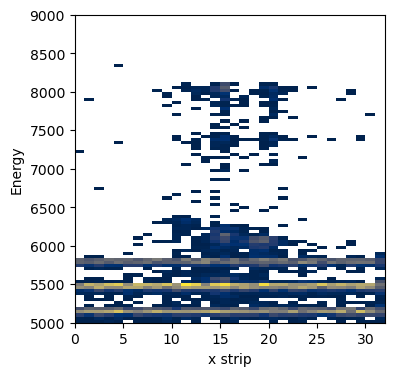

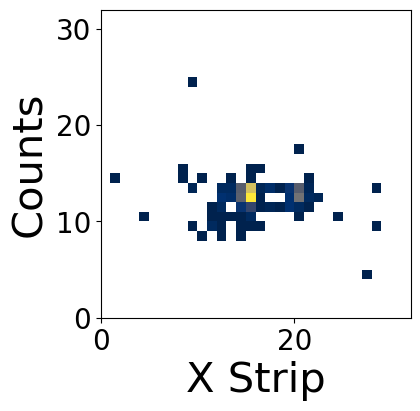

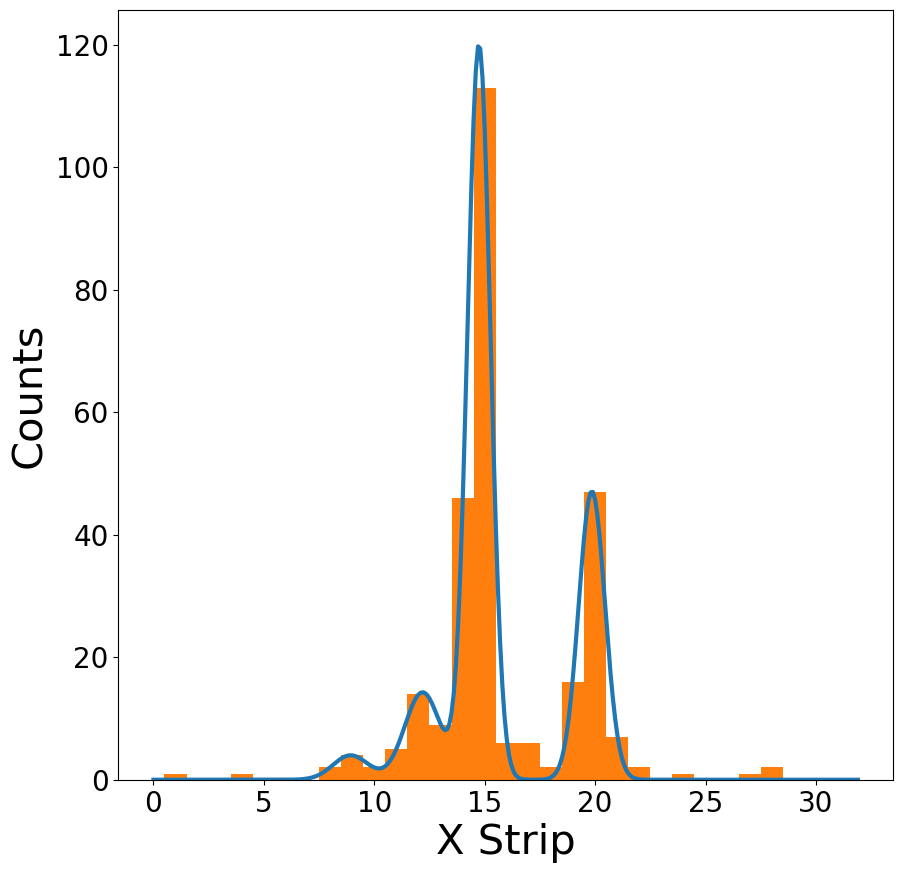

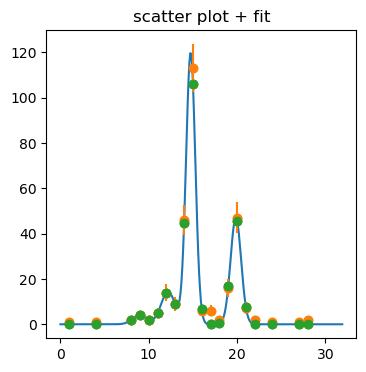

In [19]:
data = pd.read_csv('run231_032_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_032_output.txt', cal)
plt.figure(figsize = (4,4))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (4,4))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,10,1.4,530,12.5,.86,310,16.4,1,30,20,1.2)

m.limits = [(0,None),(None,10),(0.8,1),(0,20), (None,None), (0,1), (0,120 ), (10,15), (0, None),(0,None),(0,None),(0, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)


plt.plot(bins_,yy,linewidth =3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (4,4))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
print(area3)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 753
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### 14.74 = 308/2, No254 + 3 waters, centered
### (308/2-309/2)/ 308/2, for 0.5% at 3.935 strips astatine, is 2.55 strips/ mass
### 12.19 = 307/2, 15.8-2.55= = 12.19,  No + 2 waters + OH
### 19.65 = 310/2, 15.8+ 2.55 +2.55 = 20.9, No(N$_{2}$$)_{2}$
### 8.9 = 306,  1 water + 2 OH, or 2 waters + O

## a/q = 326/2, f047, looking at No+ 4 waters

File: run231_047_output.txt
1 2020-03-26 19:48:18
[' A/q=326/2, No-4(H2O) no gas']
                    name det            t   evt_num   x   y  nX  nY  \
12135  r231f047_4857.lmd  DS  3622.994563  31337861  26  17   1   1   
12136  r231f047_4857.lmd  DS  3623.036267  31337868   1  27   1   1   
12137  r231f047_4857.lmd  DS  3623.411796  31337906   1   3   1   1   
12138  r231f047_4857.lmd  DS  3624.755356  31338052  18  25   1   1   
12139  r231f047_4857.lmd  DS  3624.773619  31338054  26   4   1   1   

                xE           yE  
12135  5467.207386  5512.692745  
12136  5114.449059  5118.384901  
12137  5114.449059  5126.722688  
12138  5474.213273  5489.386427  
12139  5461.475290  5456.083799  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.076 (chi2/ndof = 0.8)    │              Nfcn = 2

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_99200/3609196112.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_99200/3609196112.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


15.92595733235939
60


Text(0.5, 1.0, 'sim')

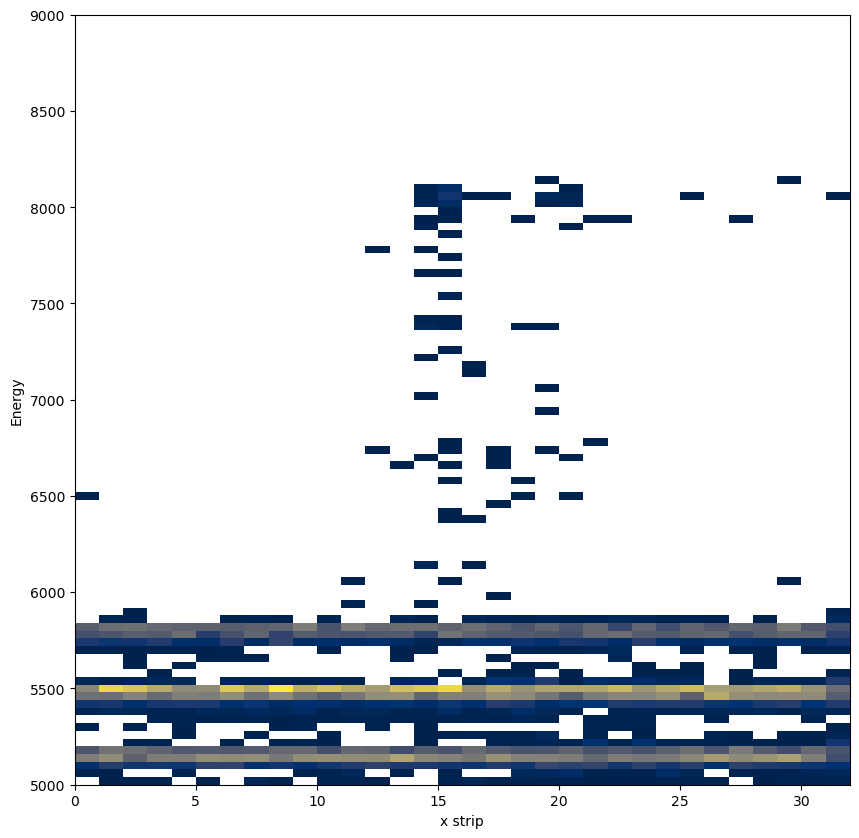

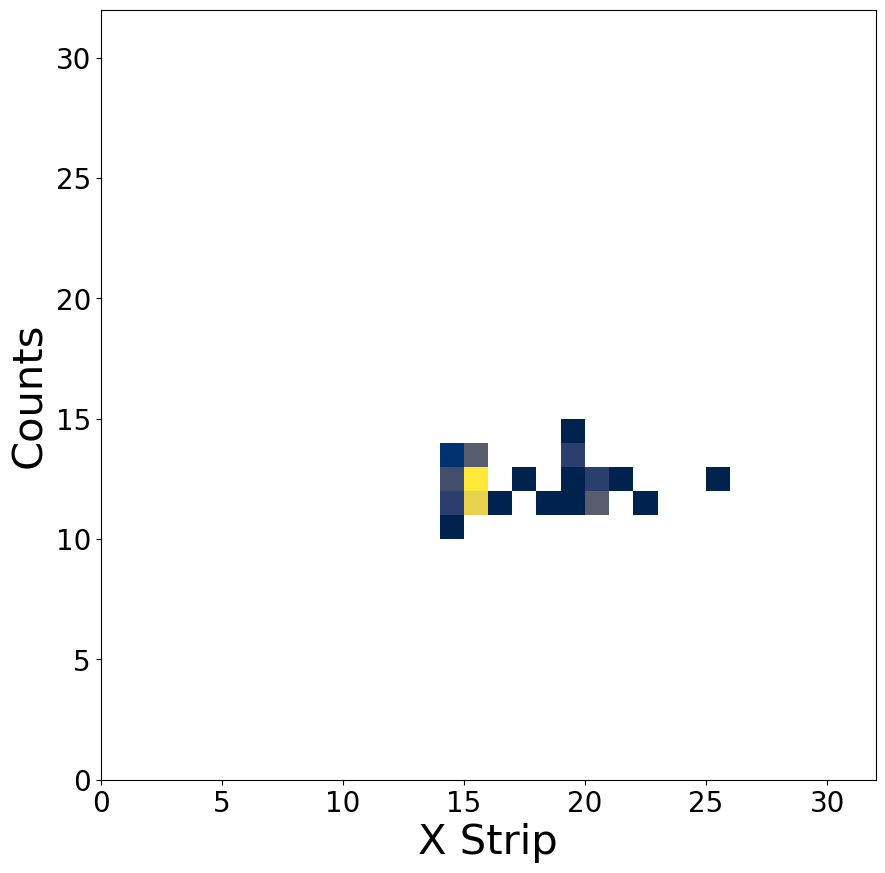

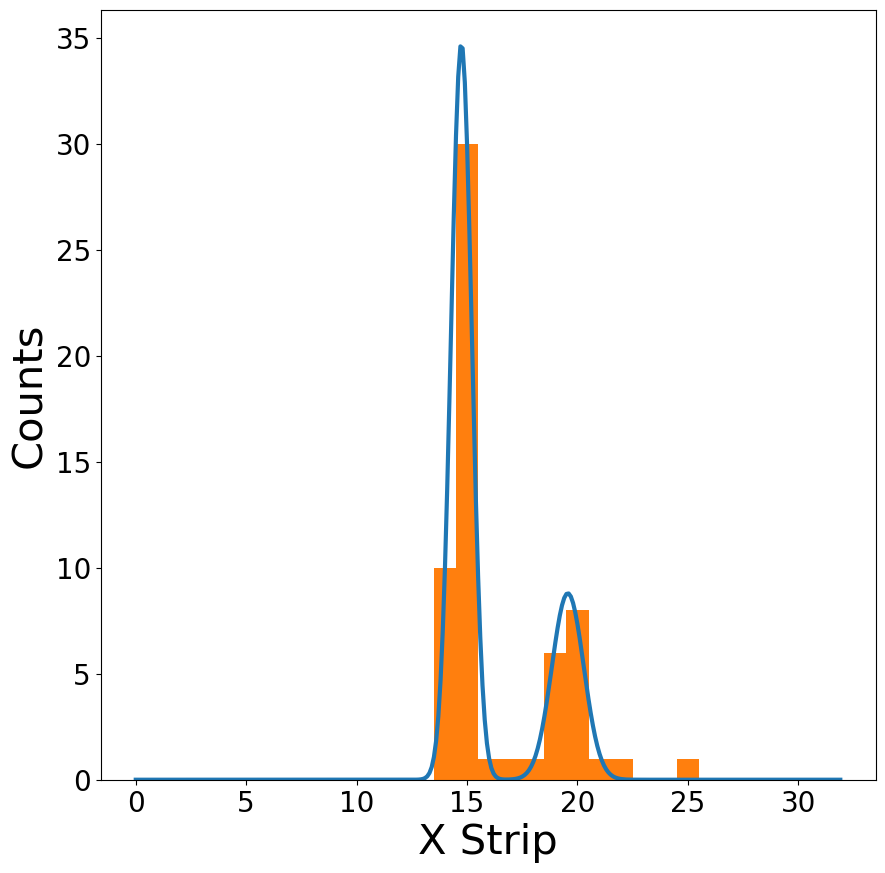

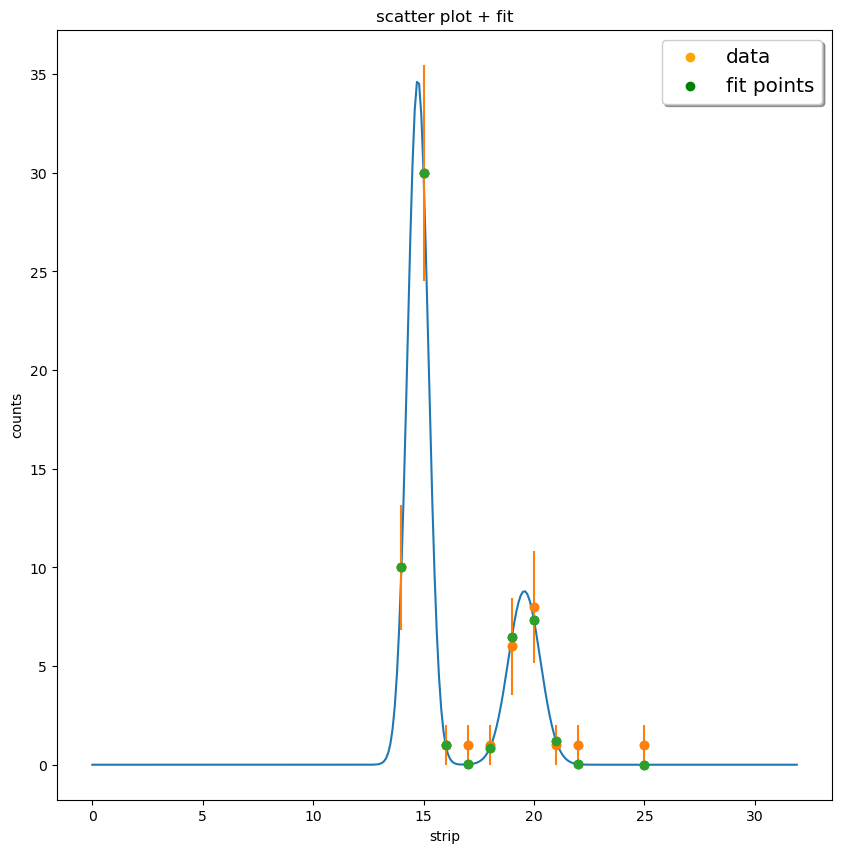

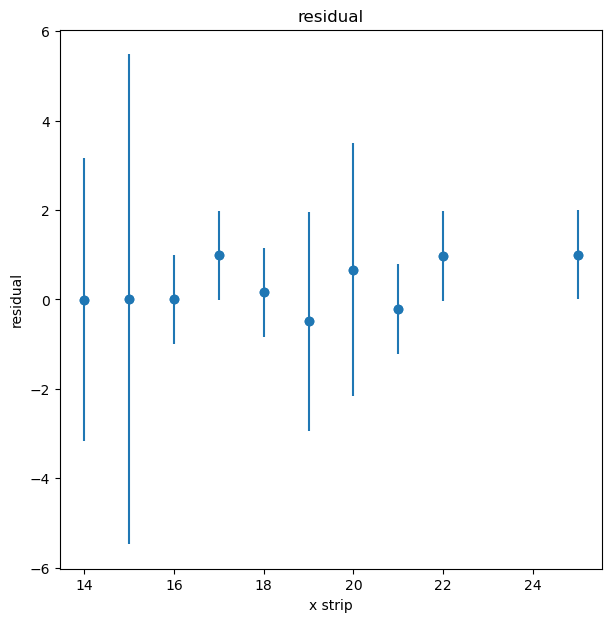

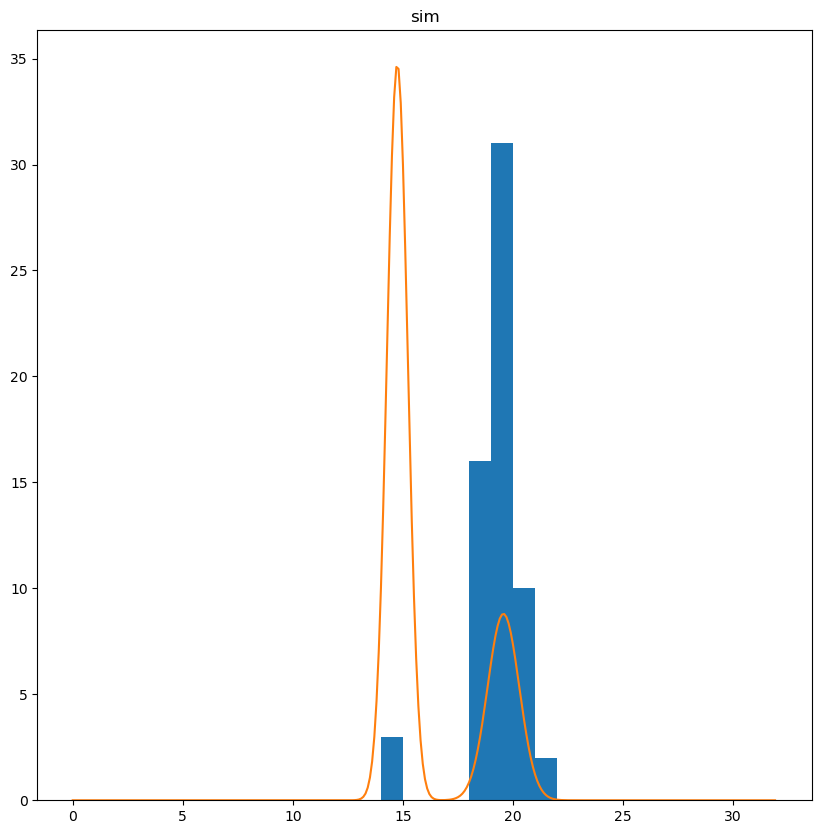

In [18]:
data = pd.read_csv('run231_047_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_047_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=6) & (df['y'] < 17) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,15,1.4,530,20,.86)

m.limits = [(None,None),(None,None),(None,None),(None,19), (0,None), (None,None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth=3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2+area3
#print (total)
print(area2)
area_1=area1/total
area_2=area2/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")






### 15.74 = 326/2, No254 + 4 waters, centered
### (326/2-327/2)/ 326/2, for 0.5% at 3.935 strips astatine f037, is 2.41 strips/ 1 mass
### 20.56 = 328/2, 15.74+2.41+2.41= 20.55, No($N_{2}$$)_{2}$ + $H_{2}$0

## a/q = 290/2, f048, no+ 2 H20

File: run231_048_output.txt
2 2020-03-26 20:44:59
[' A/q=290/2,looking for No-2(H2O)', ' no gas']
                    name det            t   evt_num   x   y  nX  nY  \
18450  r231f048_4858.lmd  DS  5049.370869  31831575   8  25   1   1   
18451  r231f048_4858.lmd  DS  5049.435633  31831583   4   4   1   1   
18452  r231f048_4858.lmd  DS  5049.551893  31831595   2  25   1   1   
18453  r231f048_4858.lmd  DS  5049.601555  31831603  11  13   1   1   
18454  r231f048_4858.lmd  DS  5049.812314  31831626  15   7   1   1   

                xE           yE  
18450  5150.932018  5161.444288  
18451  5487.464145  5508.841556  
18452  5103.527795  5106.787265  
18453  5467.881942  5504.436585  
18454  7795.577714  7822.763544  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.83 (chi2/ndof = 1.5)    │       

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_99200/84605505.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_99200/84605505.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

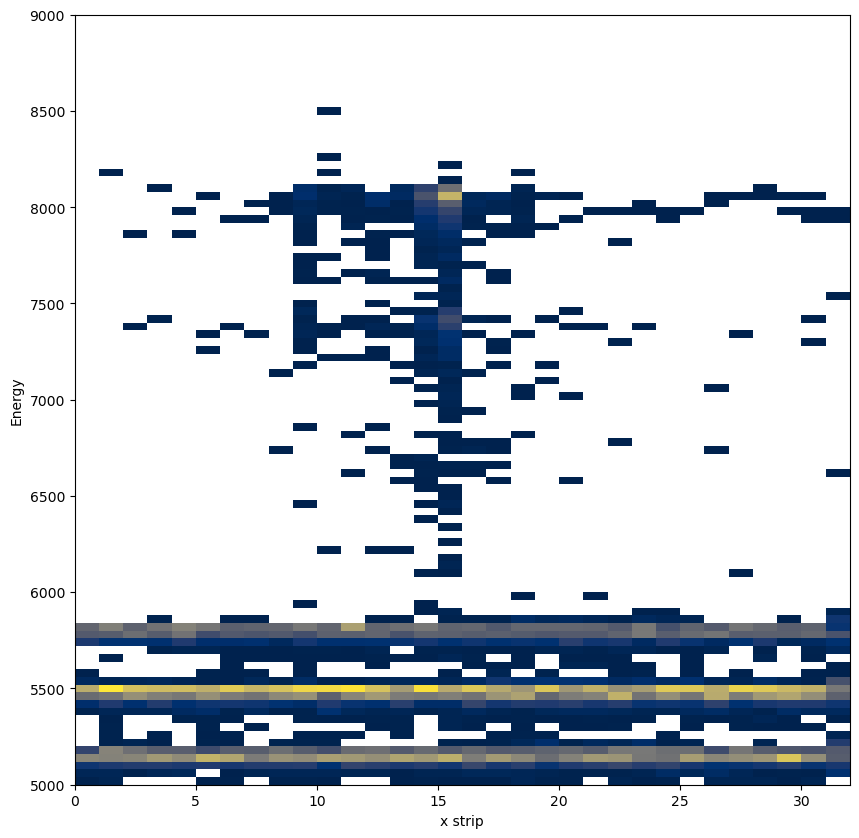

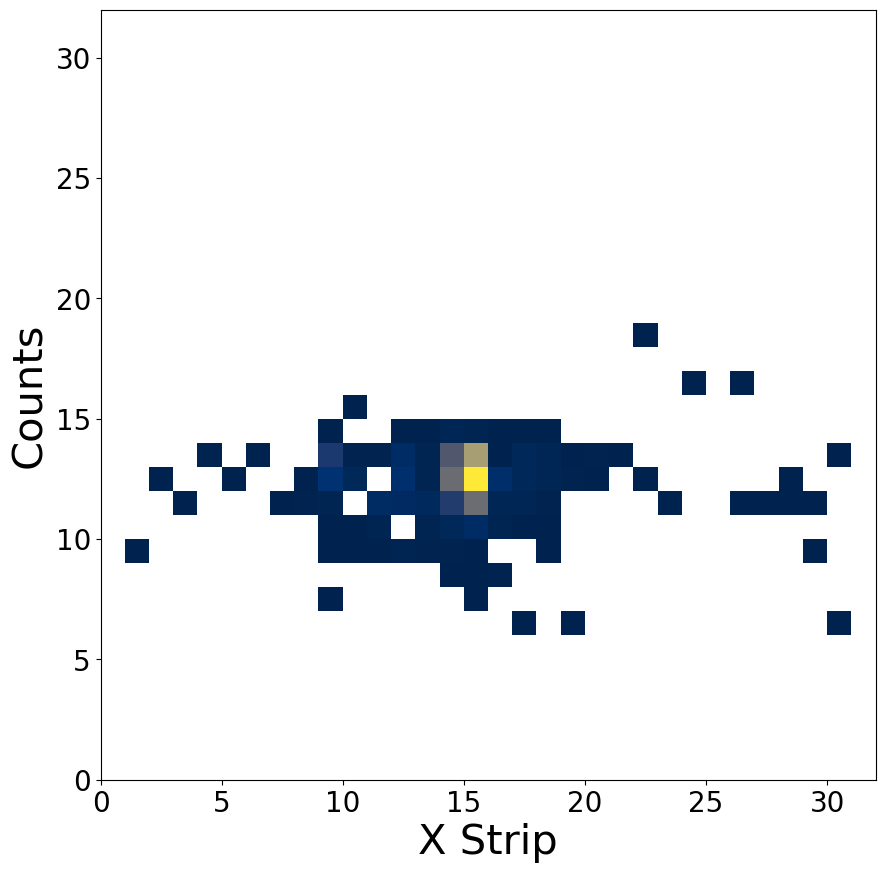

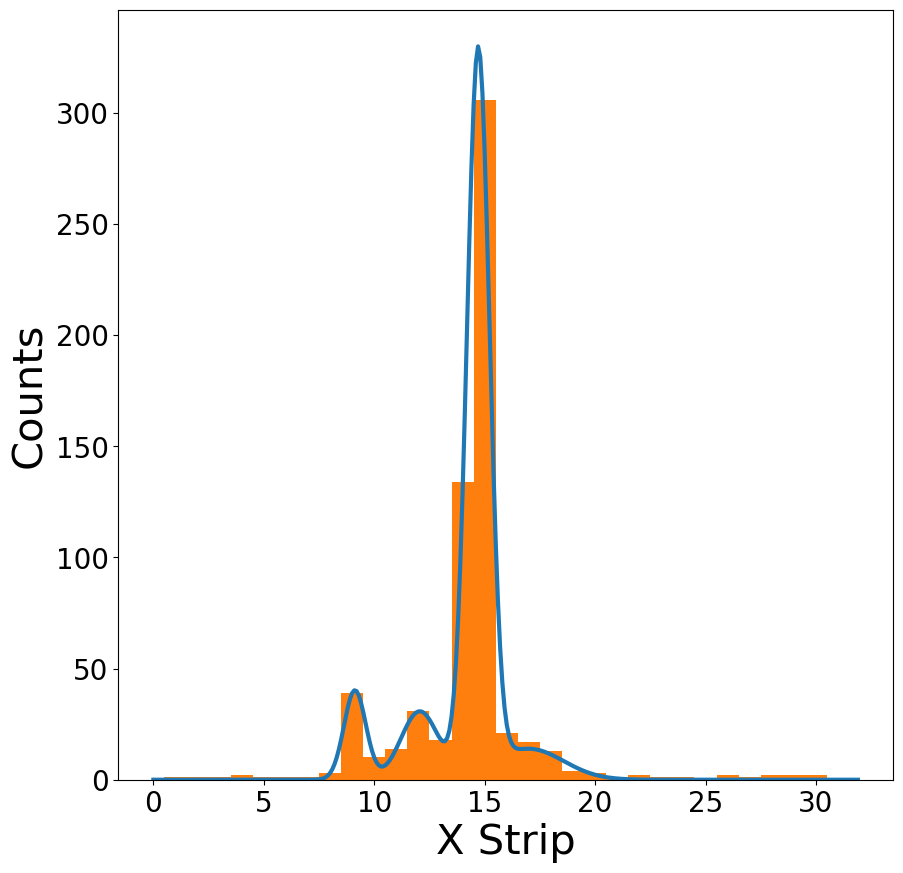

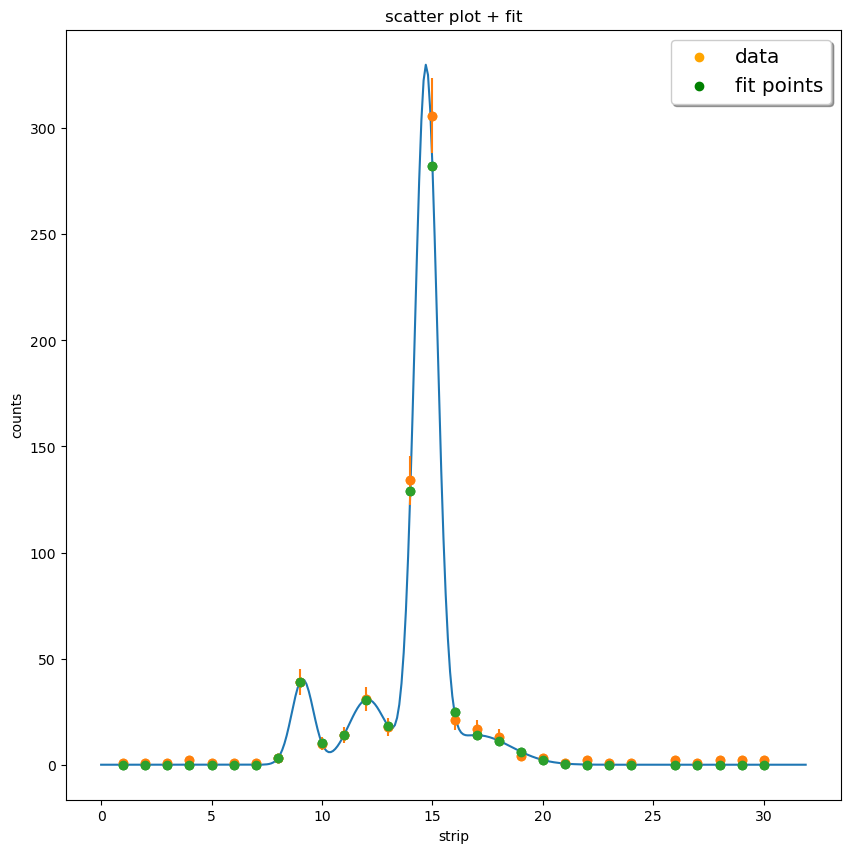

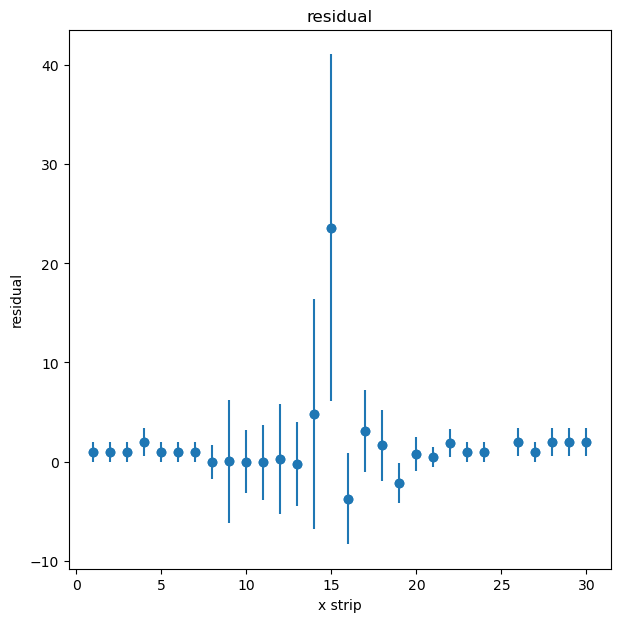

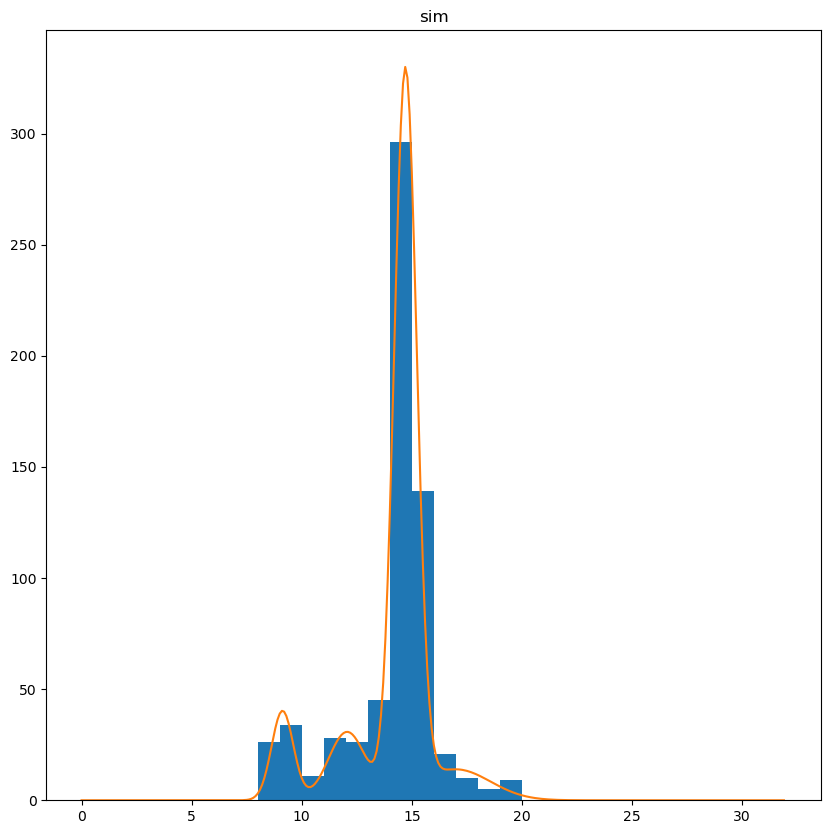

In [17]:
data = pd.read_csv('run231_048_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_048_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=6) & (df['y'] < 20) & (df['xE'] > 7600) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,10,1.4,530,13,.86,310,16.4,1,30,18,1.2)

m.limits = [(0,None),(7,10),(0,None),(0,50), (10,13), (0,1.5), (250,325 ), (13,16), (None, None),(0,None),(17,18),(0, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)


plt.plot(bins_,yy,linewidth = 3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
print(area3)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 650
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### 15.701 = 290/2, No254 + 2 waters, centered
### (290/2-291/2)/ 290/2, for 0.5% at 3.95 strips astatine f044, is 2.72 strips/ 1 mass
### 13.0 = 289/2, 15.701-2.72 = 12.981, No$H_{2}$O-OH
### 10.06= 288/2, 15.701-2.71-2.71 = 10.261, No (OH$)_{2}$ or No$H_{2}$0O
### 17.5 = 291/2, 15.701+2.71 = 18.421, No- ($H_{2}$O$)_{2}$-H
### $x^{2}$

## f050,a/q - 272/2, No + 1 water

File: run231_050_output.txt
3 2020-03-26 22:24:09
[' mpod still at 272/2+', ' pull out C2 and count No + H2O on DS for a couple hours or so', ' start at 12:42am']
                    name det            t   evt_num   x   y  nX  nY  \
13823  r231f050_4860.lmd  DS  3673.471483  32255678  16  28   1   1   
13824  r231f050_4860.lmd  DS  3673.630437  32255691  15  12   1   1   
13825  r231f050_4860.lmd  DS  3673.967716  32255716  31   4   1   1   
13826  r231f050_4860.lmd  DS  3674.396460  32255762   1  10   2   1   
13828  r231f050_4860.lmd  DS  3674.764052  32255791   1  19   1   1   

                xE           yE  
13823  5510.281982  5494.117654  
13824  6676.007768  6658.073342  
13825  5448.454235  4696.372104  
13826  5514.794742  5581.325676  
13828  5499.396831  5496.704011  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_99200/2969850524.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_99200/2969850524.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

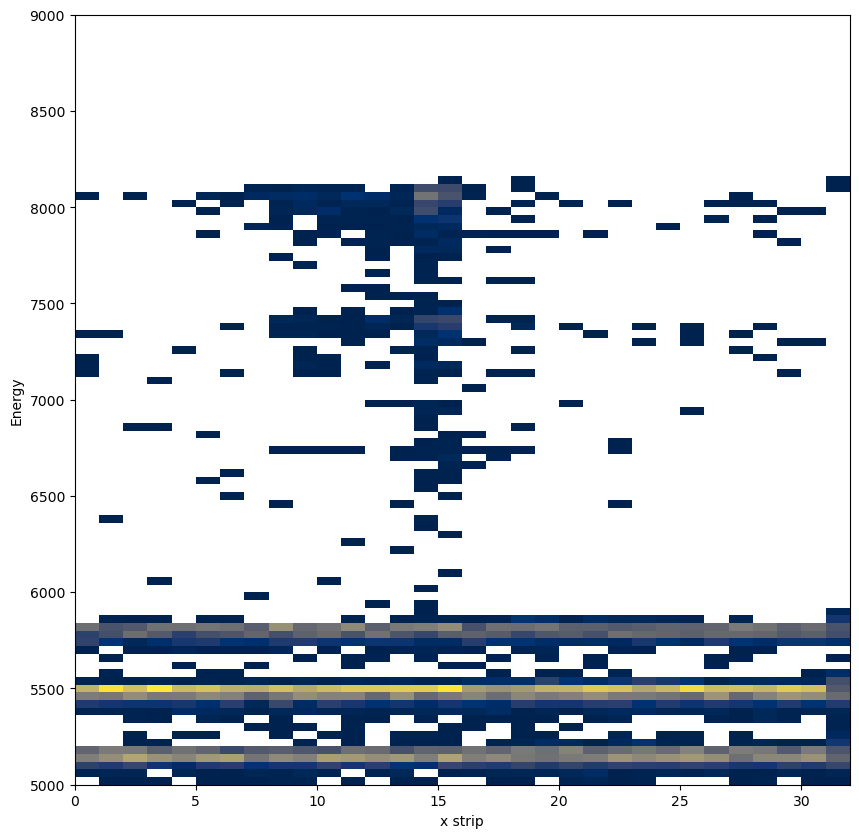

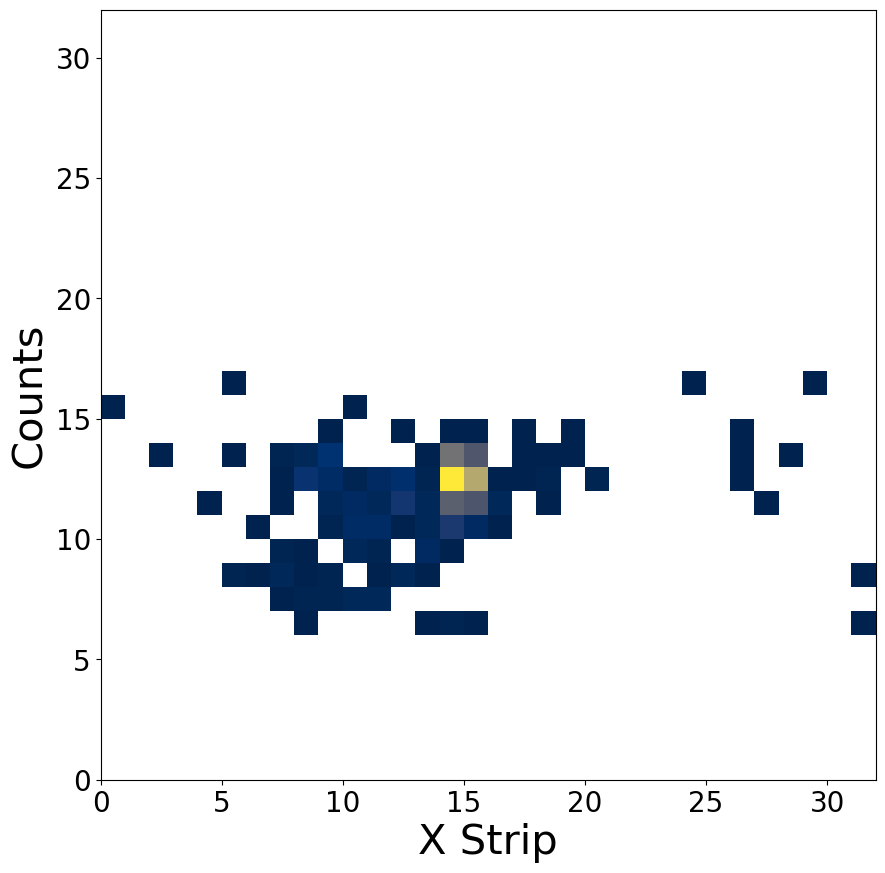

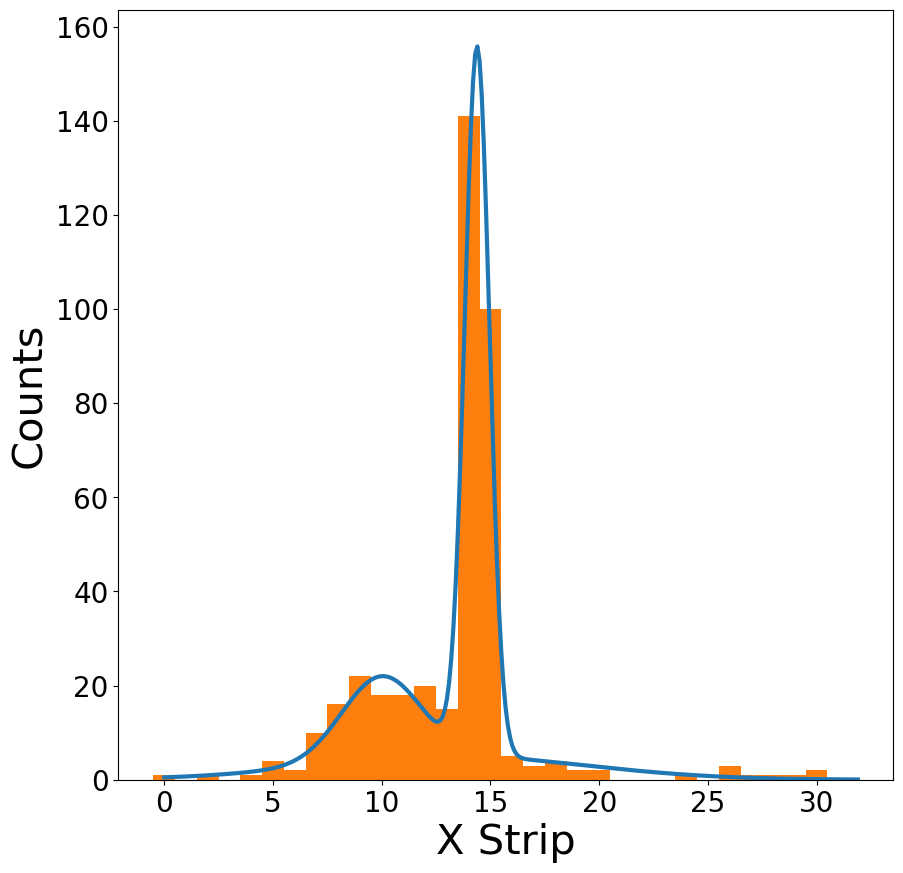

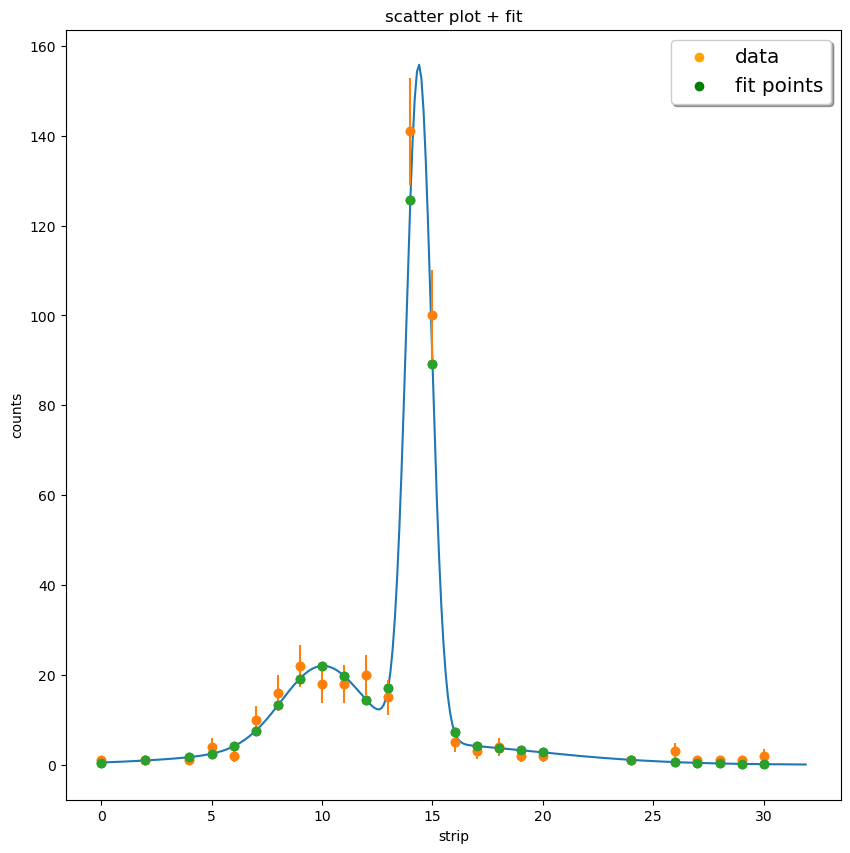

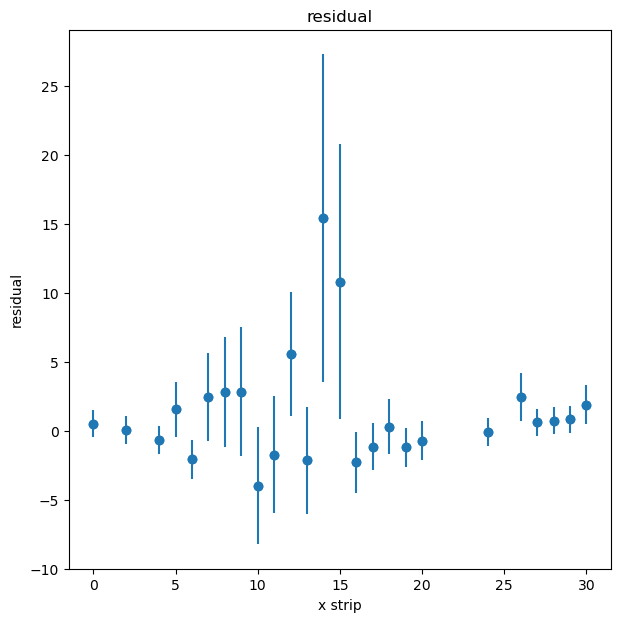

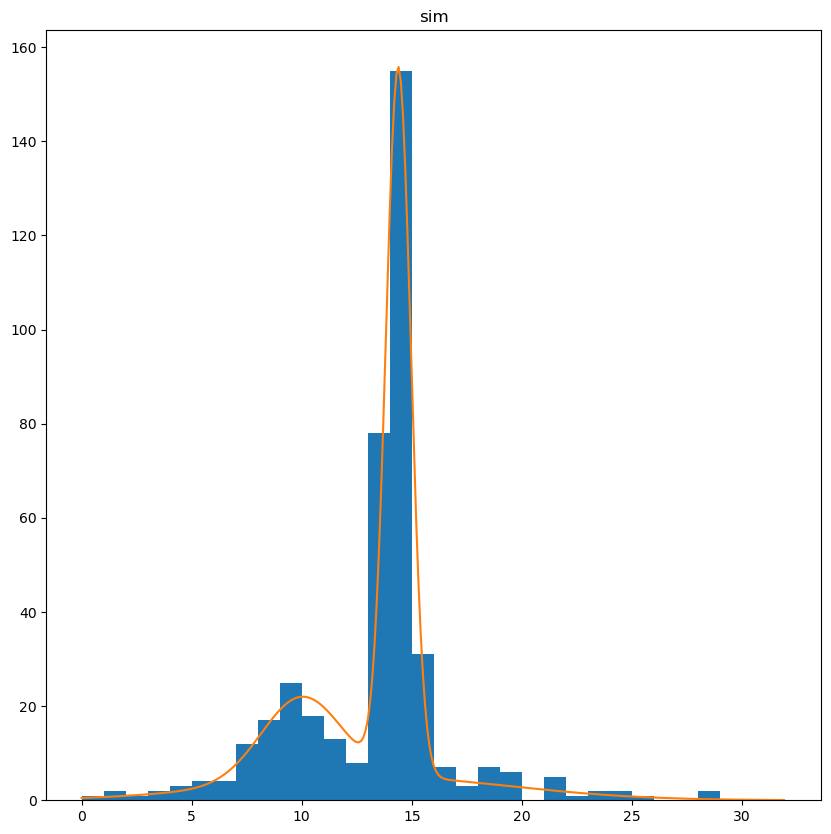

In [14]:
data = pd.read_csv('run231_050_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_050_output.txt', cal)

plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

print (df.tail())


gates = df[(df['y'] >=6) & (df['y'] < 20) & (df['xE'] > 7700) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)
bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,10,1.4,530,15,.86,310,18.4,1)

m.limits = [(0,None),(0,None),(0.1,None),(0,150), (0,None), (0,None), (5,150), (0,None), (0.2, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3)
#print(yy)
plt.figure(figsize = (10,10))
#plt.title("histogram+fit")
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)


plt.plot(bins_,yy,linewidth =3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_3)/(exp_3))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = xbins,align='left')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
total= area1+area2+area3
#print (total)
print(area2)
area_1=area1/total
area_2=area2/total
area_3=area3/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3]
sigma = [exp_1,exp_2,exp_3]
area = [area_1,area_2,area_3]
n = 413
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")






### 15.41 = 272/2, No254 + 1 waters, centered
### (272/2-271/2)/ 272/2, for 0.5% at 3.92 strips astatine 4855, is 2.88 strips/ 1 mass
### 11.3 = 271/2, 15.41-2.88  = 12.53, No(OH)
### 19.0 = 273/2 , 15.701+ 2.88  =  18.29, No$H_{2}$O-H


## f054, a/q = 344/2, no + 5 water

File: run231_054_output.txt
3 2020-03-27 01:07:23
[' mpod = 344/2+ ', ' looking for No + 5waters', ' DS count start at 3:26am']
                    name det            t   evt_num   x   y  nX  nY  \
18672  r231f054_4864.lmd  DS  5056.642678  33288995  16  23   2   1   
18673  r231f054_4864.lmd  DS  5057.622503  33289142   4  20   1   1   
18674  r231f054_4864.lmd  DS  5058.148866  33289251  27  16   1   1   
18675  r231f054_4864.lmd  DS  5058.236387  33289269  14  12   1   1   
18676  r231f054_4864.lmd  DS  5058.239364  33289270  18  10   1   1   

                xE           yE  
18672  5166.107425  5353.399799  
18673  5471.505882  5489.674755  
18674  5474.996172  5235.402830  
18675  7035.997018  7067.062889  
18676  5158.168132  5184.629699  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.28

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_80569/2215436187.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_80569/2215436187.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

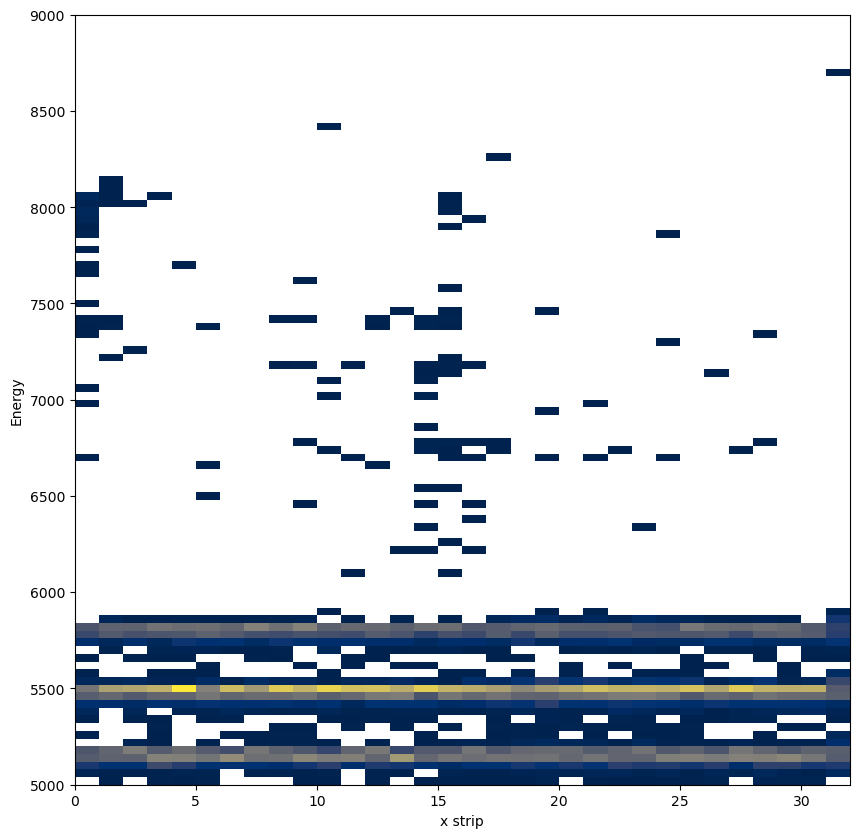

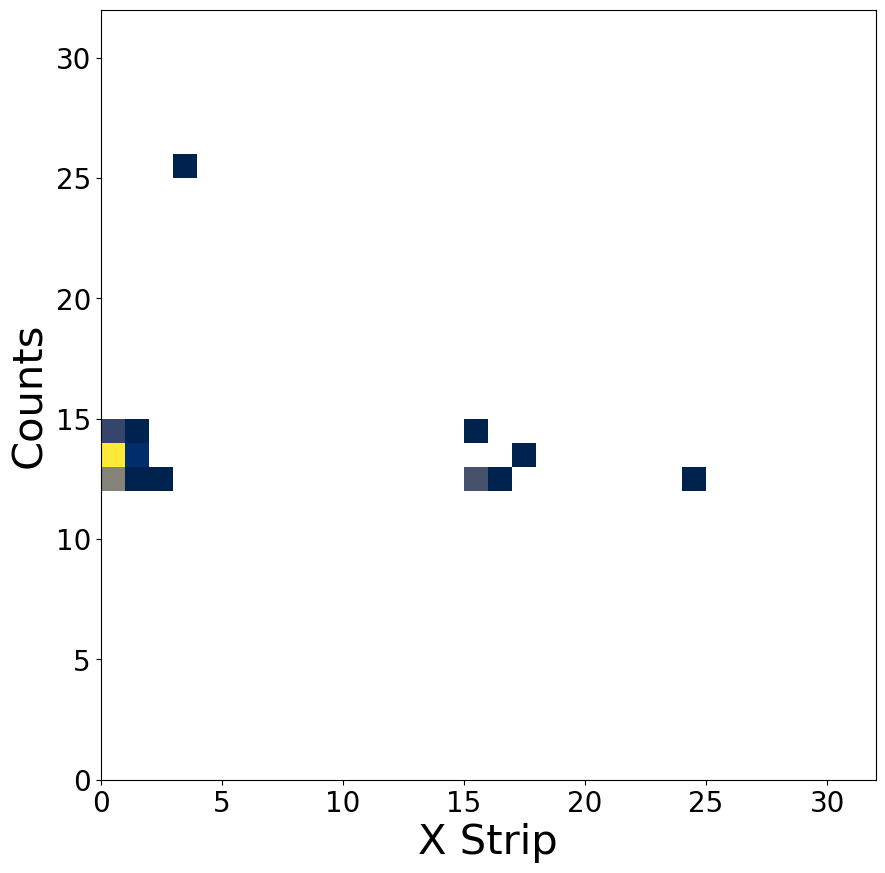

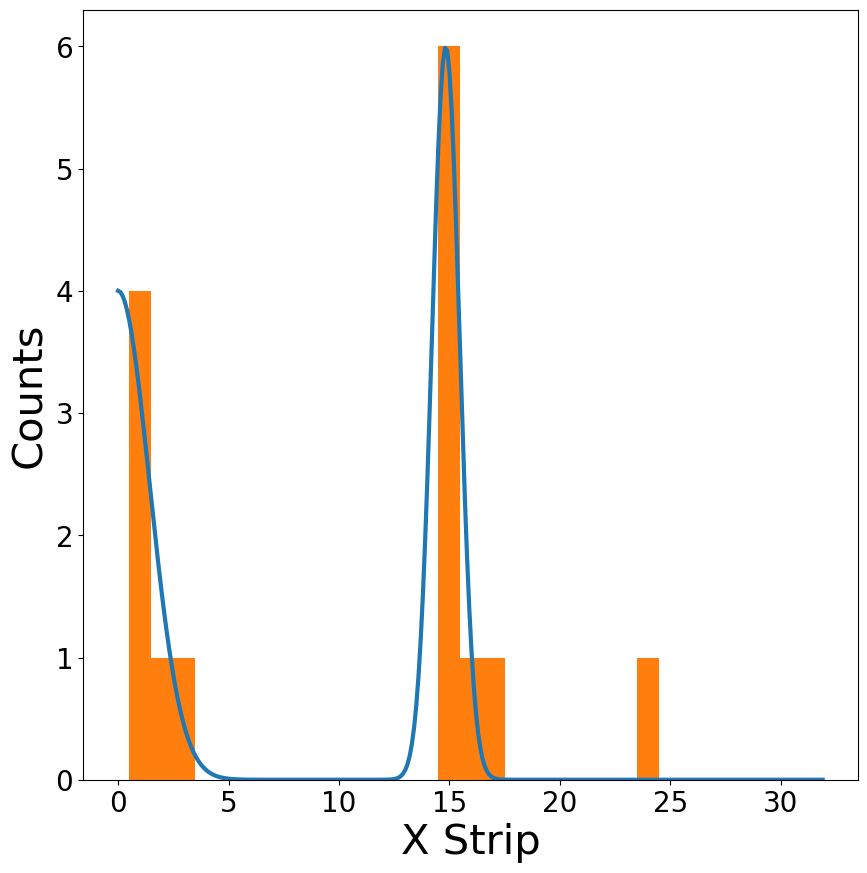

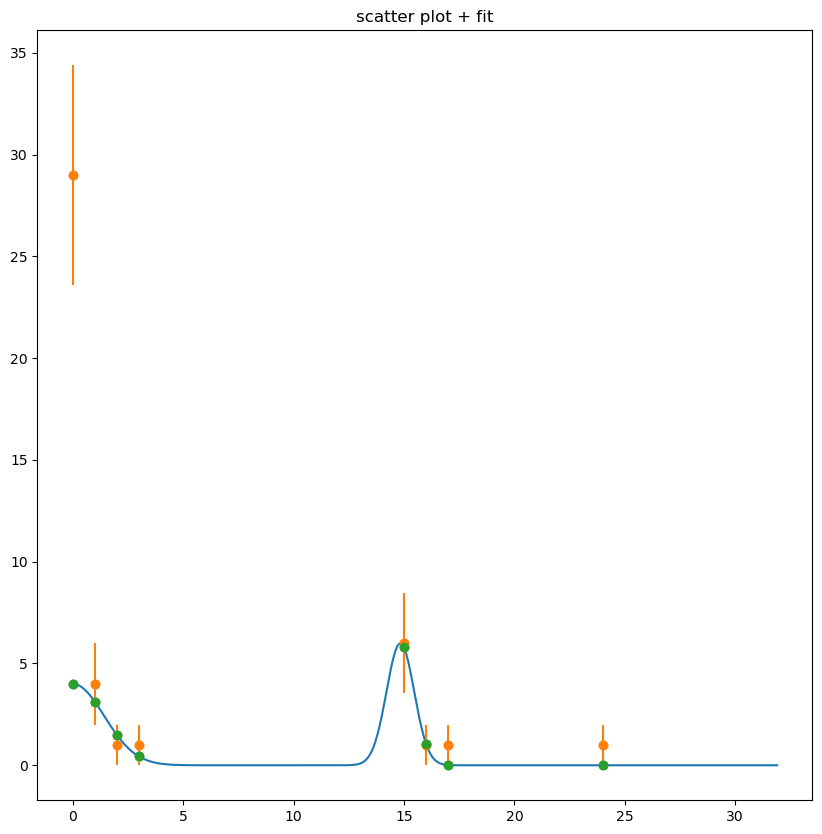

In [28]:
data = pd.read_csv('run231_054_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_054_output.txt', cal)

plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

print (df.tail())


gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7700) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]




def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,1,1.4,530,16,.86)

m.limits = [(0,4),(0,None),(0,None),(0,6), (0,None), (0,None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth=3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2+area3
#print (total)
print(area2)
area_1=area1/total
area_2=area2/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### 15.701 = 344/2, No254 + 5 waters, centered
### (344/2-343/2)/ 344/2, for 0.5% at 3.92 strips astatine f055, is 2.279 strips/ 1 mass
### 338, -6, , No+3N2
### 25.3 = 348/2 , 15.701+ 2.279 +2.279 + 2.279 + 2.279  =  24.81  No($H_{2}$O$)_{5}$-2$H_{2}$

## f056, No + 3 waters again, a/q= 308/2

## something about the size of the peaks 

File: run231_056_output.txt
3 2020-03-27 03:01:11
[' scale mpod to 308/2+', ' look at No + 3-waters again since the other waters changed a bit', ' start at 5:19am']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.98 (chi2/ndof = 2.8)    │             Nfcn = 1657              │
│ EDM = 0.000199 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/2156694574.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/2156694574.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

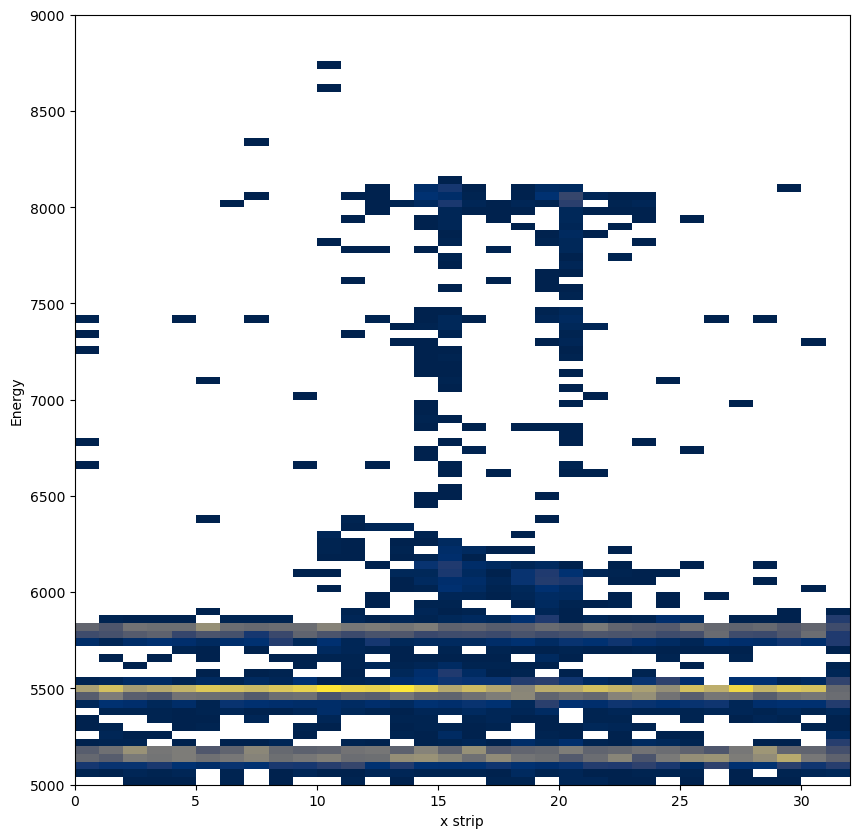

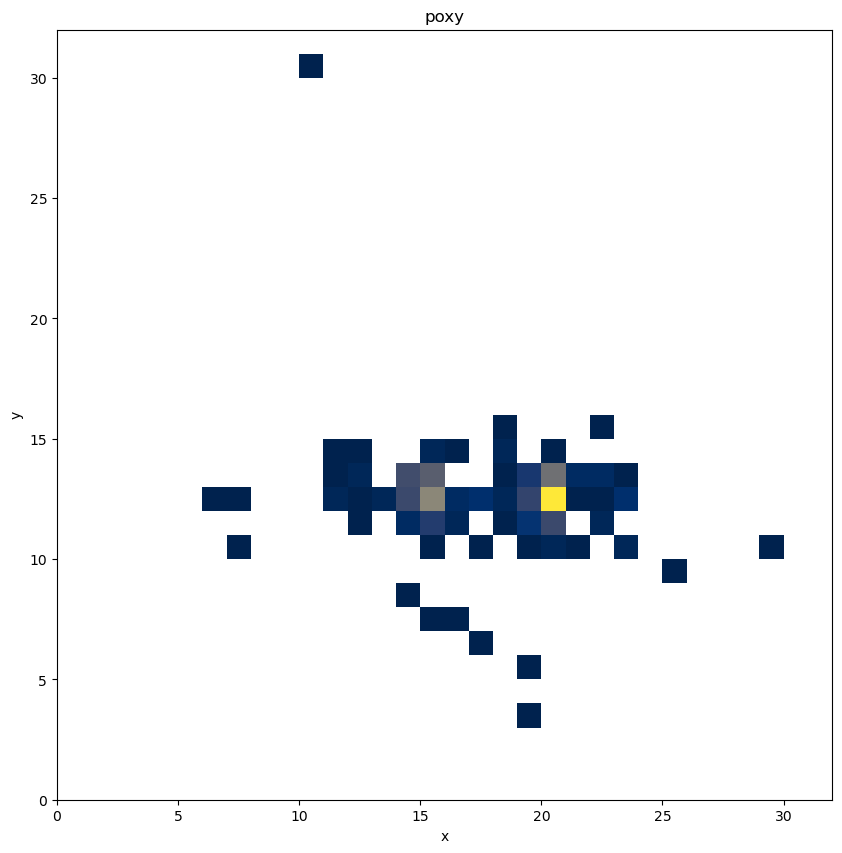

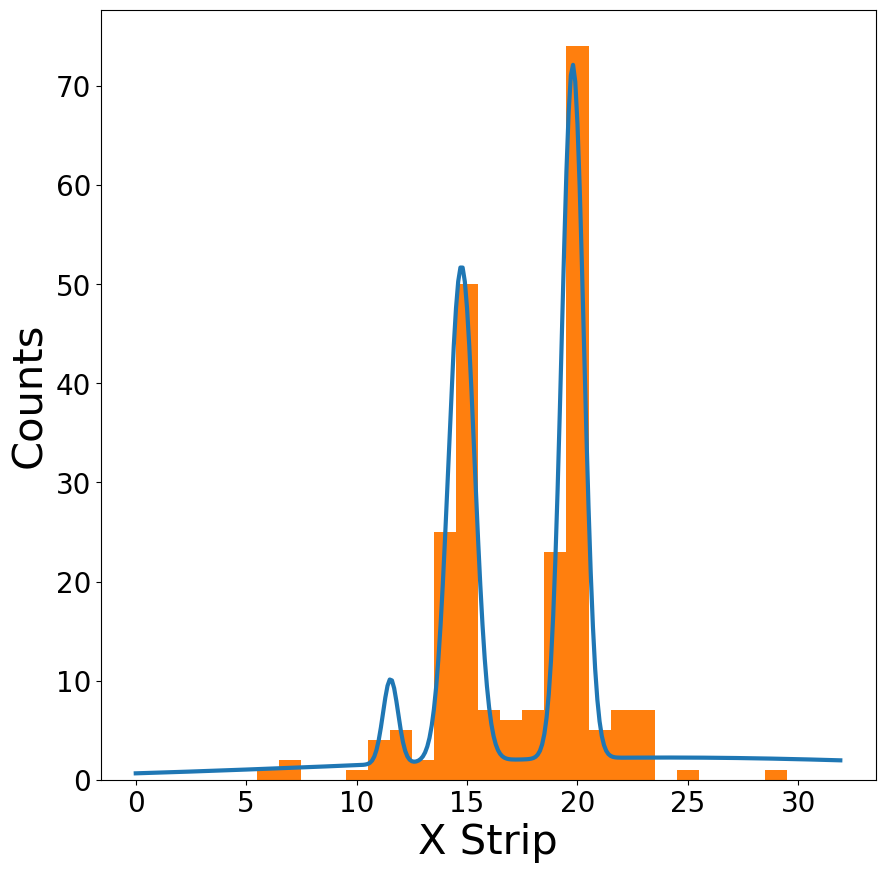

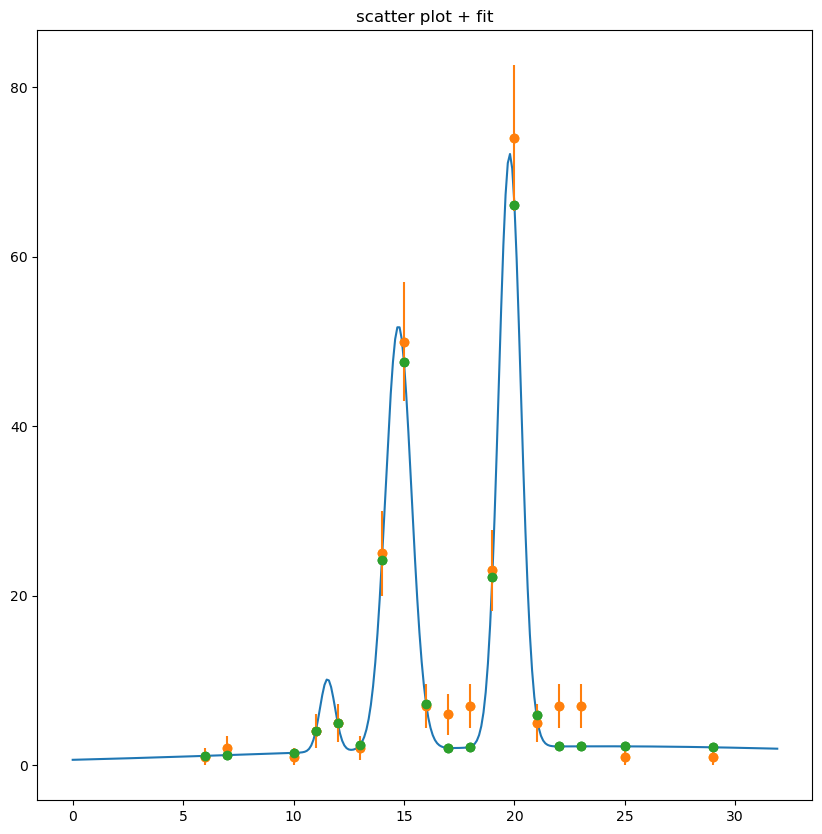

In [21]:
data = pd.read_csv('run231_056_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_056_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')


gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7600) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,12,1.4,530,16,.86,310,21,1,30,24,1.2)

m.limits = [(0,15),(0,None),(0,10),(0,50), (0,None), (0,None), (60,70 ), (0,None), (0, 80),(0,10),(24,None),(0, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (10,10))
#plt.title("histogram+fit")


plt.plot(bins_,yy, linewidth =3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)


plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 228
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")





### 15.76 = 308/2, No254 + 3 waters, centered
### (308/2-307/2)/ 308/2, for 0.5% at 3.92 strips astatine f055, is 2.55 strips/ 1 mass
###  12.56 = 307/2, 15.76-2.55 = 13.21 No($H_{2}$O$)_{2}$OH
### 20.79 = 310/2, 15.76+2.55 = 20.86, No($N_{2}$$)_{2}$
### 24 = 311/2, 15.76+ 2.55+2.55 = 23.41 No($N_{2}$$)_{2}$H

## f061, No + 6 waters ????

File: run231_061_output.txt
2 2020-03-27 07:14:58
[' A/q= 362/2', ' looking for 6 waters on the No']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.464e-07                  │              Nfcn = 127              │
│ EDM = 7.45e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴─

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/3066179778.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/3066179778.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

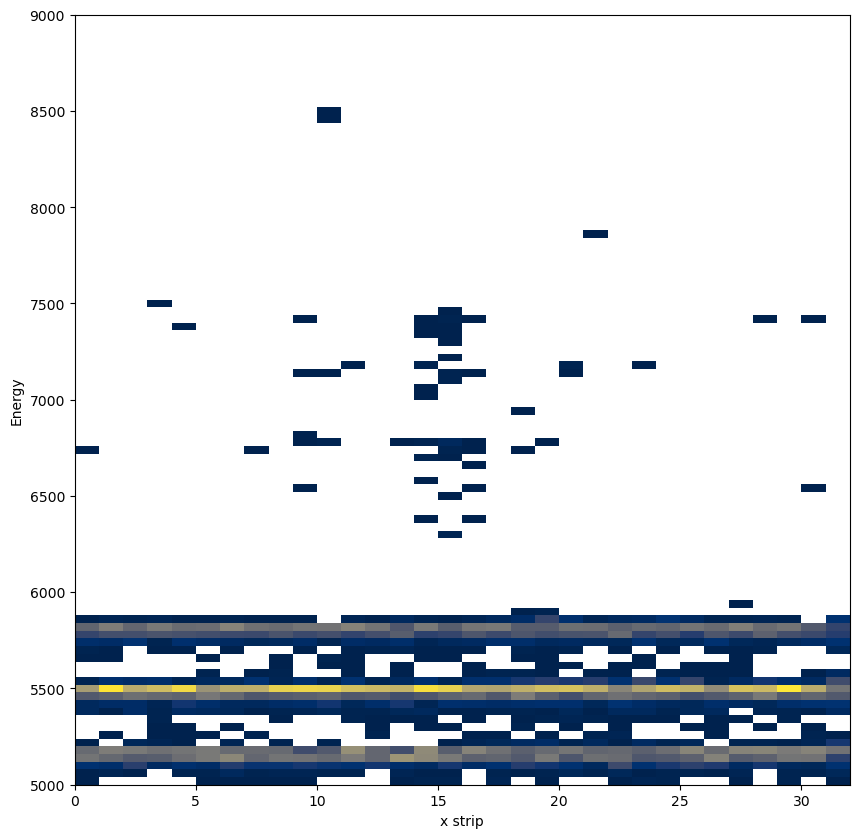

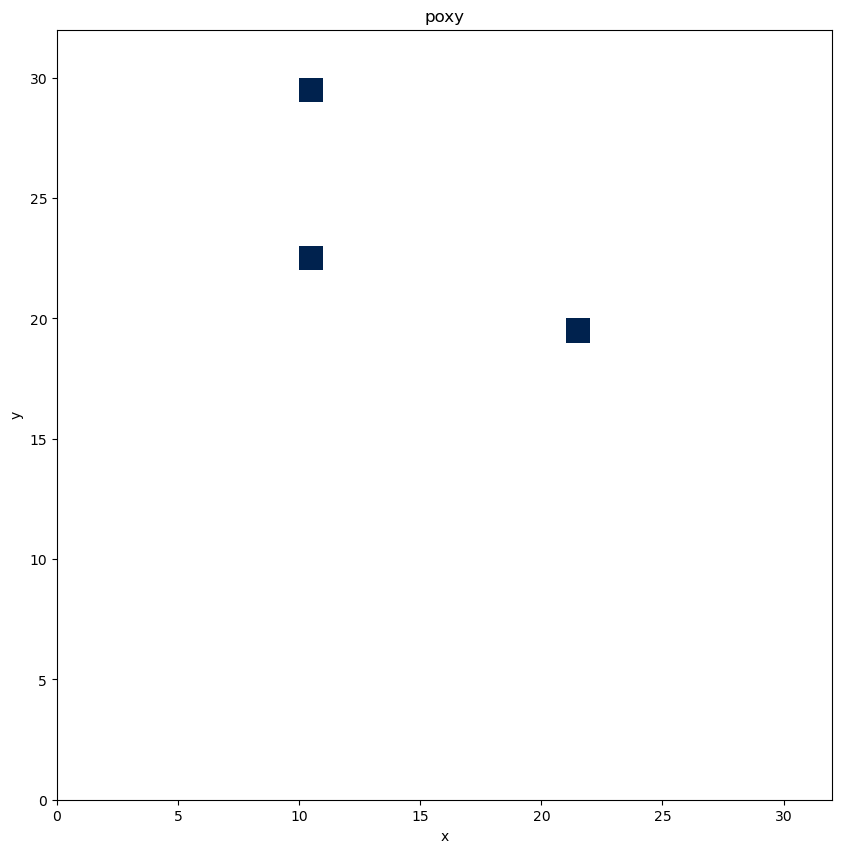

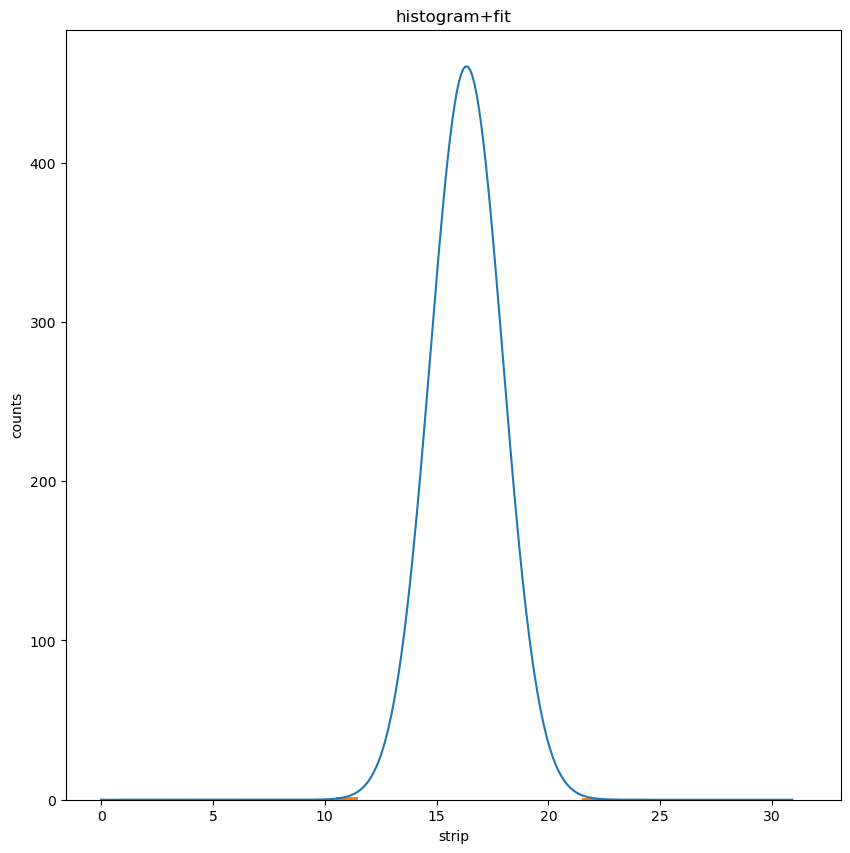

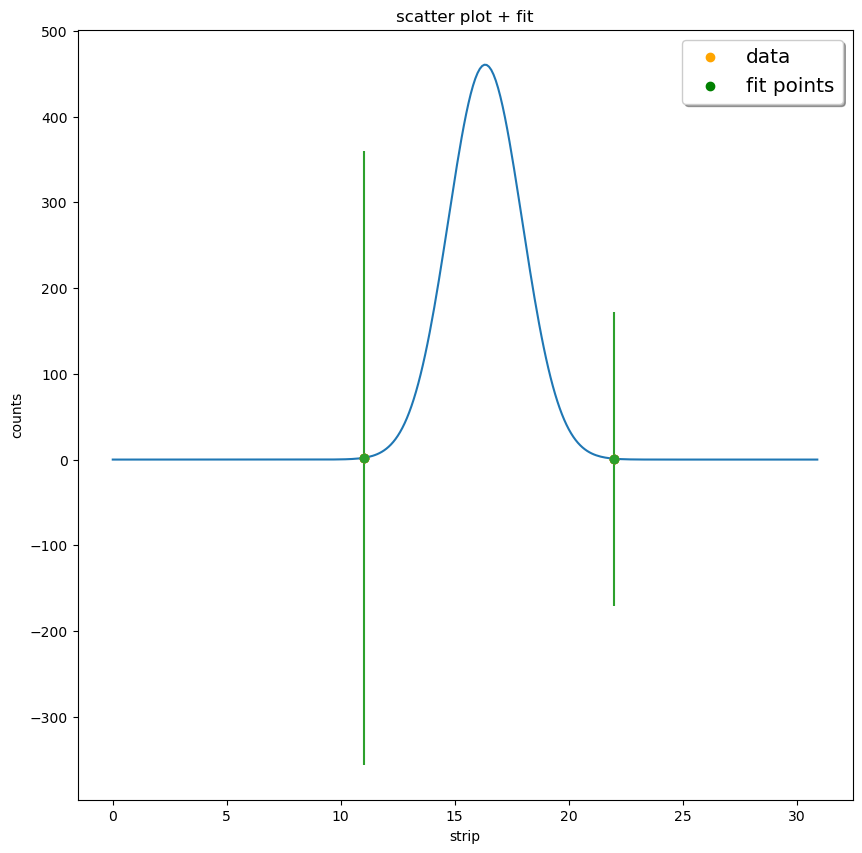

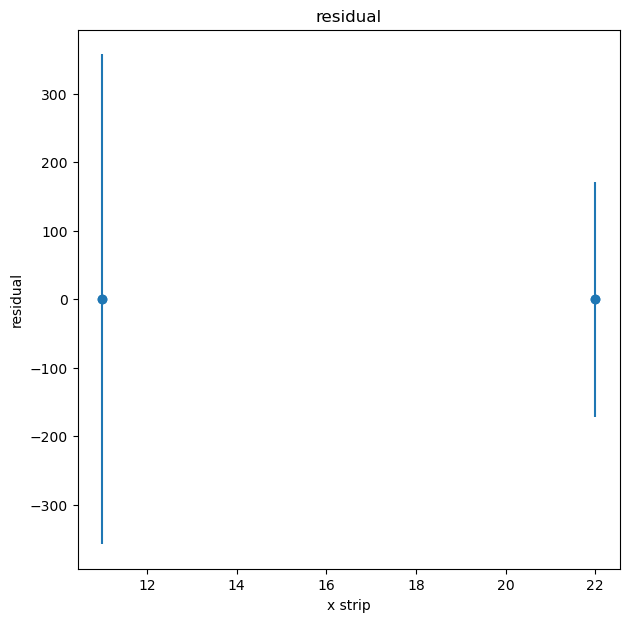

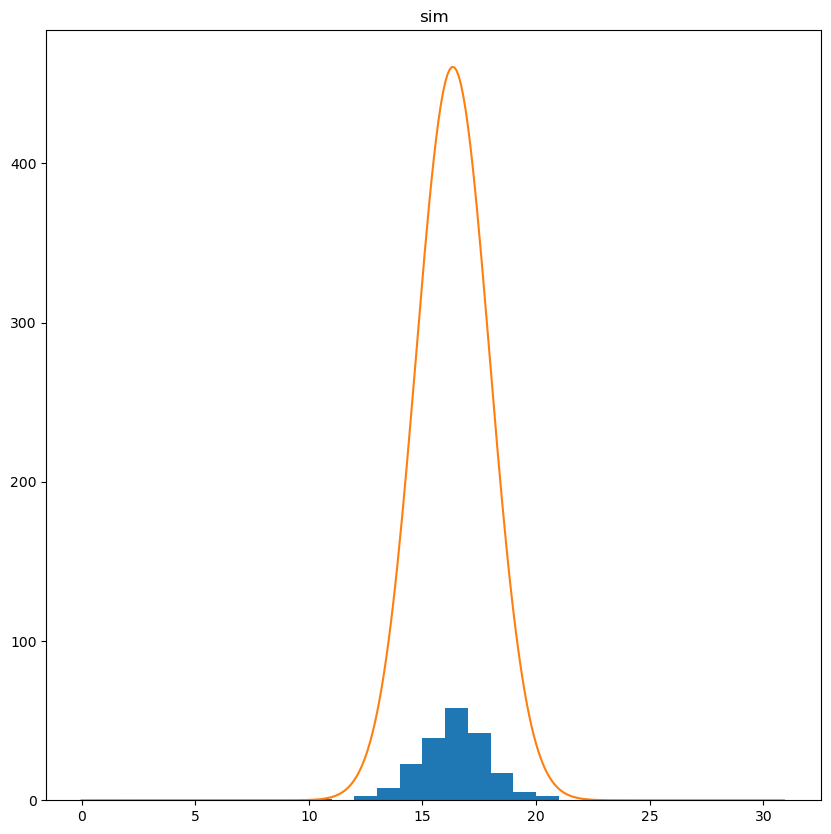

In [22]:
data = pd.read_csv('run231_061_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_061_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7600) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]

bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)



def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,16,1.4)

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))
plt.title("histogram+fit")


plt.plot(bins_,yy)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='right')
plt.ylabel("counts")
plt.xlabel("strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=reserror, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
#print(area1)
area_1=area1/total


print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,31,range = (0,31), density=False)



_bins = np.arange(0,31,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,31,.1)
plt.plot(bins_,yy)
plt.title("sim")





### nothing there at 6waters


double check that one file with the two peajs 
that one file with the math wrong
systemtics 
then with ratios 
water first 
inflated error


# compounds

## f035, baseline, NoF, a/q= 273/1

File: run231_035_output.txt
4 2020-03-25 07:27:46
[' A/q=273/1', ' looking for NoF with no gas in', ' baseline meas', ' no growth/decay']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_38550/2392760475.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_38550/2392760475.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


227.07991949833314
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.98 (chi2/ndof = 1.0)     │              Nfcn = 94               │
│ EDM = 1.86e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────

NameError: name 'area_2' is not defined

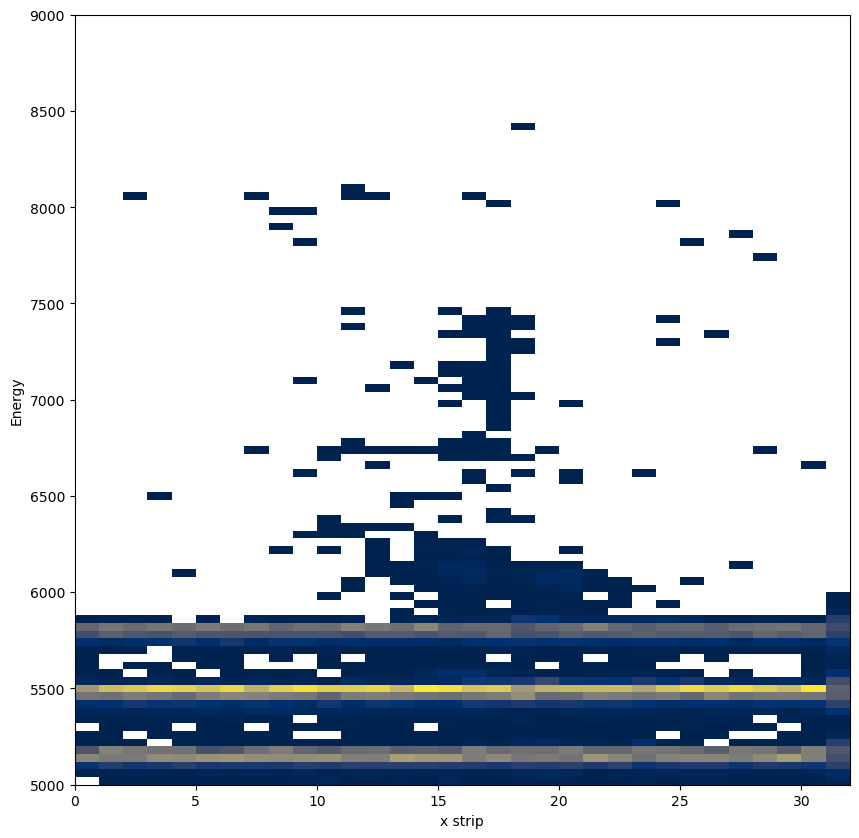

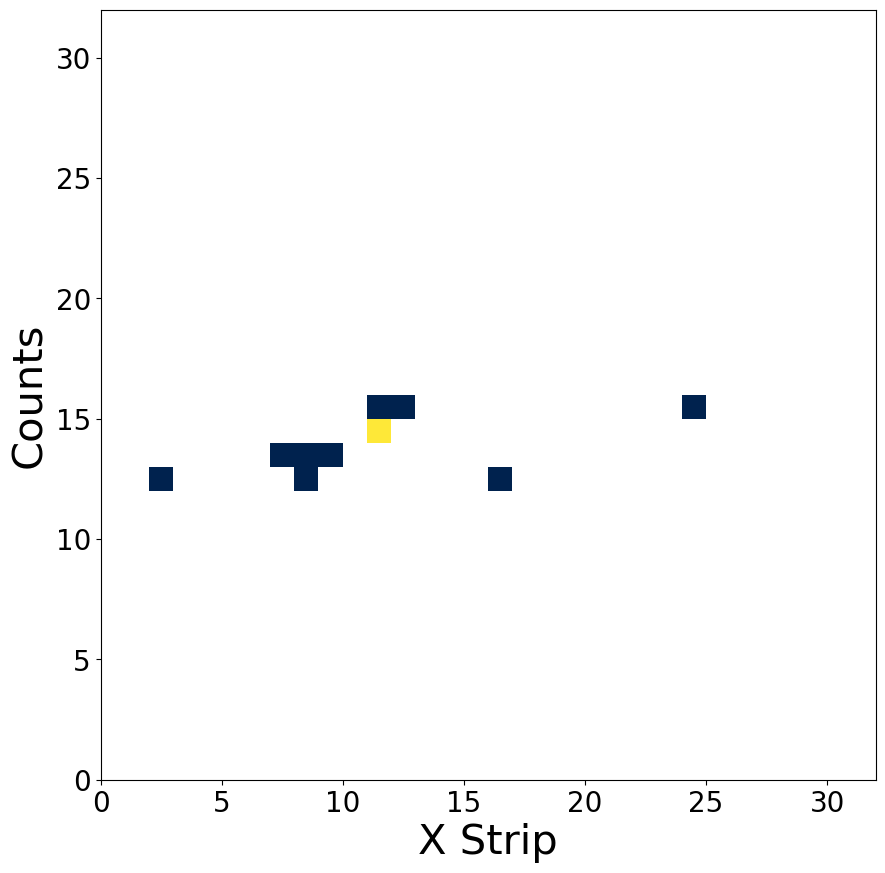

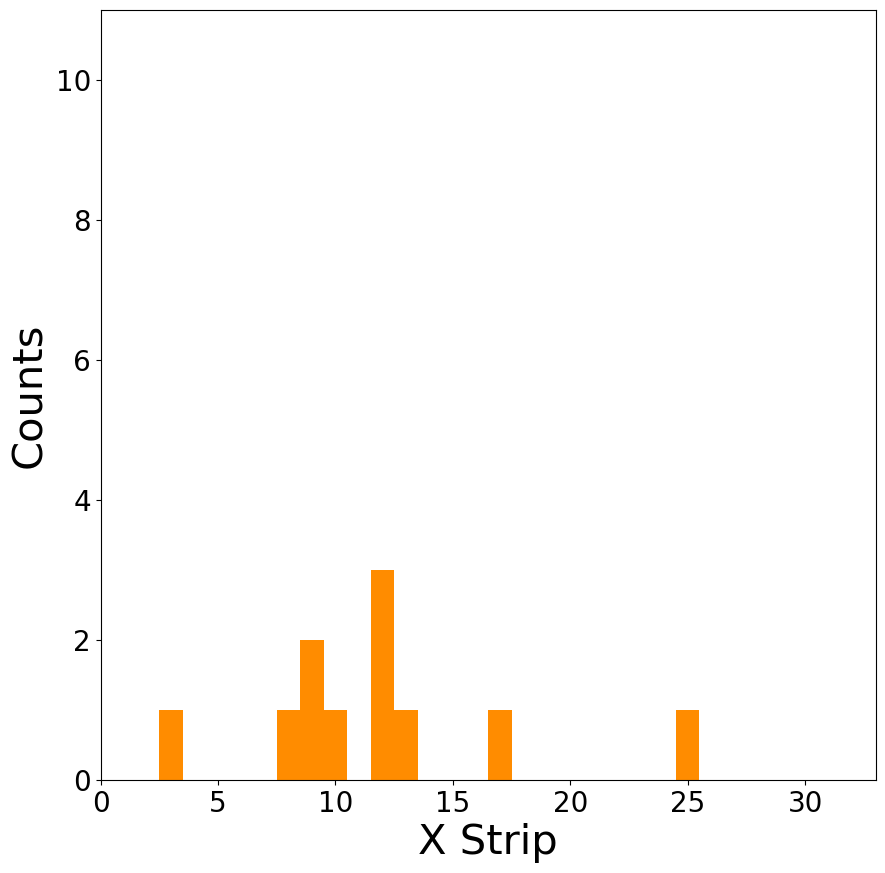

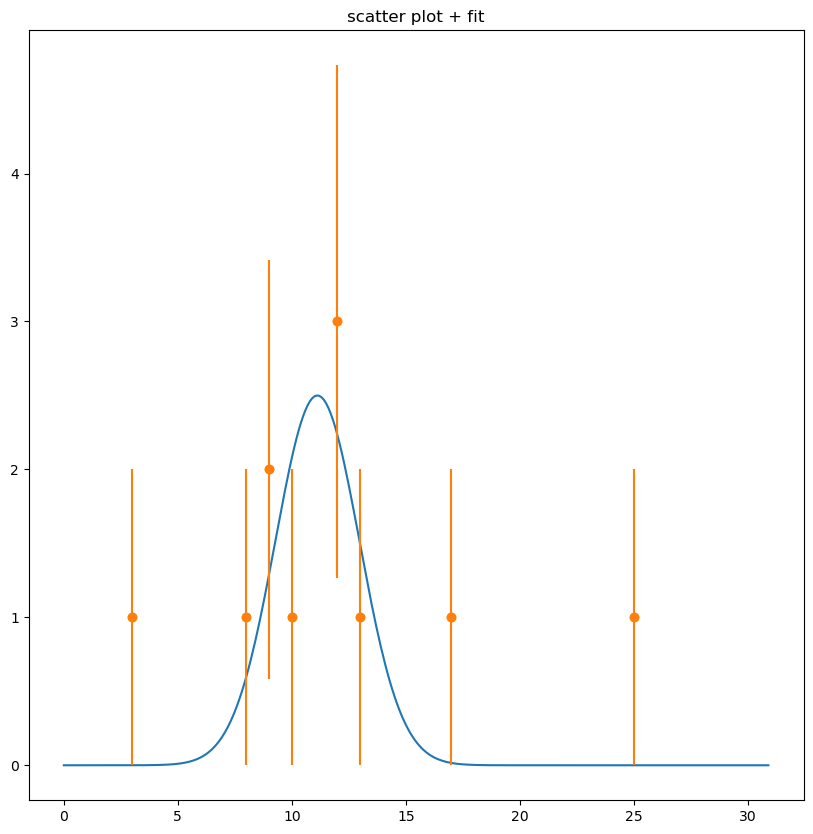

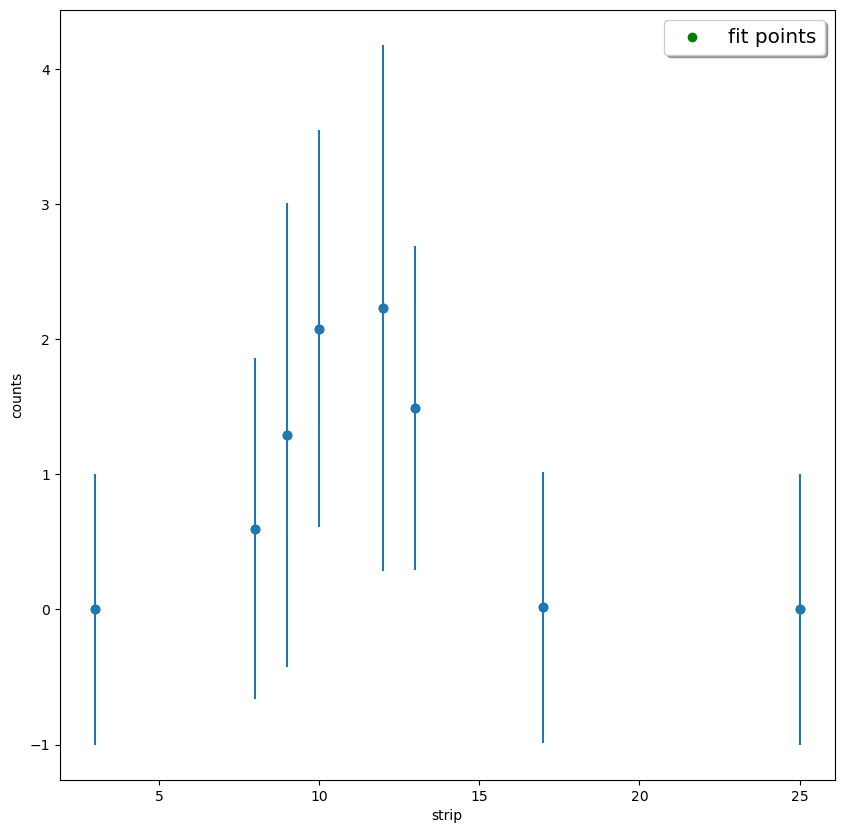

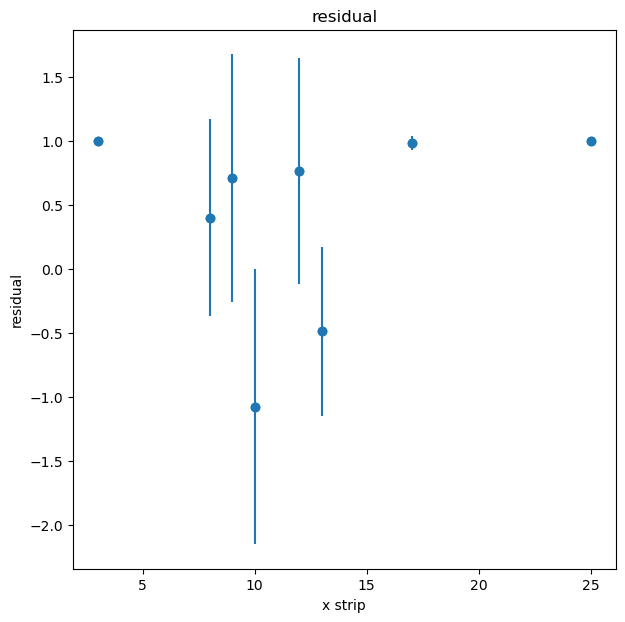

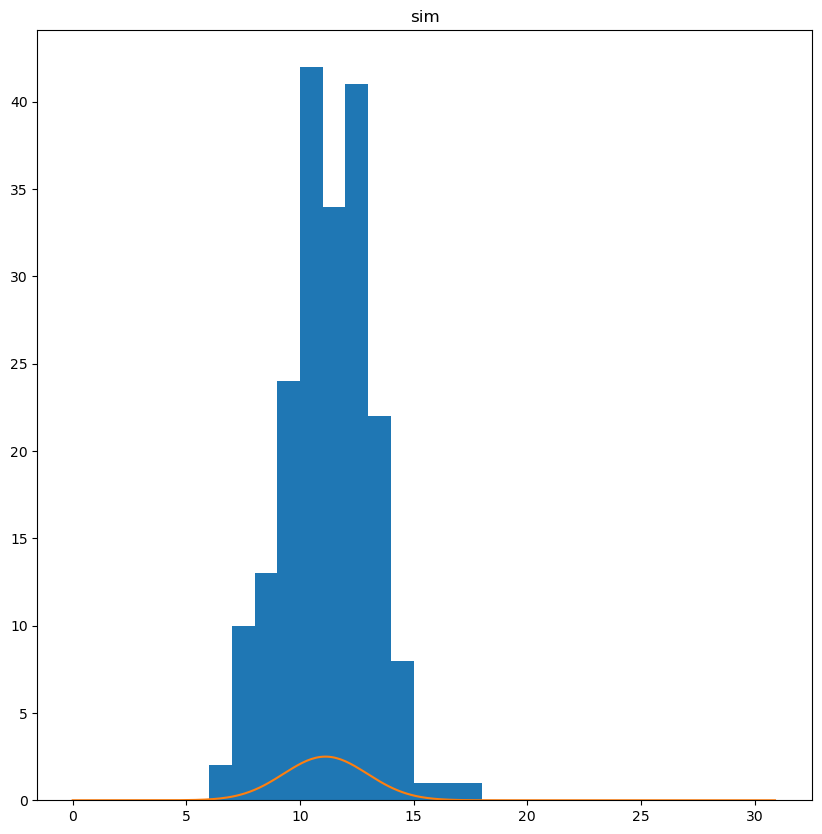

In [5]:
data = pd.read_csv('run231_035_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_035_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
duration = (max(df['t']) - min(df['t']))/60
print (duration)

gates = df[(df['y'] >=11) & (df['y'] < 18) & (df['xE'] > 7800) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]

bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)



def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,10,1.4)
m.limits=((2.5,3), (None,None),(0,None))

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.ylim(0,11)

#plt.plot(bins_,yy,linewidth=3, color = 'blue')
#plt.axvline(x = 15.39, color = 'r', label = 'Based on f036')
#plt.axvline(x = 12.45, color = 'g', label = 'Predicted based on dispersion, 1x')
#plt.axvline(x = 9.51, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 18.33, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 21.27, color = 'g', label = 'Predicted based on dispersion, 2x')



c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='right', color = 'darkorange')
#plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")

plt.figure(figsize= (10,10))


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=reserror, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
#print(area1)
area_1=area1/total


print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,31,range = (0,31), density=False)



_bins = np.arange(0,31,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,31,.1)
plt.plot(bins_,yy)
plt.title("sim")

filedur = max(df['t']) - min(df['t'])
counts_F = area_2*sum(counts)
rate = counts_F/filedue
print (rate)



# no peak centered
### baseline peak 10.07 = No($H_{2}$O)

### f036, NoF, with gas

File: run231_036_output.txt
2 2020-03-25 17:36:39
[' 1e-4 mbarL/s C3F6', ' looking for NoF molecules']
92.49274842166663
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.83 (chi2/ndof = 1.4)    │              Nfcn = 220              │
│ EDM = 6.55e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_56852/3144856505.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_56852/3144856505.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

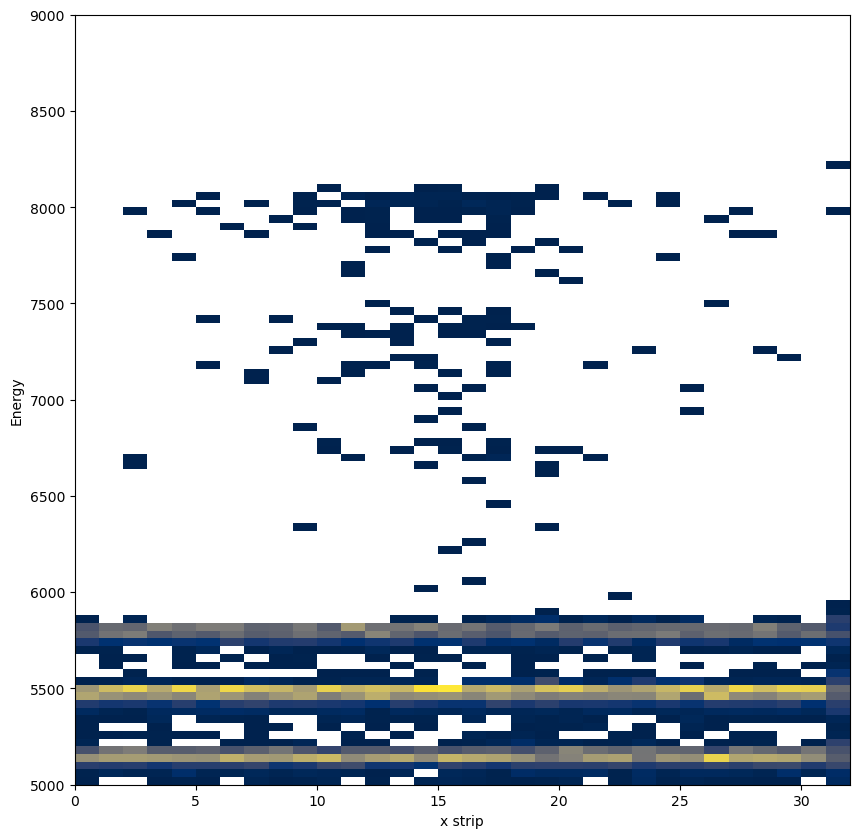

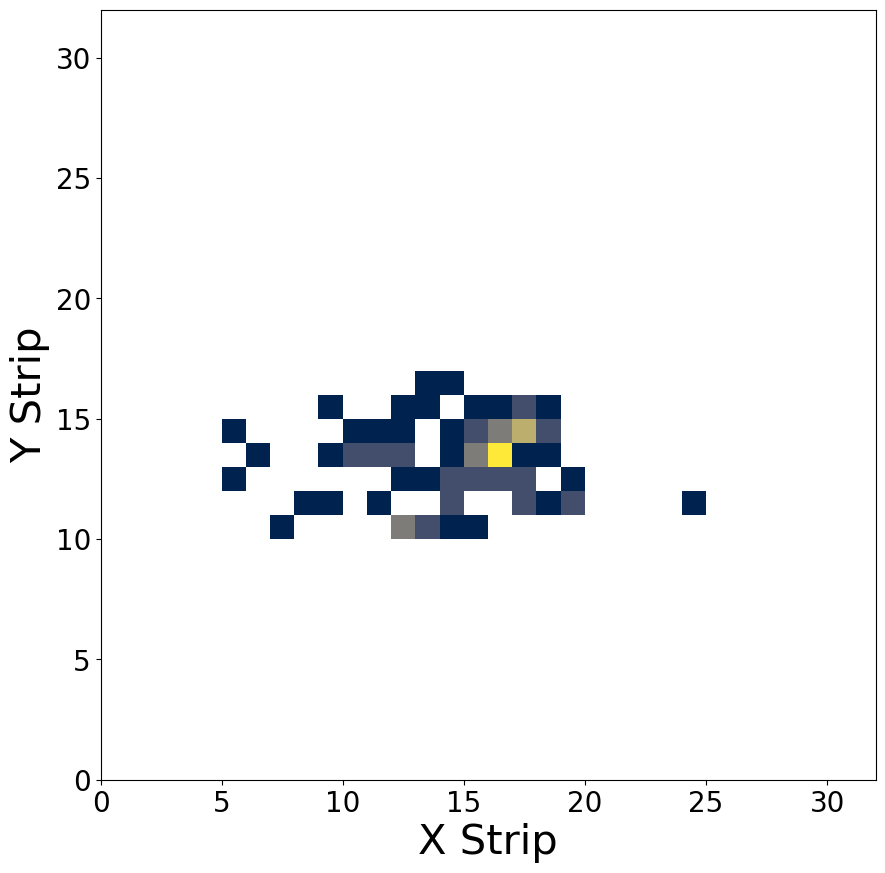

<Figure size 1000x1000 with 0 Axes>

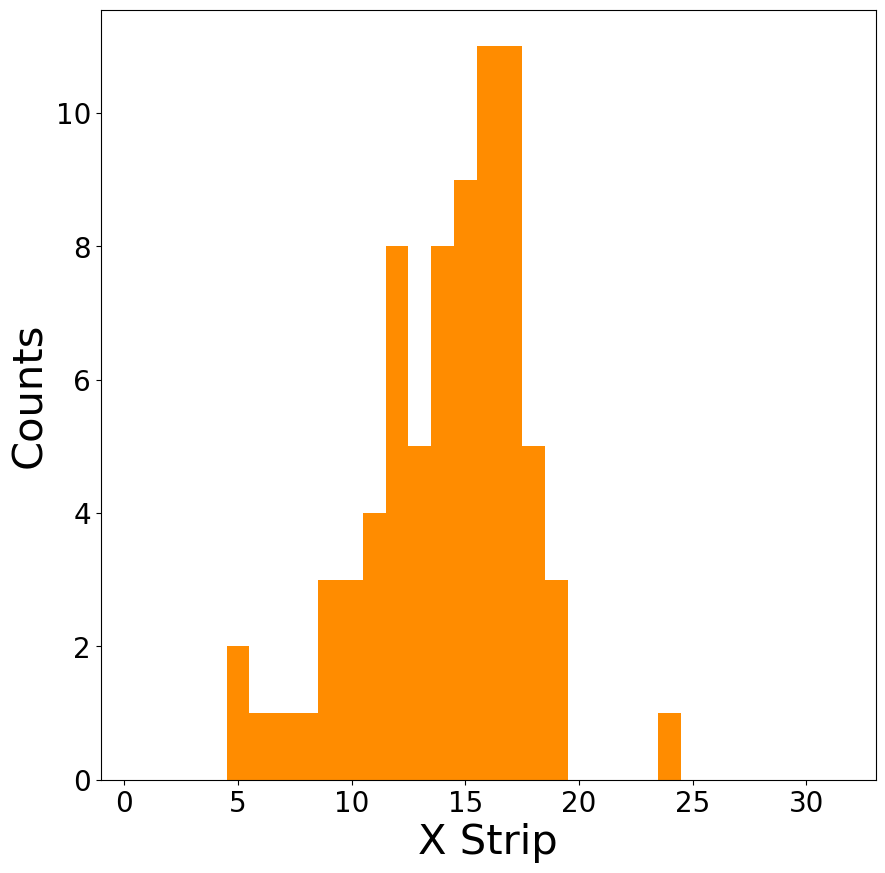

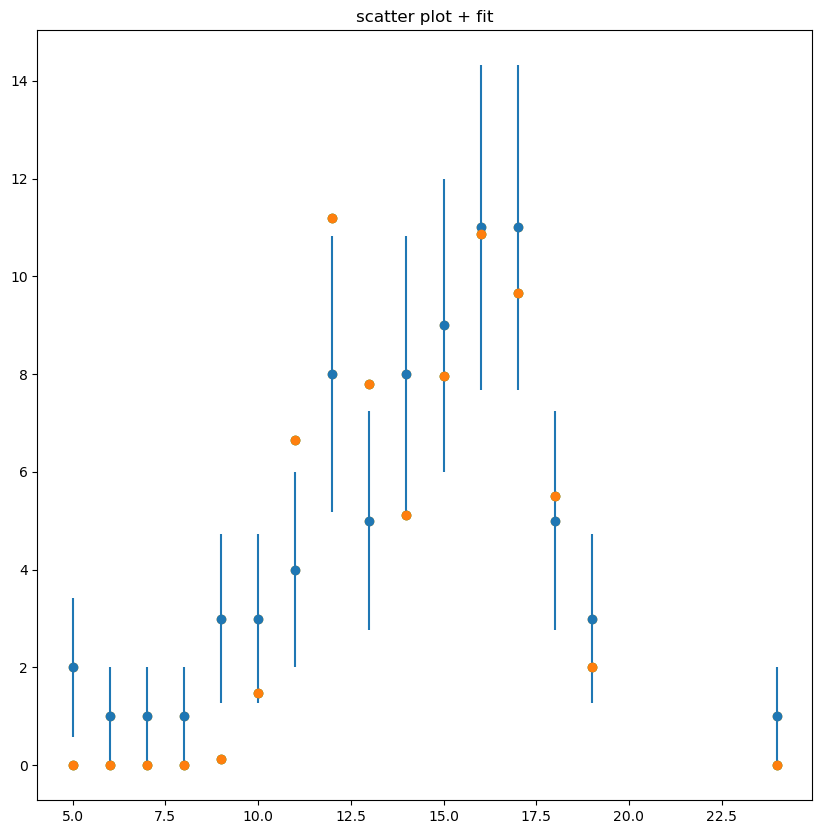

In [4]:
data = pd.read_csv('run231_036_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_036_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

duration = (max(df['t']) - min(df['t']))/60
print (duration)

gates = df[(df['y'] >=10) & (df['y'] < 17) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,2,11,1.4,16,9,1)

m.limits = [(11,11),(0,None),(1,1.5),(0,11), (15,None), (1,1.5)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_ox= onepeak(bins_,amp_1,cen_1,exp_1)
yy_f= onepeak(bins_,amp_2,cen_2,exp_2)






#print(yy)
plt.figure(figsize = (10,10))
#plt.title("histogram+fit")

#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

#plt.plot(bins_,yy, linewidth=3, color = 'blue')
#plt.plot(bins_,yy, color = 'blue')
#plt.plot(bins_,yy_ox, color= 'blue', linestyle= 'dashed')
#plt.plot(bins_,yy_f,color= 'blue', linestyle= 'dashed')
#plt.axvline(x = 15.39, color = 'r', label = 'Based on f036')
#plt.axvline(x = 12.45, color = 'g', label = 'Predicted based on dispersion, 1x')
#plt.axvline(x = 9.51, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 18.33, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 21.27, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 6.57, color = 'g', label = 'Predicted based on dispersion, 2x')




c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (10,10))



plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2+area3
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
rutherfords= 59403
counterperruth = area2/rutherfords
print(counterperruth)
#print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")







### centered at 16.26, 273/1, NoF, astatine file 37, should be 2.92
### 12 = 271/1, 16-2.88= 13.11, No$H_{2}$O

File: run231_036_output.txt
2 2020-03-25 17:36:39
[' 1e-4 mbarL/s C3F6', ' looking for NoF molecules']
92.49274842166663
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 25.68 (chi2/ndof = 1.3)    │              Nfcn = 188              │
│ EDM = 1.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_56852/333939368.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_56852/333939368.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

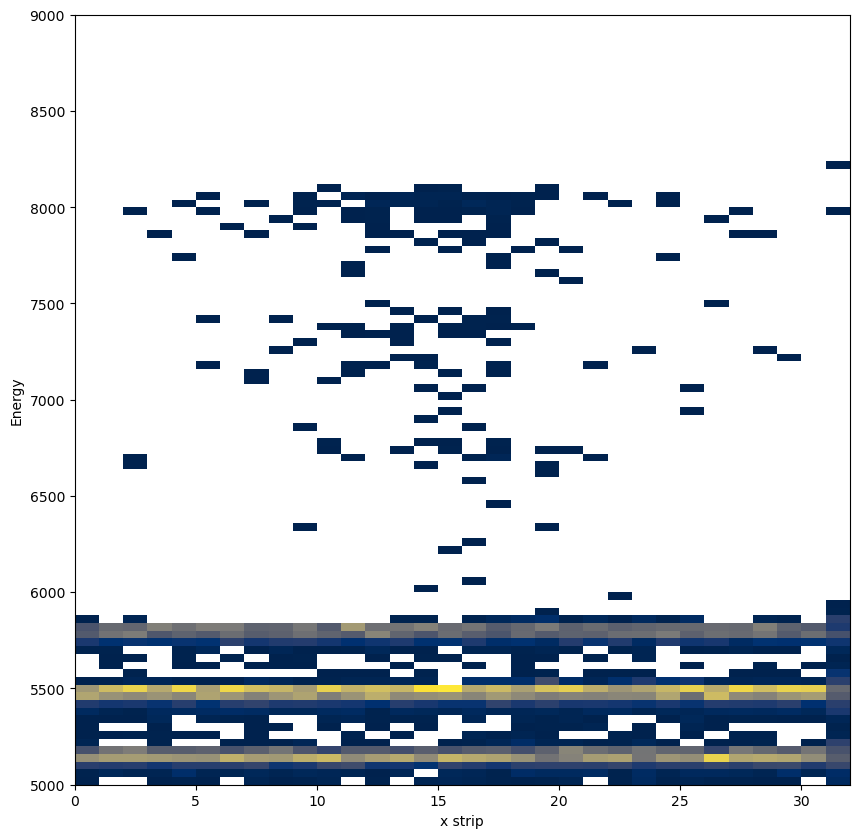

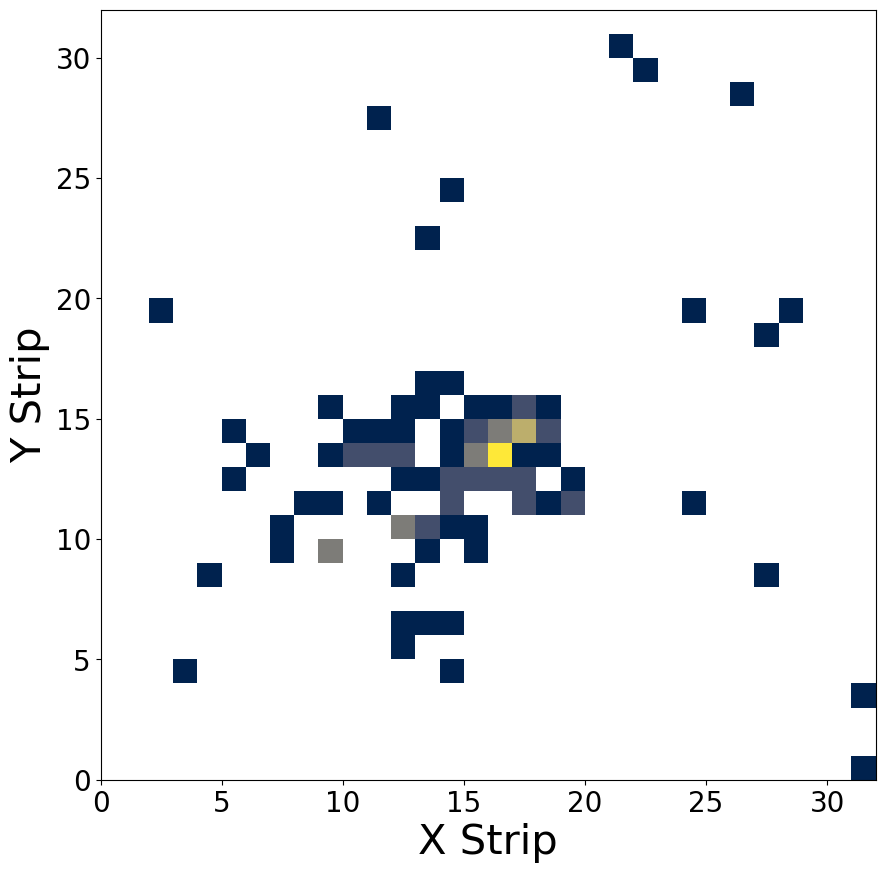

<Figure size 1000x1000 with 0 Axes>

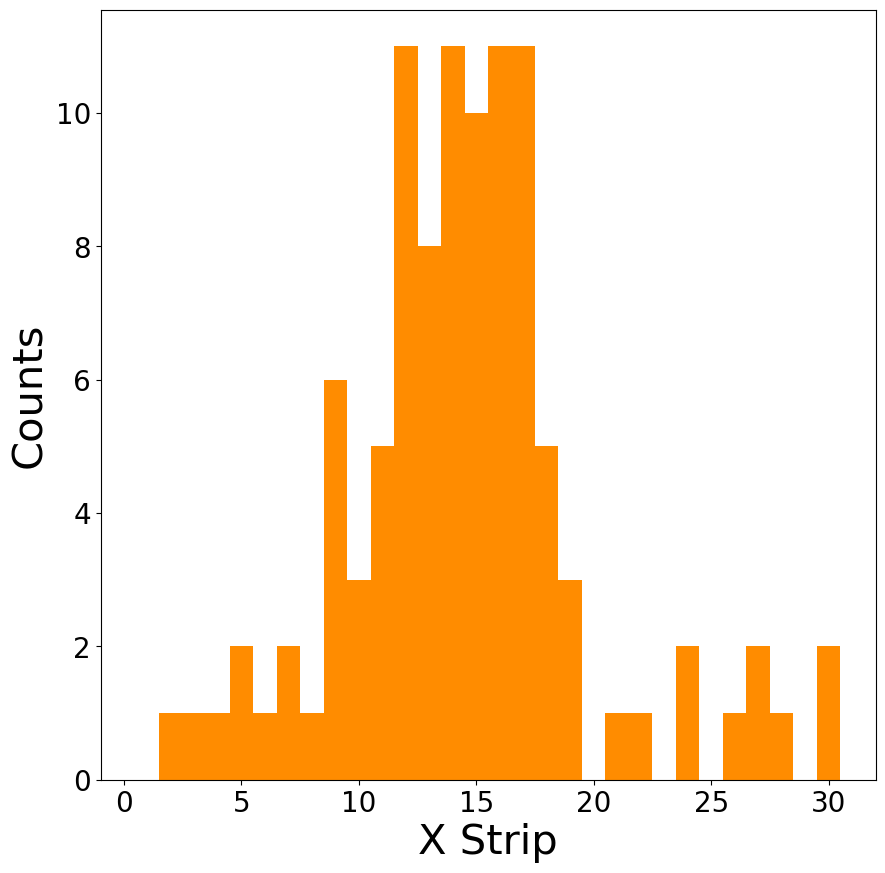

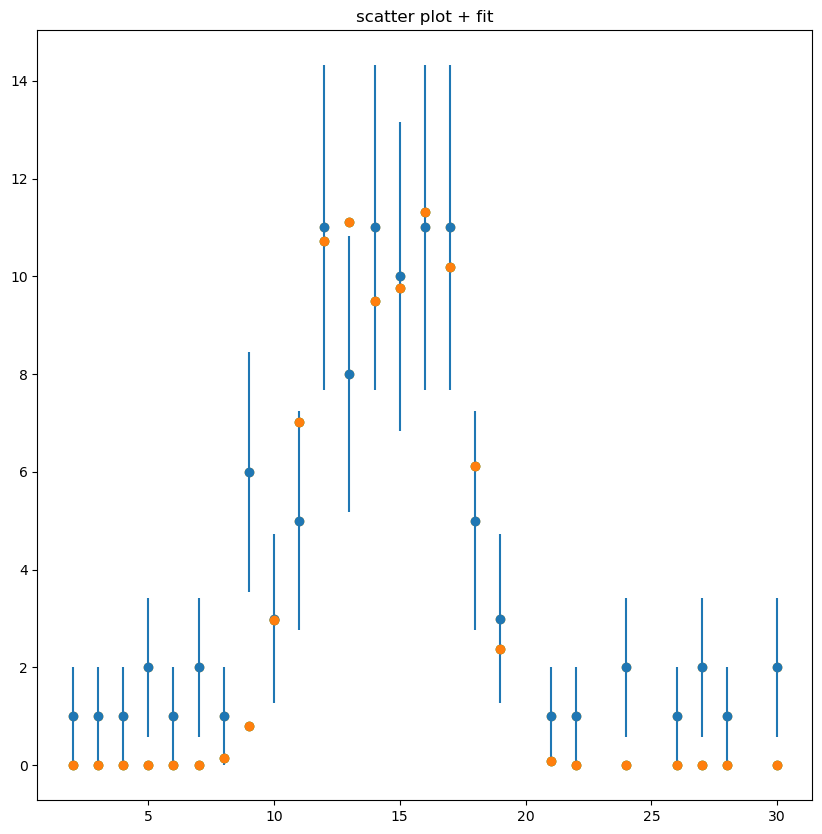

In [5]:
data = pd.read_csv('run231_036_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_036_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

duration = (max(df['t']) - min(df['t']))/60
print (duration)

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,2,11,1.4,16,9,1)

m.limits = [(11,11),(0,None),(1,1.5),(0,11), (15,None), (1,1.5)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_ox= onepeak(bins_,amp_1,cen_1,exp_1)
yy_f= onepeak(bins_,amp_2,cen_2,exp_2)






#print(yy)
plt.figure(figsize = (10,10))
#plt.title("histogram+fit")

#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

#plt.plot(bins_,yy, linewidth=3, color = 'blue')
#plt.plot(bins_,yy, color = 'blue')
#plt.plot(bins_,yy_ox, color= 'blue', linestyle= 'dashed')
#plt.plot(bins_,yy_f,color= 'blue', linestyle= 'dashed')
#plt.axvline(x = 15.39, color = 'r', label = 'Based on f036')
#plt.axvline(x = 12.45, color = 'g', label = 'Predicted based on dispersion, 1x')
#plt.axvline(x = 9.51, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 18.33, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 21.27, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 6.57, color = 'g', label = 'Predicted based on dispersion, 2x')




c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (10,10))



plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2+area3
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
rutherfords= 59403
counterperruth = area2/rutherfords
print(counterperruth)
#print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")







### f078, No$F_{2}$, 292/1

File: run231_078_output.txt
3 2020-03-28 05:55:14
[' mpod = 292/1+', ' c3f6 in the trap', ' start at 8:13am']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_11770/3629963163.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_11770/3629963163.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when le

121.14714689333329
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 68.69 (chi2/ndof = 4.6)    │              Nfcn = 199              │
│ EDM = 1.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────

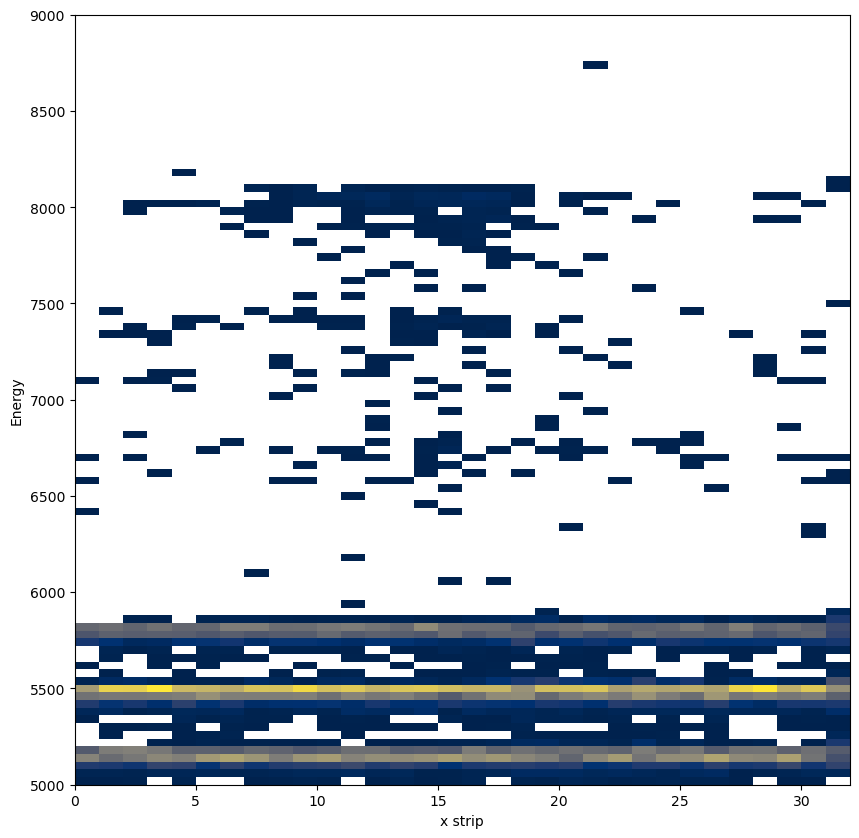

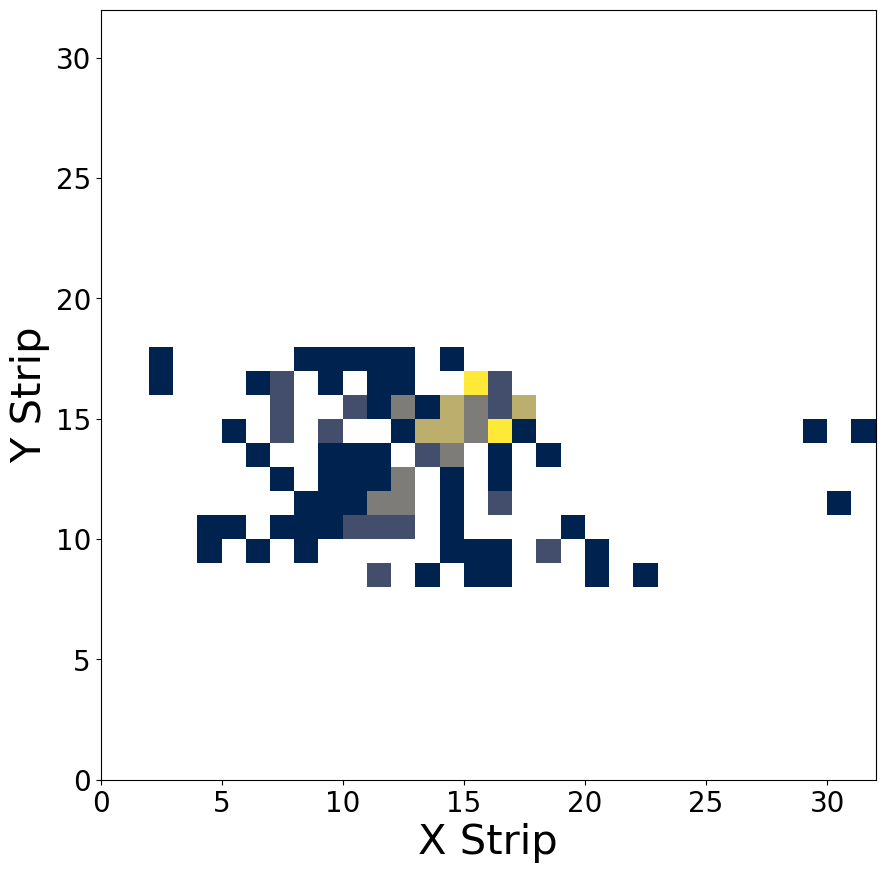

<Figure size 1000x1000 with 0 Axes>

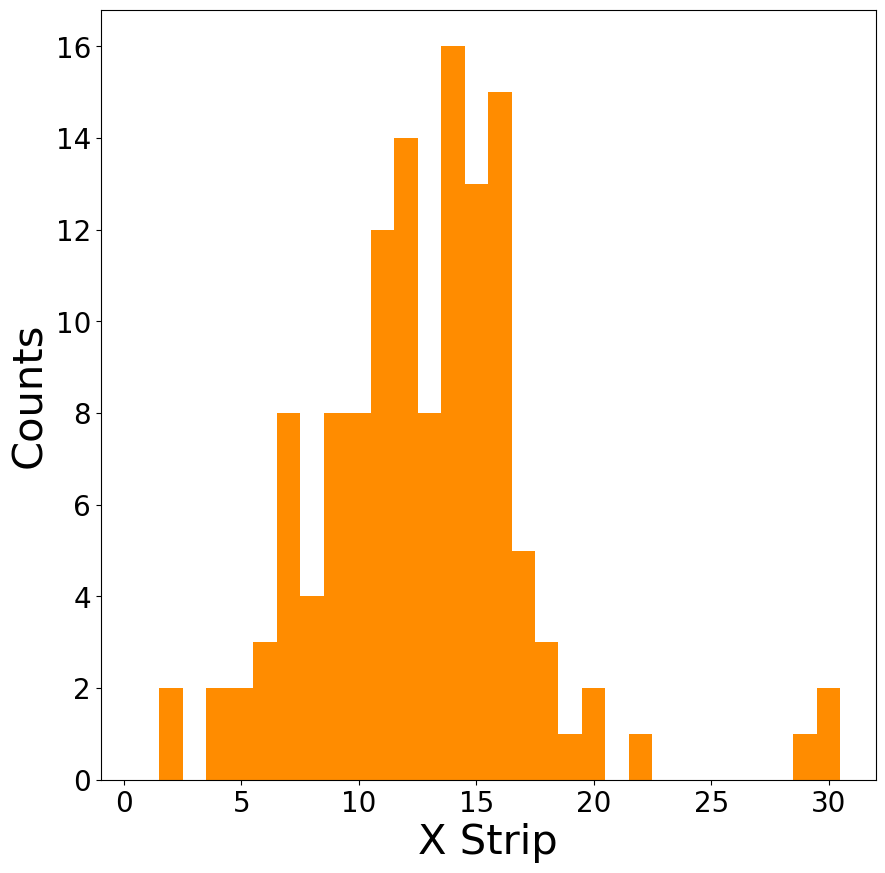

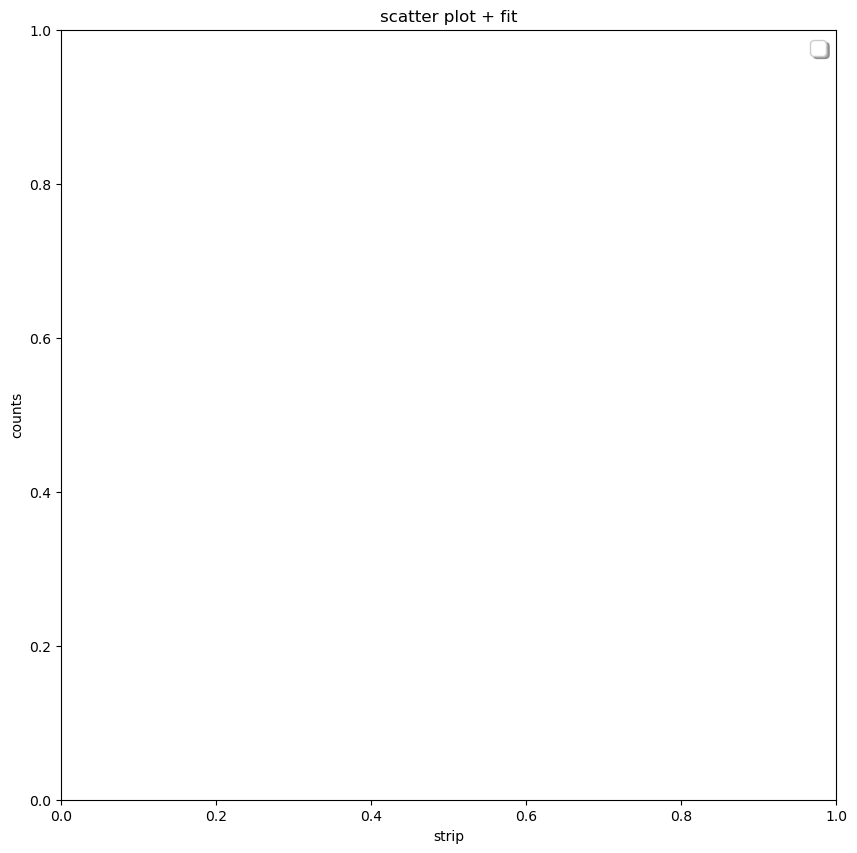

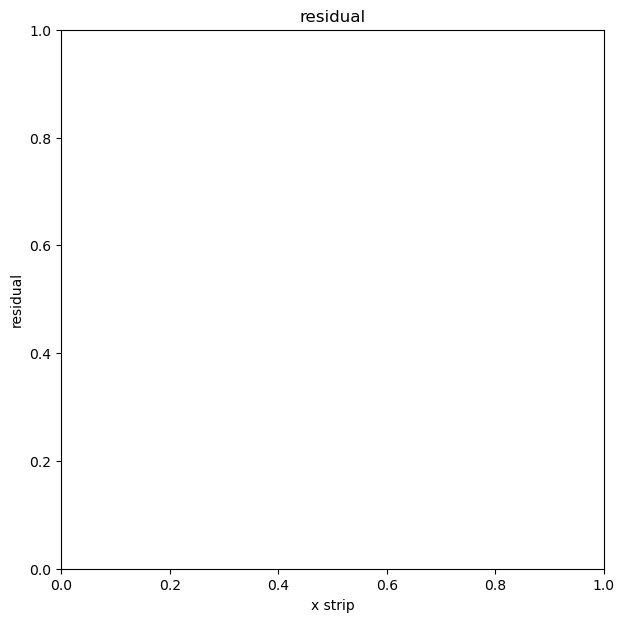

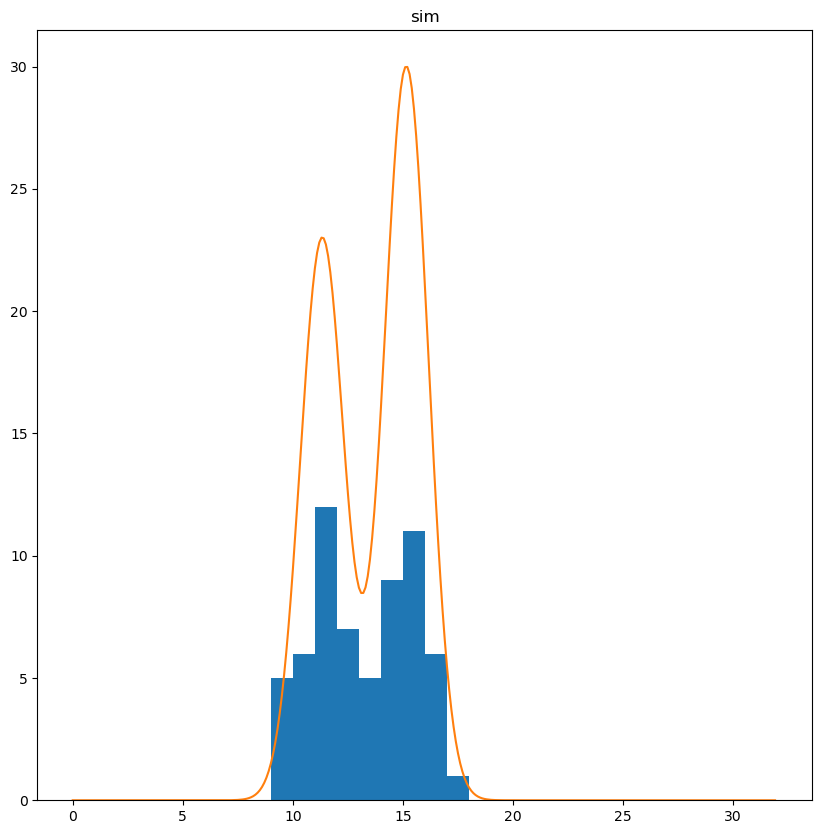

In [9]:
data = pd.read_csv('run231_078_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_078_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

duration = (max(df['t']) - min(df['t']))/60
print (duration)

gates = df[(df['y'] >=8) & (df['y'] < 18) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]








def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,2,11,1.4,16,9,1)

m.limits = [(23,None),(9,13),(1,1.5),(30,None), (13,17), (1,1.5)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_ox= onepeak(bins_,amp_1,cen_1,exp_1)
yy_f= onepeak(bins_,amp_2,cen_2,exp_2)






#print(yy)
plt.figure(figsize = (10,10))
#plt.title("histogram+fit")

#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

#plt.plot(bins_,yy, linewidth=3, color = 'blue')
#plt.plot(bins_,yy, color = 'blue')
#plt.plot(bins_,yy_ox, color= 'blue', linestyle= 'dashed')
#plt.plot(bins_,yy_f,color= 'blue', linestyle= 'dashed')



#plt.axvline(x = 14.44, color = 'r', label = 'Based on f075')
#plt.axvline(x = 11.64, color = 'g', label = 'Predicted based on dispersion, 1x')
#plt.axvline(x = 8.88, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 6.12, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 3.36, color = 'g', label = 'Predicted based on dispersion, 2x')




c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left', color = 'darkorange')
plt.ylabel("Counts")
plt.xlabel("X Strip")
#plt.plot(bins_,yy, linewidth=3, color = 'blue')
#plt.plot(bins_,yy, color = 'blue')
#plt.plot(bins_,yy_oxygen, color= 'blue', linestyle= 'dashed')
#plt.plot(bins_,yy_oh, color= 'blue', linestyle= 'dashed')
#plt.plot(bins_,yy_water,color= 'blue', linestyle= 'dashed')
#plt.plot(bins_,yy_f,color= 'blue', linestyle= 'dashed')
#plt.figure(figsize= (10,10))
plt.figure(figsize = (10,10))
plt.title("scatter plot + fit")
#plt.scatter(newBins_change,newcounts,label='data',color='orange')
#plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


#plt.scatter(newBins_change,yy_,label="fit points", color='green')
#plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
#residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
#plt.scatter(newBins_change,residual_2lorentz)
#plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")

filedur = max(df['t']) - min(df['t'])
counts_F = area_2*sum(counts)
rate = counts_F/filedur
print (rate)








### centered NoF2 is 15.94, astatine file 075, should be 2.74 strips/mass
### 11.48 = 290/1, 15.94-2.74-2.74 = 10.46, No($H_{2}$O)$_{2}$

### f038, 269/1, baseline

File: run231_038_output.txt
3 2020-03-25 20:02:20
[' scaled mpod to 269/1+, no gas in system', ' Q1= 1741 M1=405 M2=608', ' baseline methide count for 4-8 hours depending on if there is anything interes']


/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_38550/2948781305.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_38550/2948781305.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.844 (chi2/ndof = 1.2)    │              Nfcn = 226              │
│ EDM = 1.19e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬────

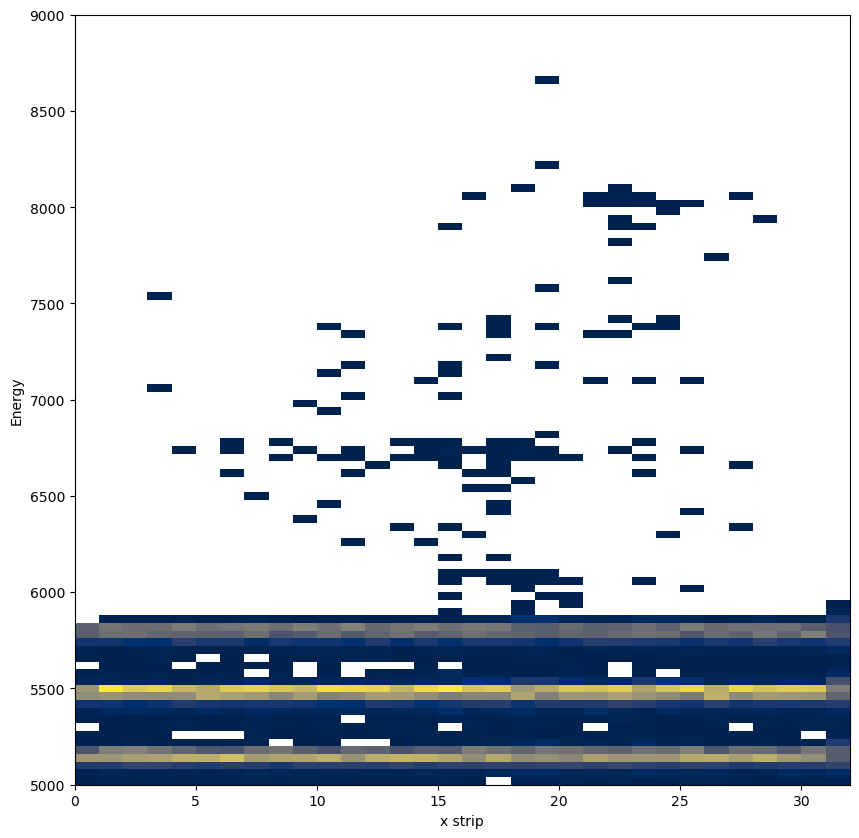

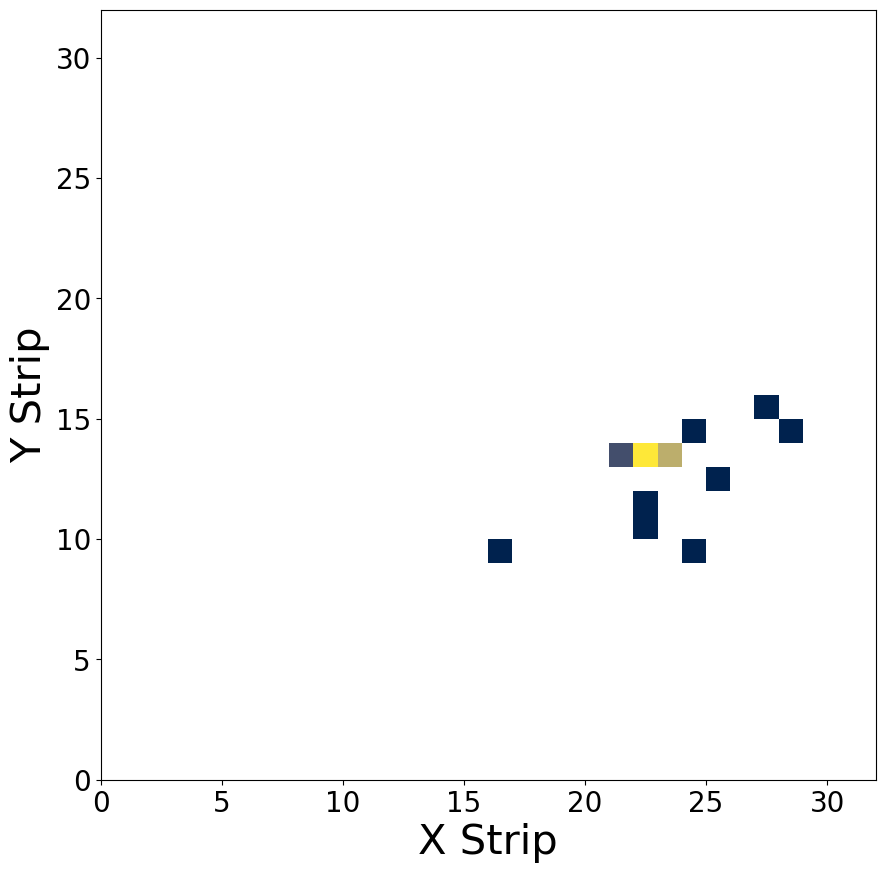

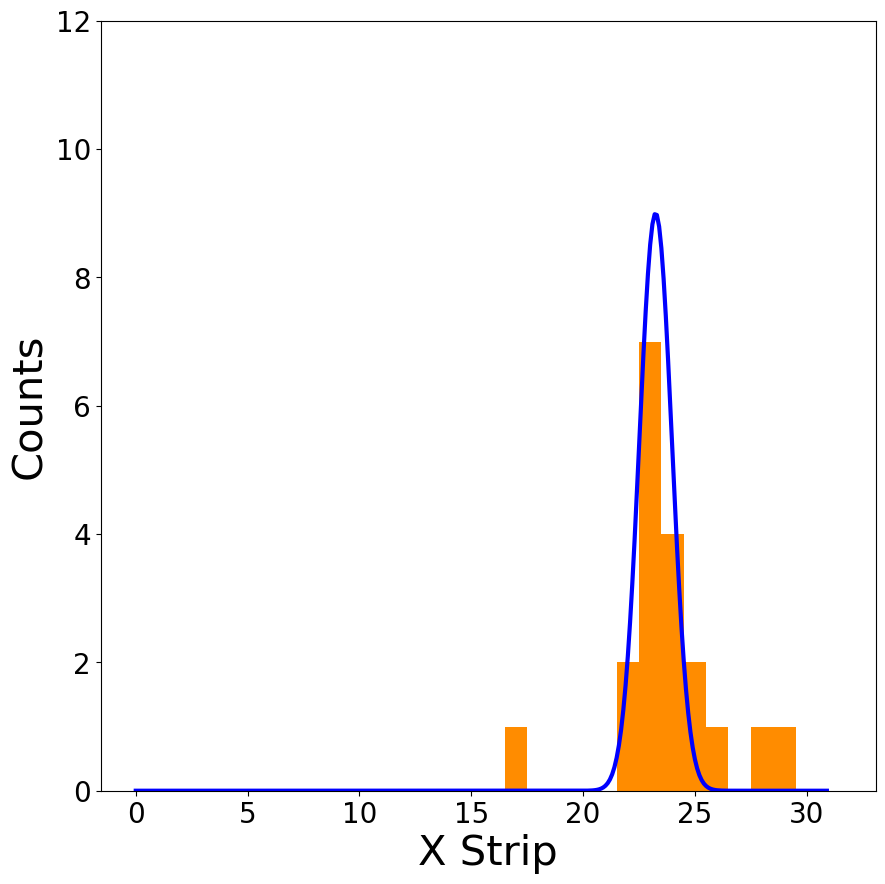

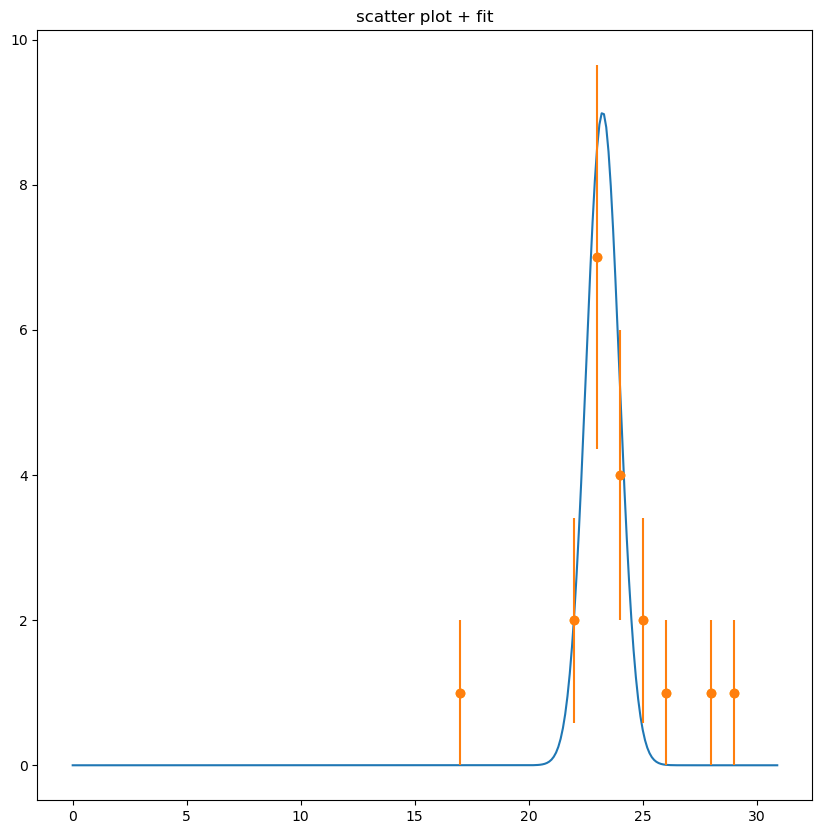

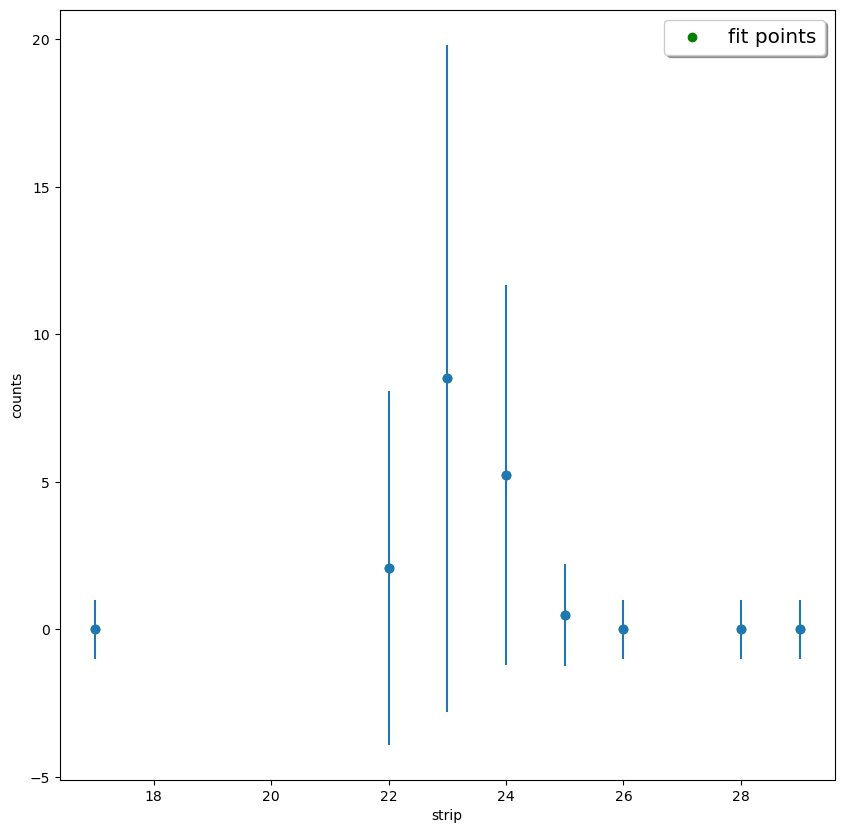

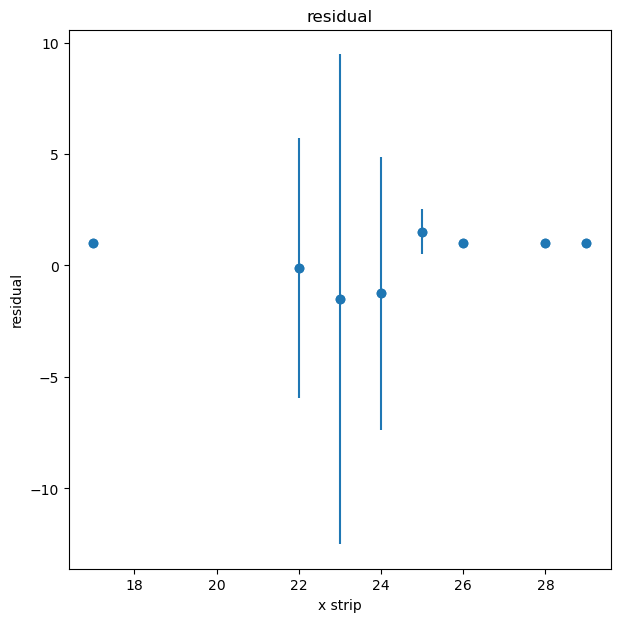

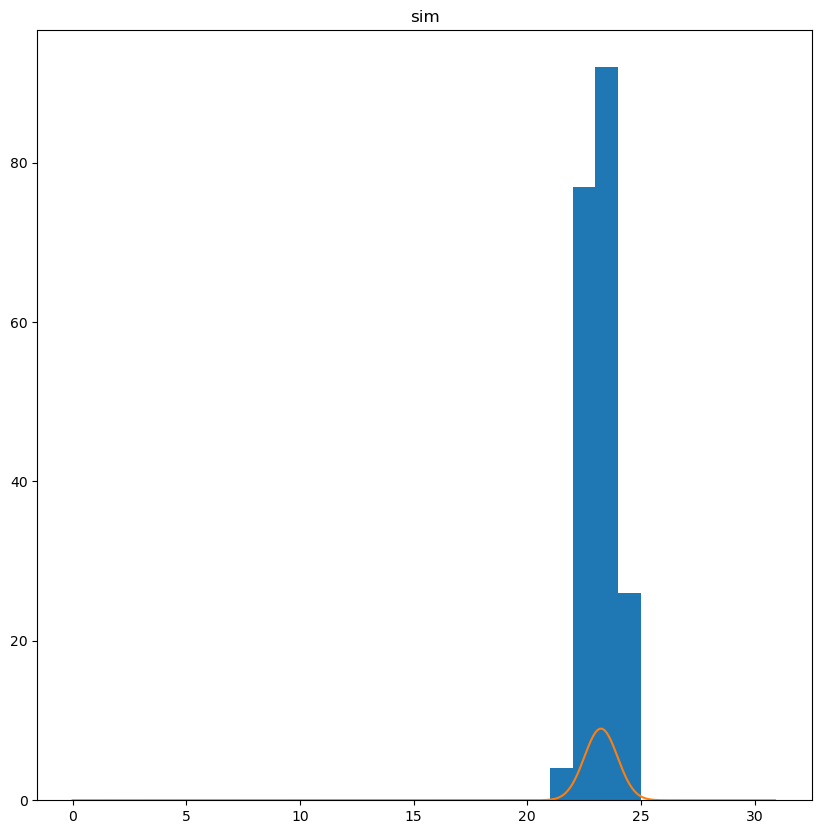

In [6]:
data = pd.read_csv('run231_038_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_038_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

gates = df[(df['y'] >=9) & (df['y'] < 21) & (df['xE'] > 7900) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]

bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)



def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,25,1.4)
m.limits=((9,None), (23,30),(0,None))

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth = 3, color = 'blue')

#plt.axvline(x = 15.39, color = 'r', label = 'Based on f036')
#plt.axvline(x = 18.62, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 21.85, color = 'g', label = 'Predicted based on dispersion, 1x')
#plt.axvline(x = 25.08, color = 'g', label = 'Predicted based on dispersion, 1x')





c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='right', color = 'darkorange')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.ylim(0,12)

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")

plt.figure(figsize= (10,10))


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=reserror, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
#print(area1)
area_1=area1/total


print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,31,range = (0,31), density=False)



_bins = np.arange(0,31,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,31,.1)
plt.plot(bins_,yy)
plt.title("sim")


duration = (max(df['t']) - min(df['t']))/60

print(duration)





### baseline, No(OH), 271/1

### f039, 269/1, NoC$H_{3}$

File: run231_039_output.txt
5 2020-03-26 00:59:01
[' pumped out the gas lines', ' put in 1e-4 mbar l/s of butane', ' mpod still 269/1+', ' See if any NoCH3 1+ ions show up', ' start at 3:17am']
383.52063079666635
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.763 (chi2/ndof = 0.9)    │              Nfcn = 262              │
│ EDM = 0.00015 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_76554/1649989724.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_76554/1649989724.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

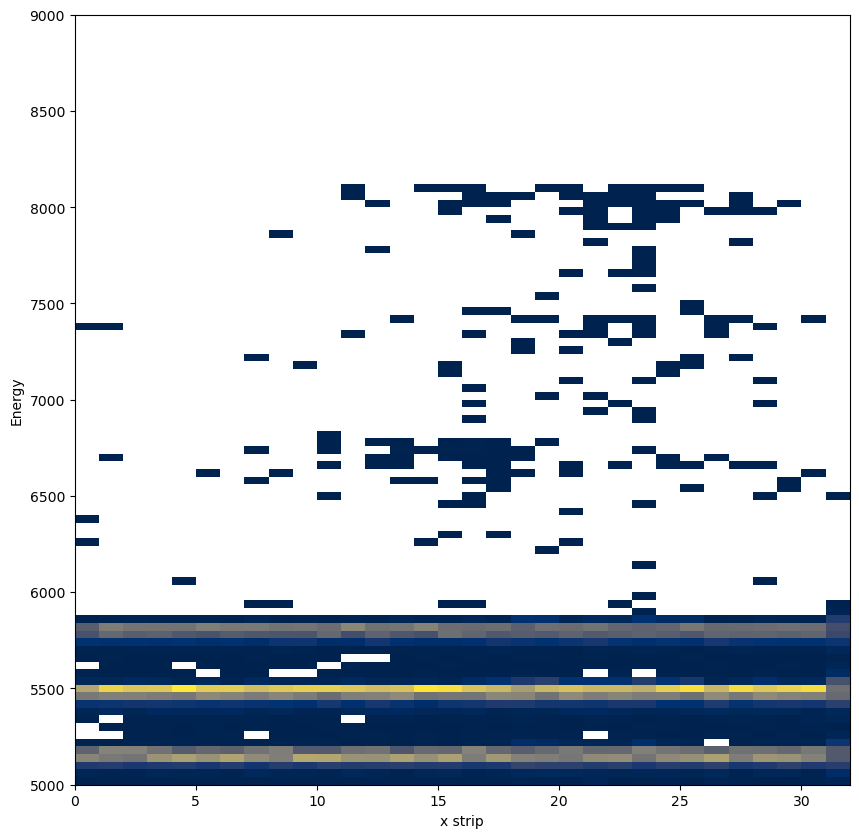

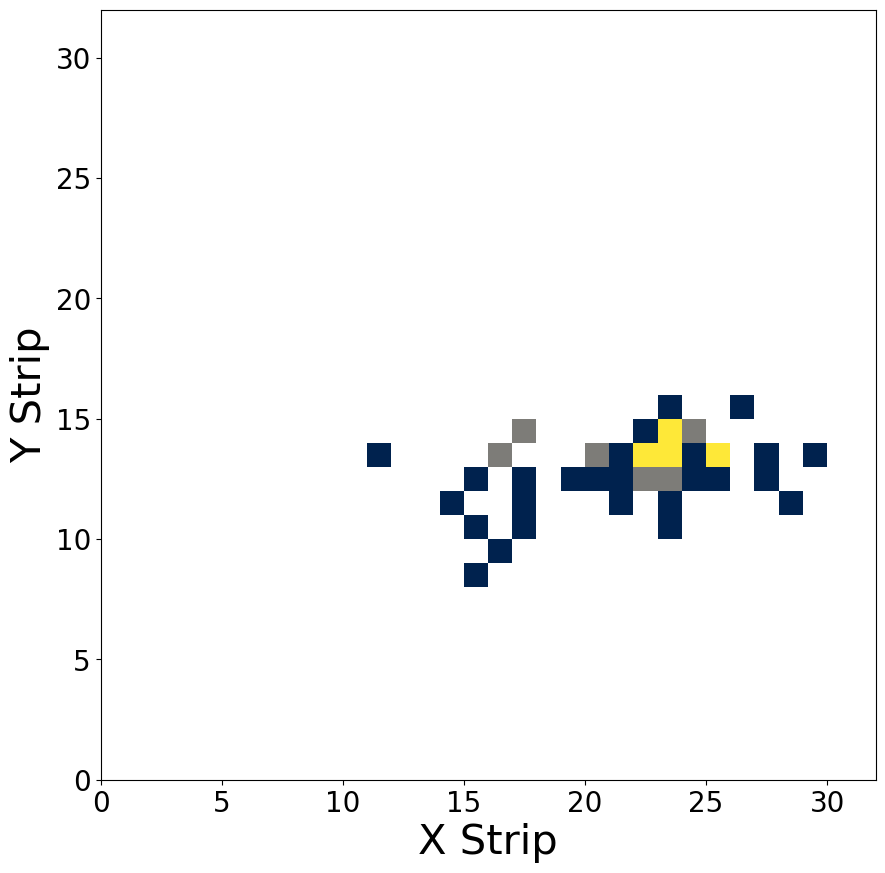

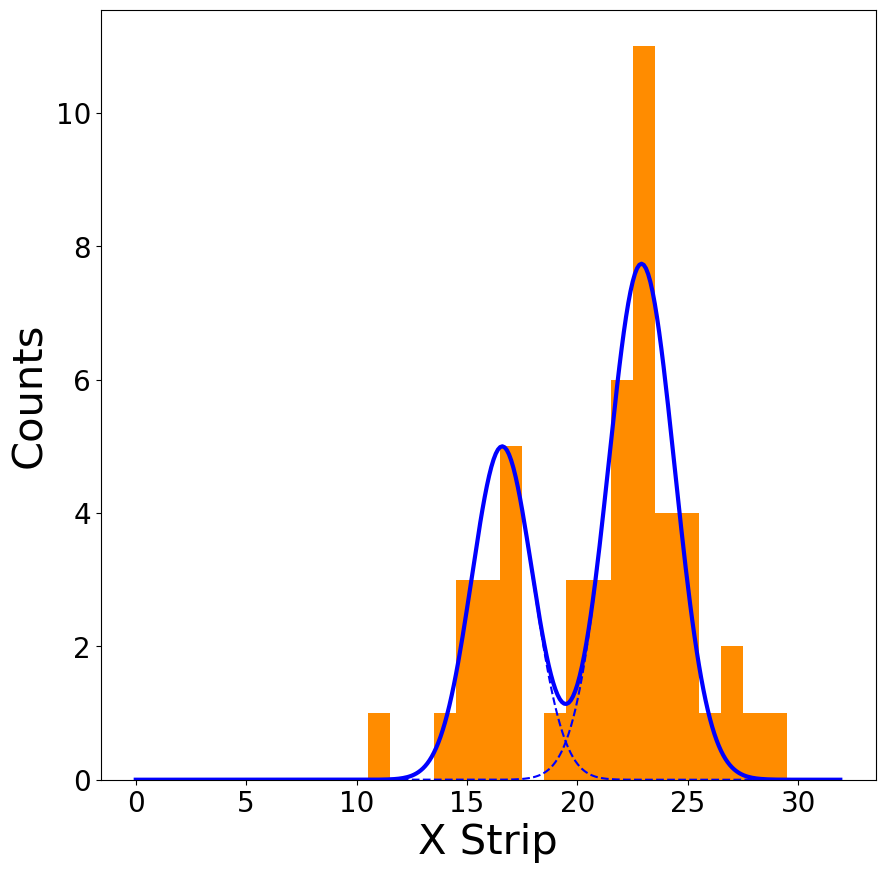

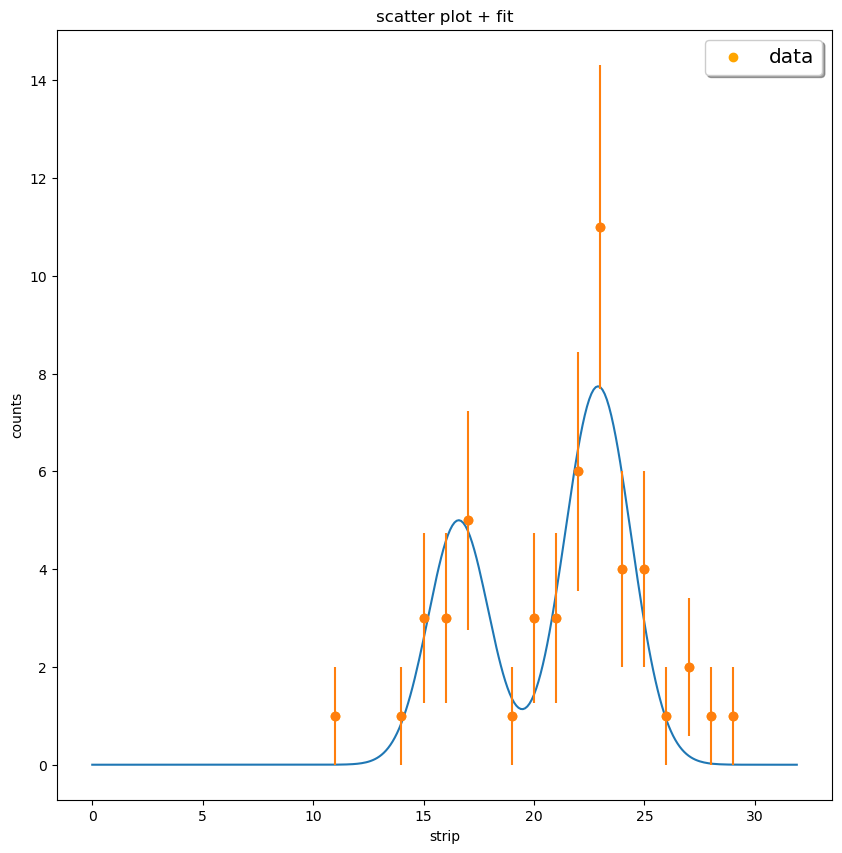

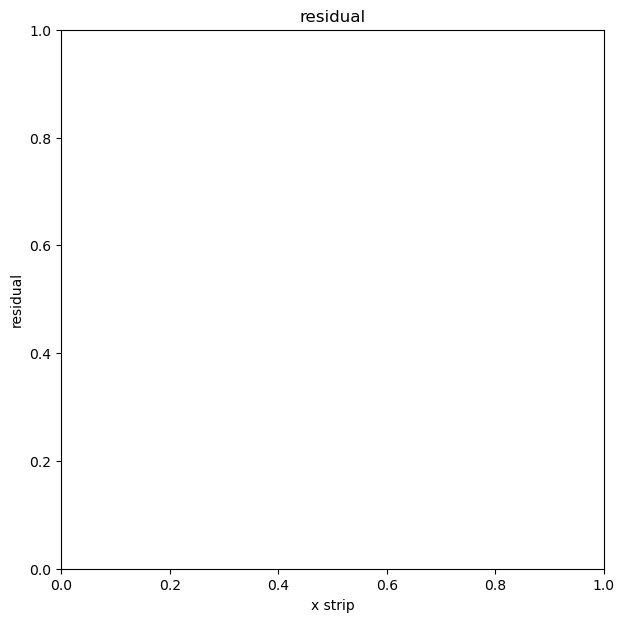

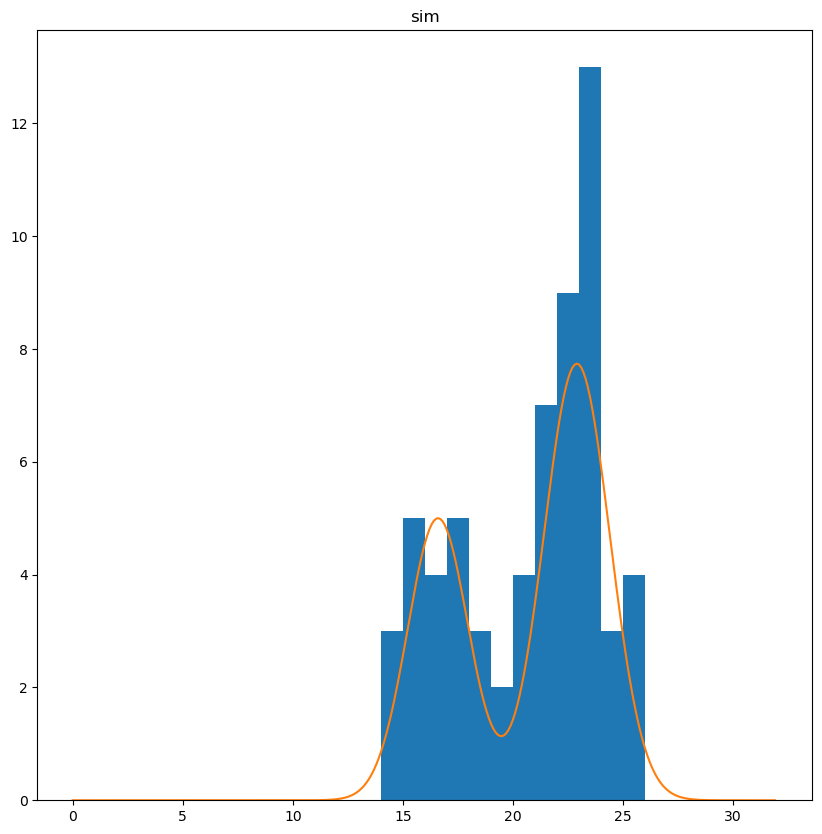

In [23]:
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)

def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start



df, t1 = readDS('run231_039_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
duration = (max(df['t']) - min(df['t']))/60
print (duration)

gates = df[(df['y'] >=8) & (df['y'] < 16) & (df['xE'] > 7900) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))
def onepeak(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) 



ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,16,1.4,530,23,.86)

m.limits = [(5,None),(None,None),(1,None),(None,None), (None,None),(1.5,None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]




yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_methide= onepeak(bins_,amp_1,cen_1,exp_1)
yy_water= onepeak(bins_,amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)




plt.plot(bins_,yy,linewidth=3, color = 'blue')
plt.plot(bins_,yy_methide,linestyle='dashed', color = 'blue')
plt.plot(bins_,yy_water,linestyle='dashed', color = 'blue')


#plt.axvline(x = 15.56, color = 'r', label = 'Based on f036')
#plt.axvline(x = 18.82, color = 'g', label = 'Predicted based on dispersion, 2x')
#plt.axvline(x = 22.05, color = 'g', label = 'Predicted based on dispersion, 1x')
#plt.axvline(x = 25.28, color = 'g', label = 'Predicted based on dispersion, 1x')


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left', color='darkorange')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


#plt.scatter(newBins_change,yy_,label="fit points", color='green')
#plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
#plt.scatter(newBins_change,residual_2lorentz)
#plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")







### centered 16.3, NoCH3, 269/1, using astatine f037, should be 3.23 per mass
### 22.53= 271/1, 16.2+3.23+3.23 = 22.6, No(OH)

### f058, 310/2, No+2 $N_{2}$

File: run231_058_output.txt
3 2020-03-27 04:17:17
[' mpod = 310/2+', ' quick file just to confirm the second spot is 310 and not 309', ' start at 6:35am']
                   name det           t   evt_num   x   y  nX  nY  \
1352  r231f058_4868.lmd  DS  530.628000  33973534  13  28   1   1   
1353  r231f058_4868.lmd  DS  530.831256  33973547  15   9   1   1   
1354  r231f058_4868.lmd  DS  531.277295  33973586  15  28   1   1   
1355  r231f058_4868.lmd  DS  531.281575  33973587  15  12   1   1   
1356  r231f058_4868.lmd  DS  531.671864  33973633  14  13   1   1   

               xE           yE  
1352  5494.296480  5494.117654  
1353  5249.632596  5237.911249  
1354  5125.833996  5109.910652  
1355  8053.940010  8032.278218  
1356  8065.451367  8095.887660  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FC

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/3487622252.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/3487622252.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

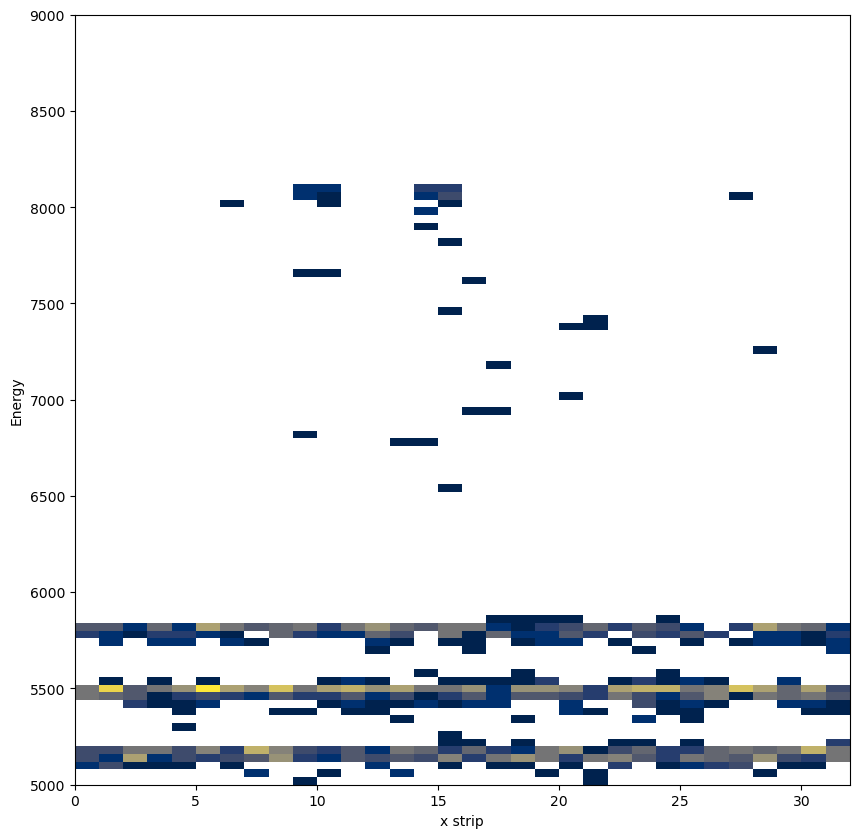

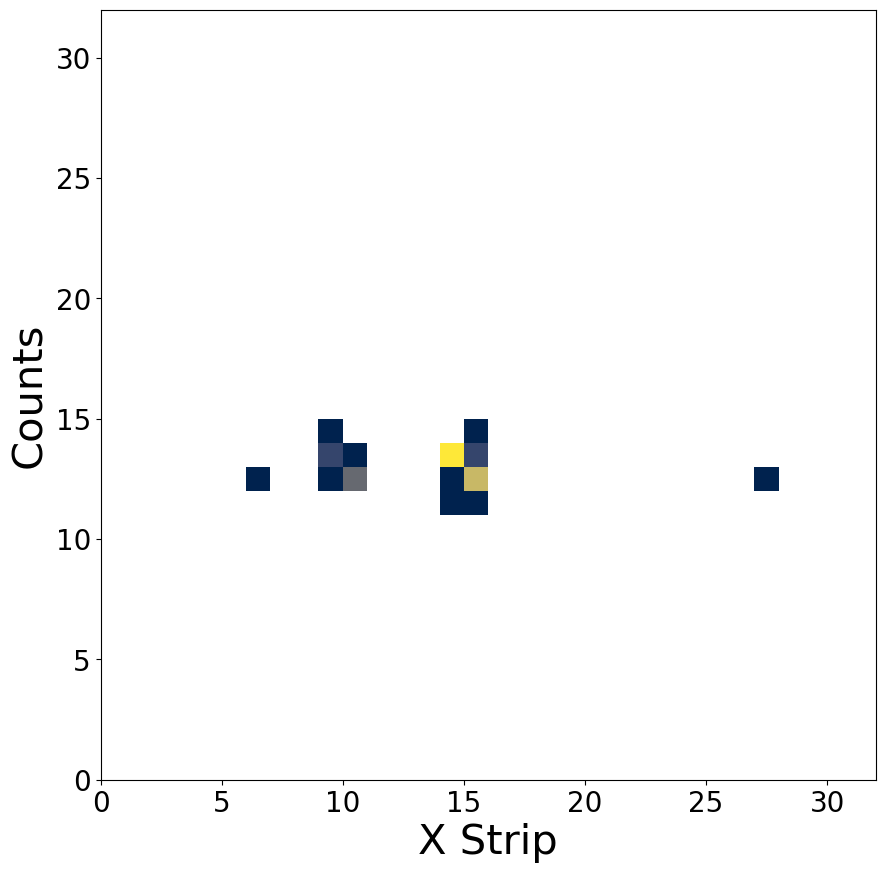

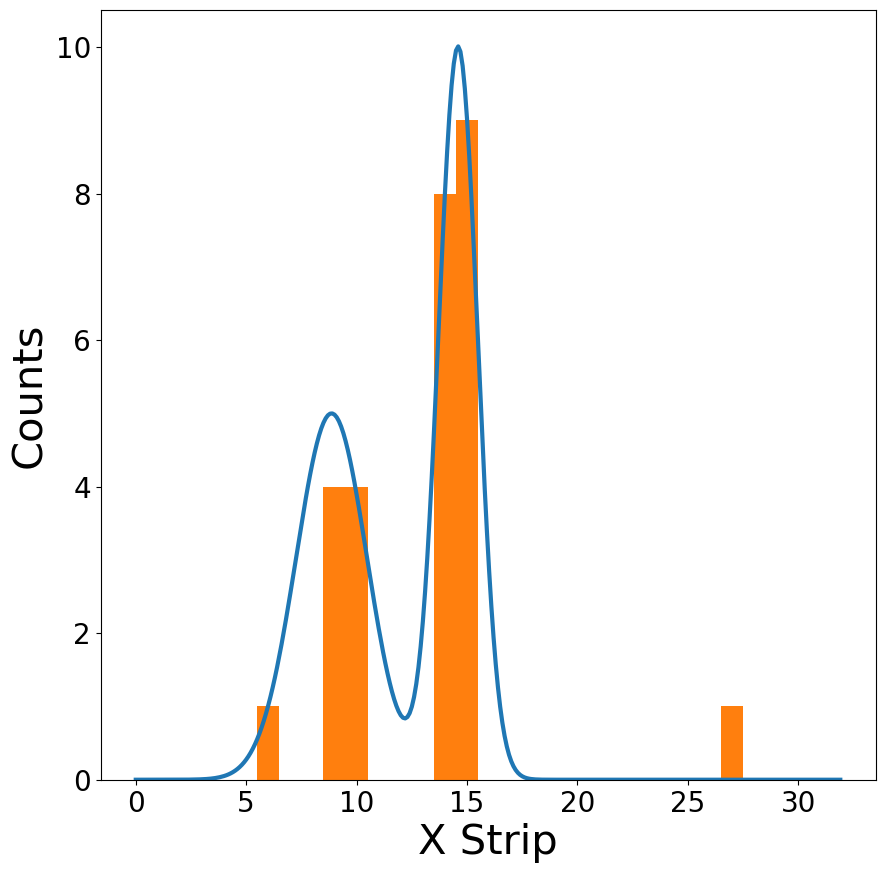

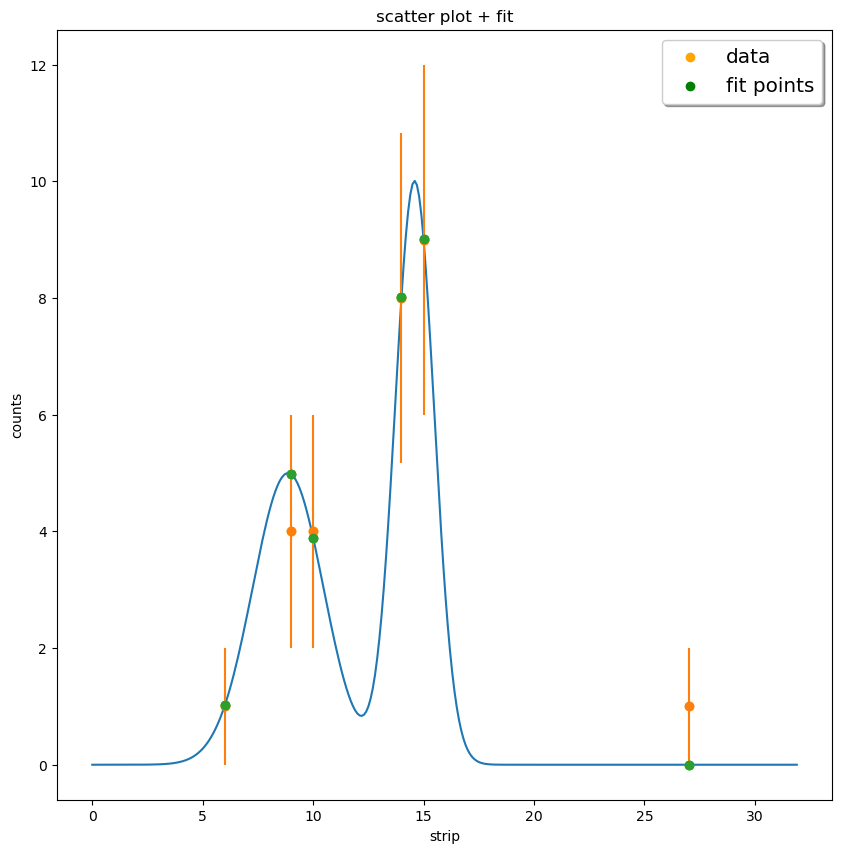

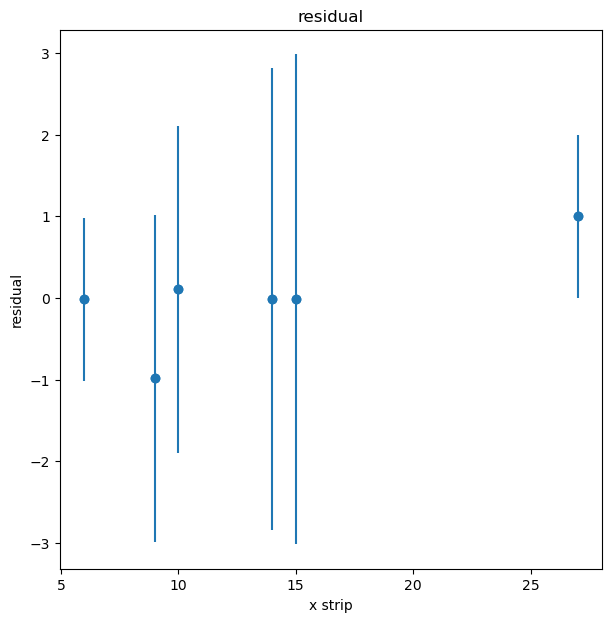

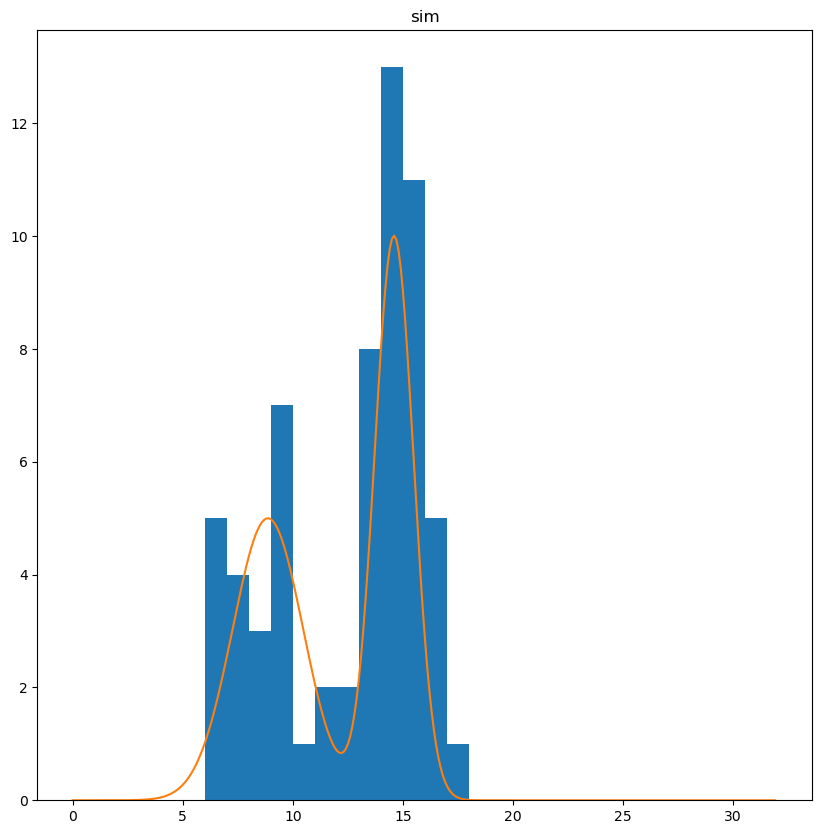

In [58]:
data = pd.read_csv('run231_058_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_058_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,17,1.4,530,23,.86)

m.limits = [(None,5),(8,11),(None,None),(None,10), (12,16),(None,None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth=3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2+area3
#print (total)
print(area2)
area_1=area1/total
area_2=area2/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")









### centered 14.6 based on astatine 55 310/2, should be 2.52 strips per mass, No($N_{2}$$)_{2}$
### 8.9 = 308/2, 14.6-2.52-2.52 = 9.56, No($H_{2}$O$)_{3}$

### f063, a/q = 282/2, No$N_{2}$

File: run231_063_output.txt
3 2020-03-27 09:26:42
[' scaling to 282/2', ' to center a peak from the previous measurement', " and verify it's mas"]
                   name det            t   evt_num   x   y  nX  nY  \
5952  r231f063_4873.lmd  DS  1620.470044  35841663  10   4   1   1   
5953  r231f063_4873.lmd  DS  1621.005299  35841726  14  23   1   1   
5954  r231f063_4873.lmd  DS  1621.425558  35841781   0  15   1   1   
5955  r231f063_4873.lmd  DS  1622.644800  35841897   0  29   1   1   
5957  r231f063_4873.lmd  DS  1623.474552  35841973  28   2   2   1   

               xE           yE  
5952  5823.056440  5814.836544  
5953  5167.537375  5201.312194  
5954  5479.912968  5490.688397  
5955  5124.003626  5012.097731  
5957  5144.196324  5256.622873  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN 

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/2890187869.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/2890187869.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

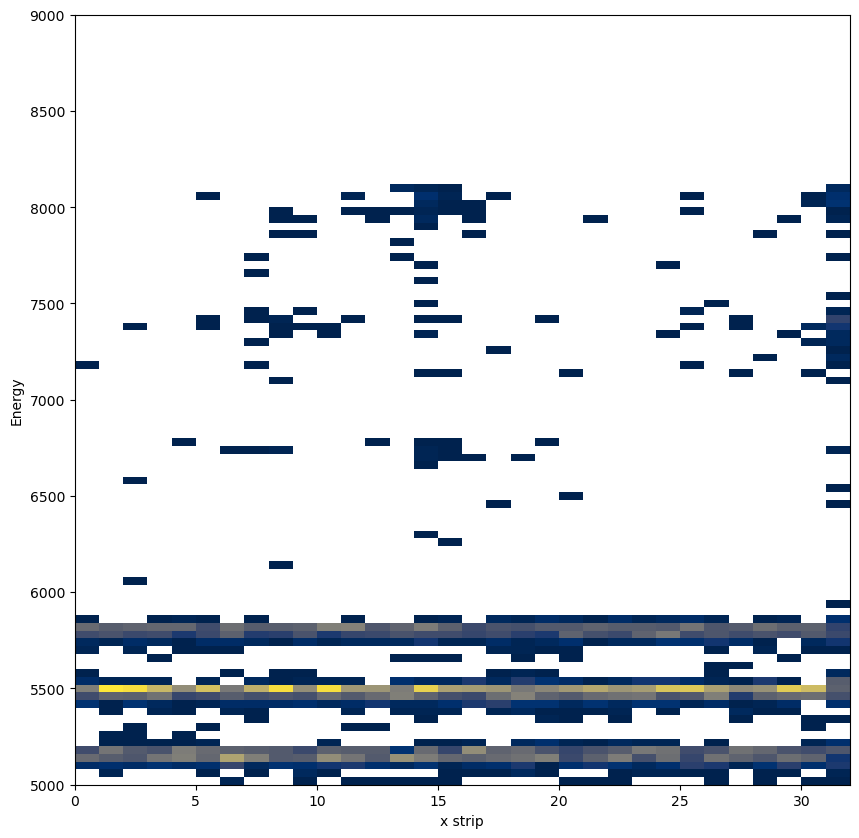

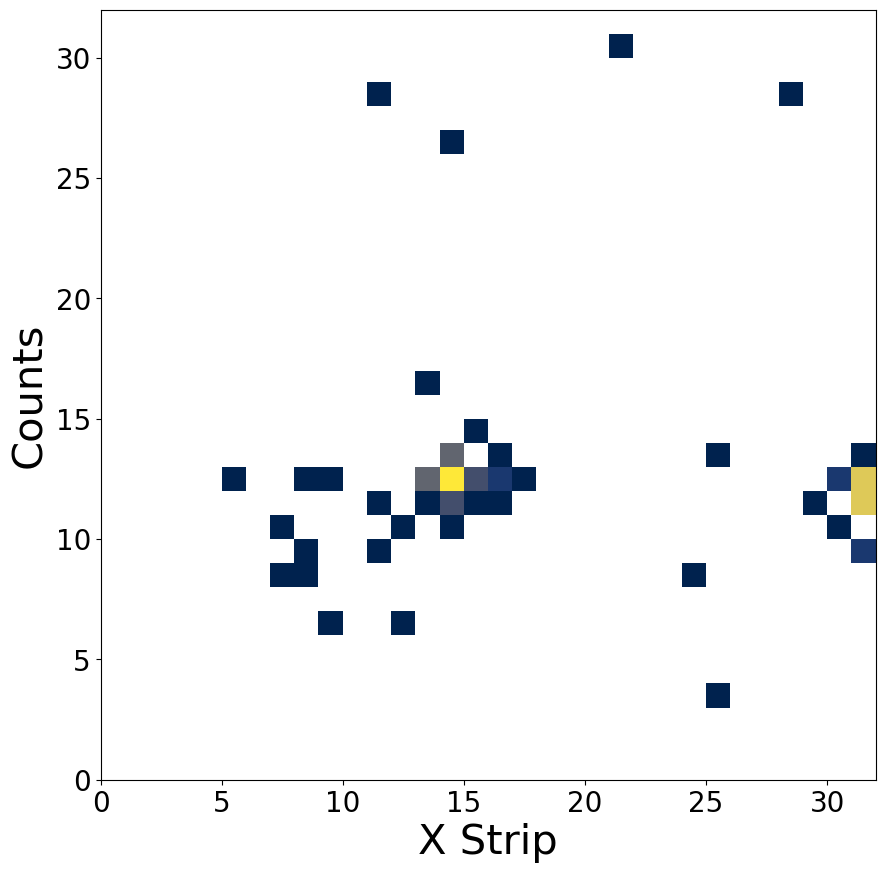

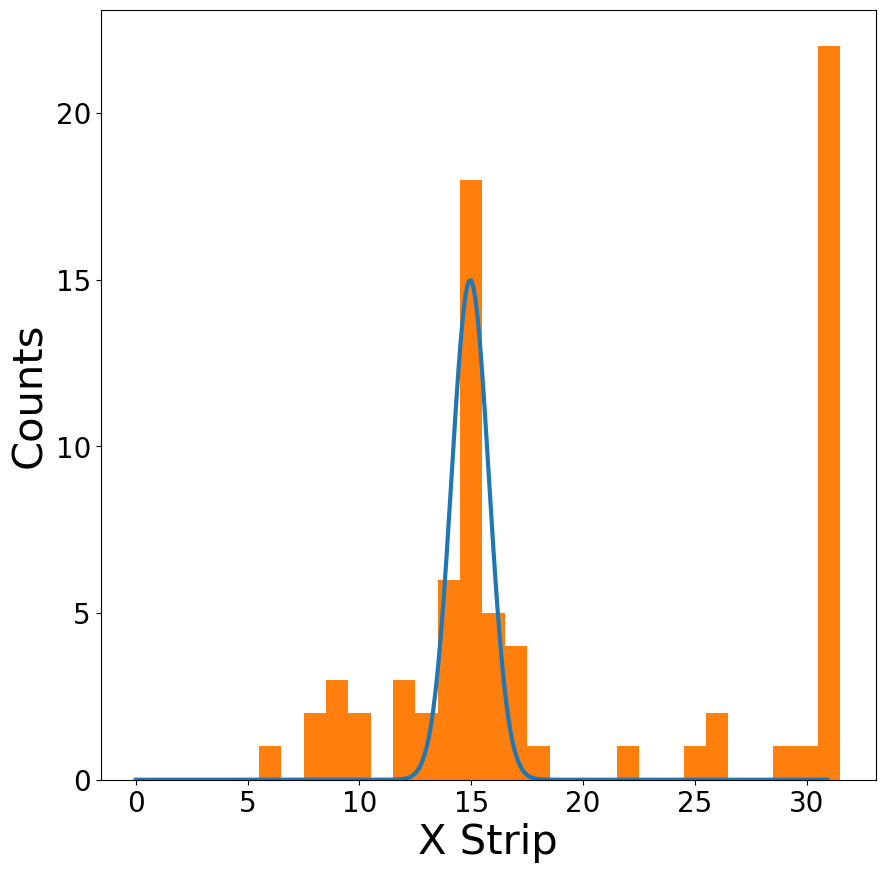

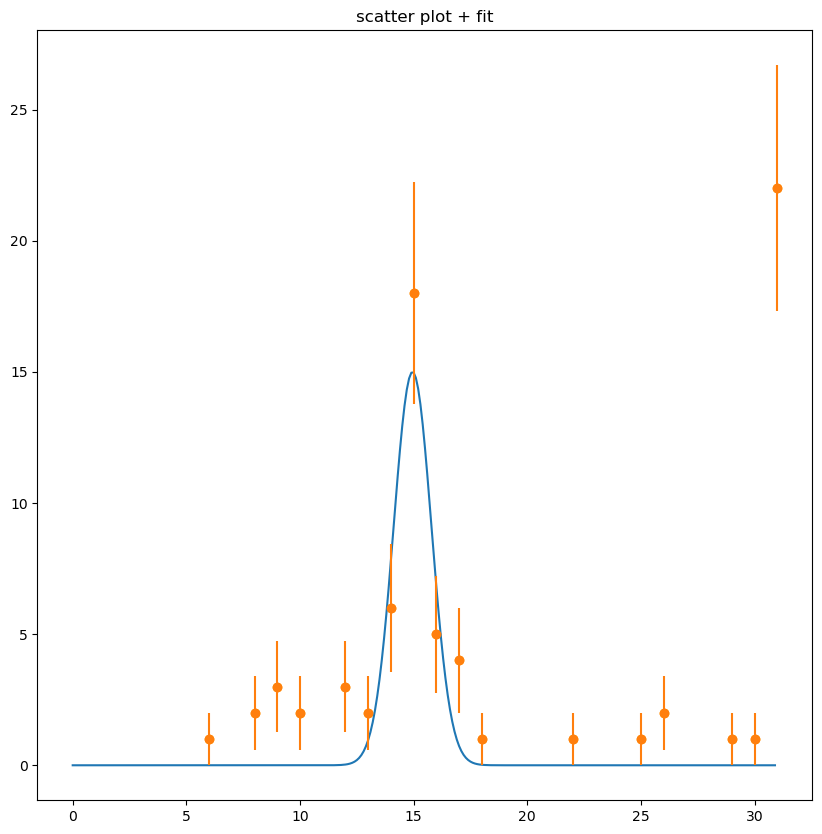

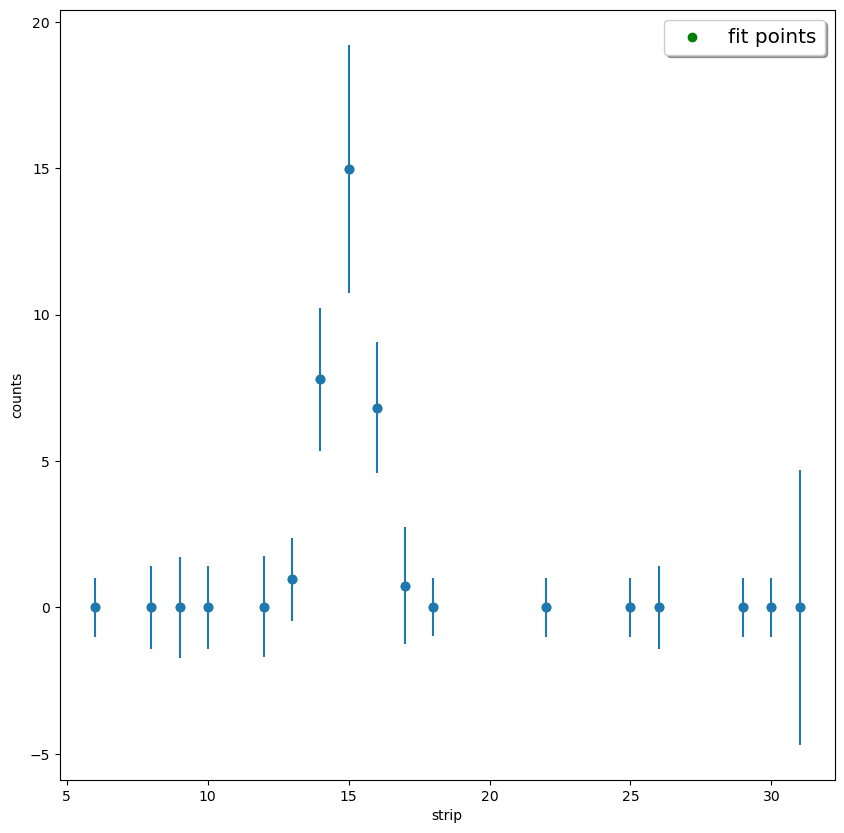

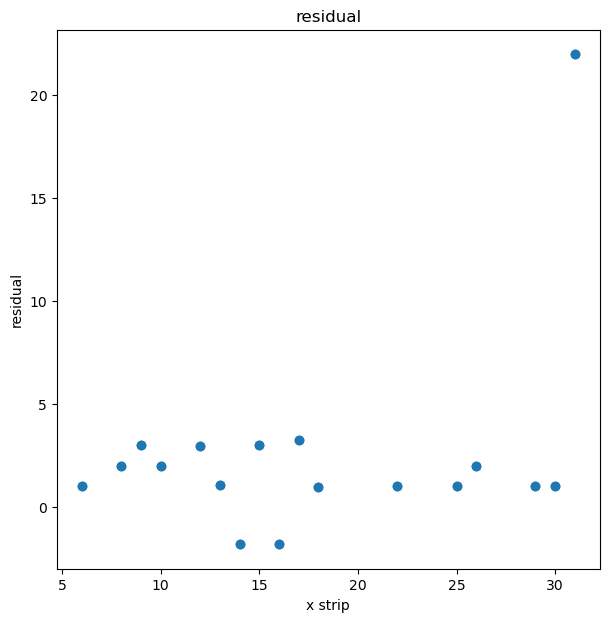

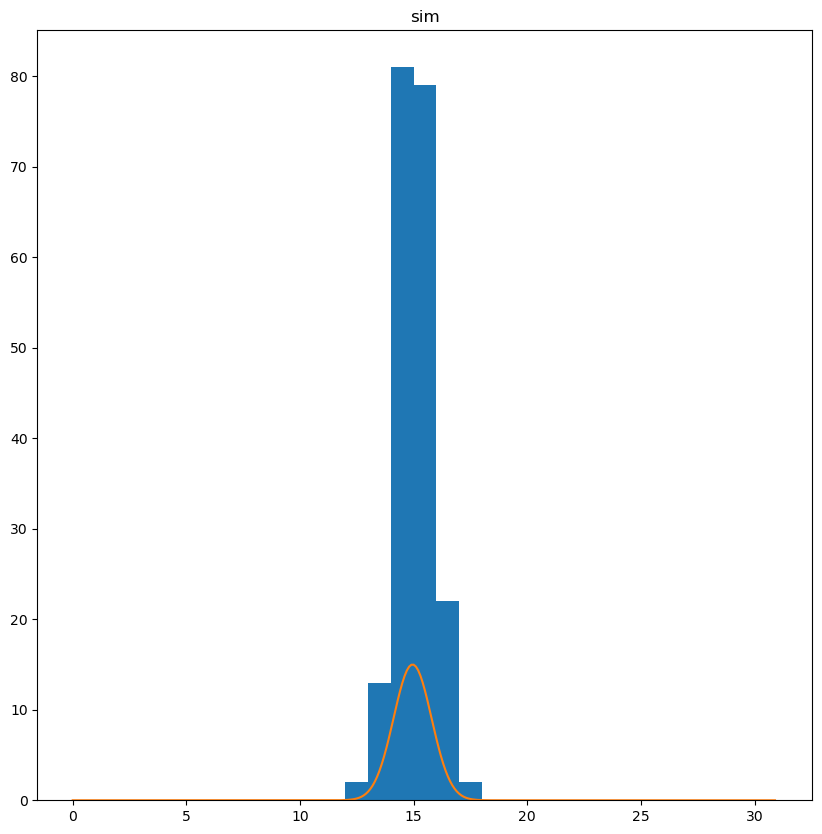

In [57]:
data = pd.read_csv('run231_063_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_063_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7600) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]

bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)



def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,15,1.4)
m.limits=((15,None), (None,None),(0,None))

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth = 3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='right')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")

plt.figure(figsize= (10,10))


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=reserror, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
#print(area1)
area_1=area1/total


print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,31,range = (0,31), density=False)



_bins = np.arange(0,31,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,31,.1)
plt.plot(bins_,yy)
plt.title("sim")







### centered at 15, 282/2, No$N_{2}$

### f060, a/q = 338/2, No($N_{2}$)$_{3}$

File: run231_060_output.txt
4 2020-03-27 05:28:23
[' another intermediate mass check', ' mpod = 338/2+', ' thought I saw something here earlier', ' start at 7:47am']
                    name det            t   evt_num   x   y  nX  nY  \
22828  r231f060_4870.lmd  DS  6320.389224  34932599  12  15   1   1   
22829  r231f060_4870.lmd  DS  6320.504879  34932609  25  16   1   1   
22830  r231f060_4870.lmd  DS  6320.529452  34932614  11   6   1   1   
22831  r231f060_4870.lmd  DS  6320.594622  34932621  19  30   1   1   
22832  r231f060_4870.lmd  DS  6320.705838  34932635   0   5   1   1   

                xE           yE  
22828  5807.859583  5814.946988  
22829  5503.661479  5508.191976  
22830  5795.339647  5800.454927  
22831  1940.368368  1839.823920  
22832  5479.912968  5498.177641  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬───────────────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/2069007375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/2069007375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

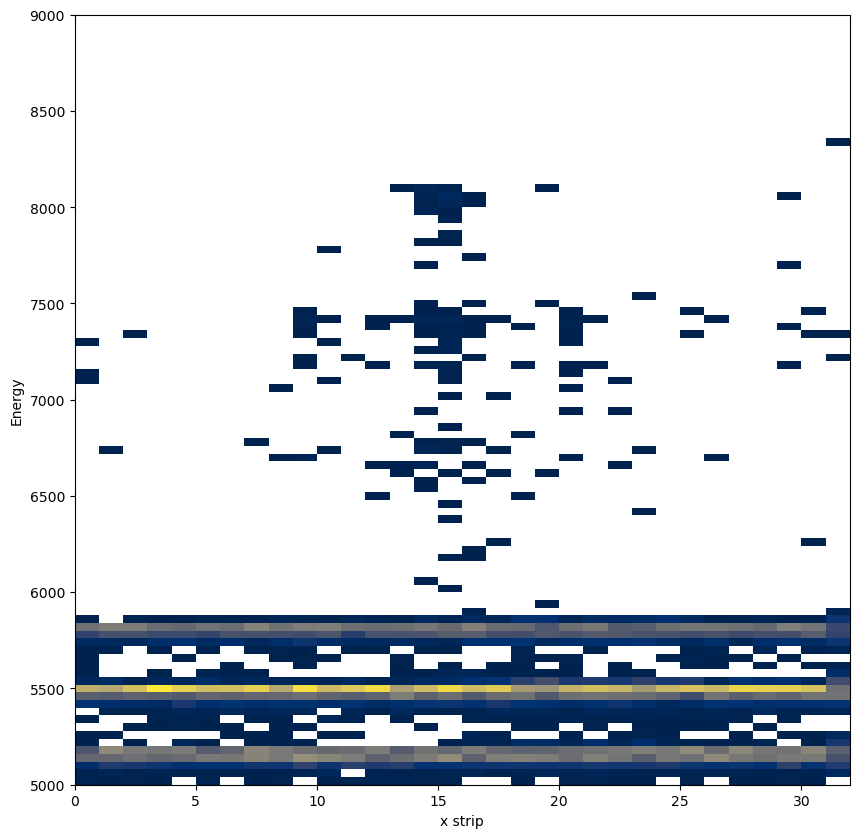

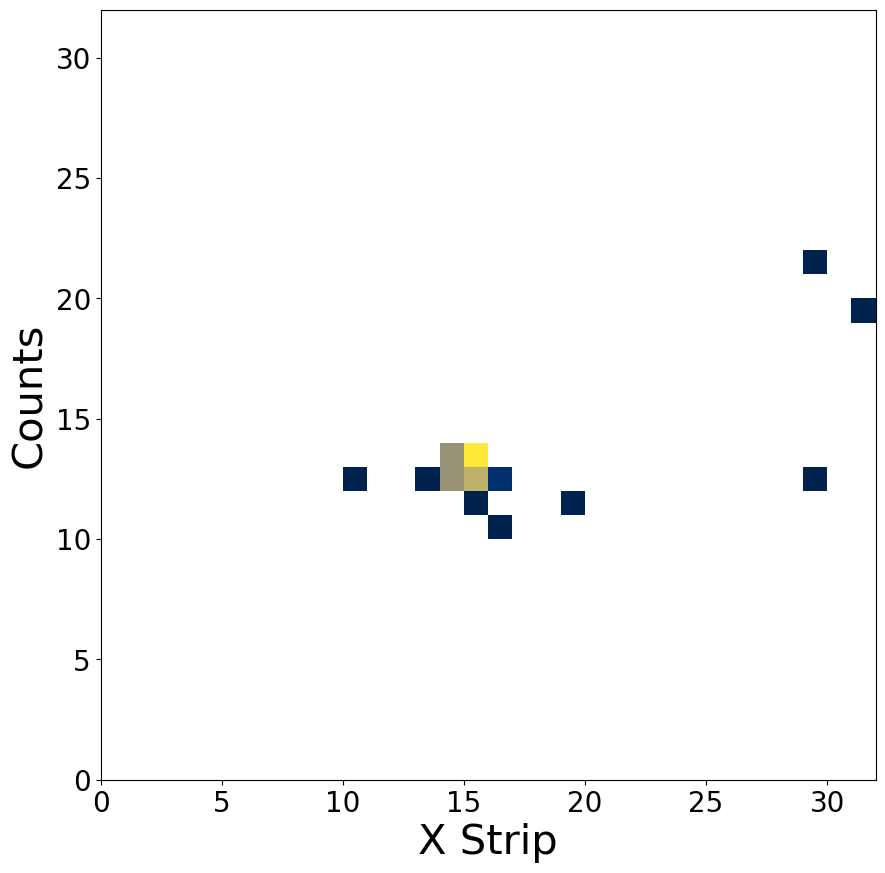

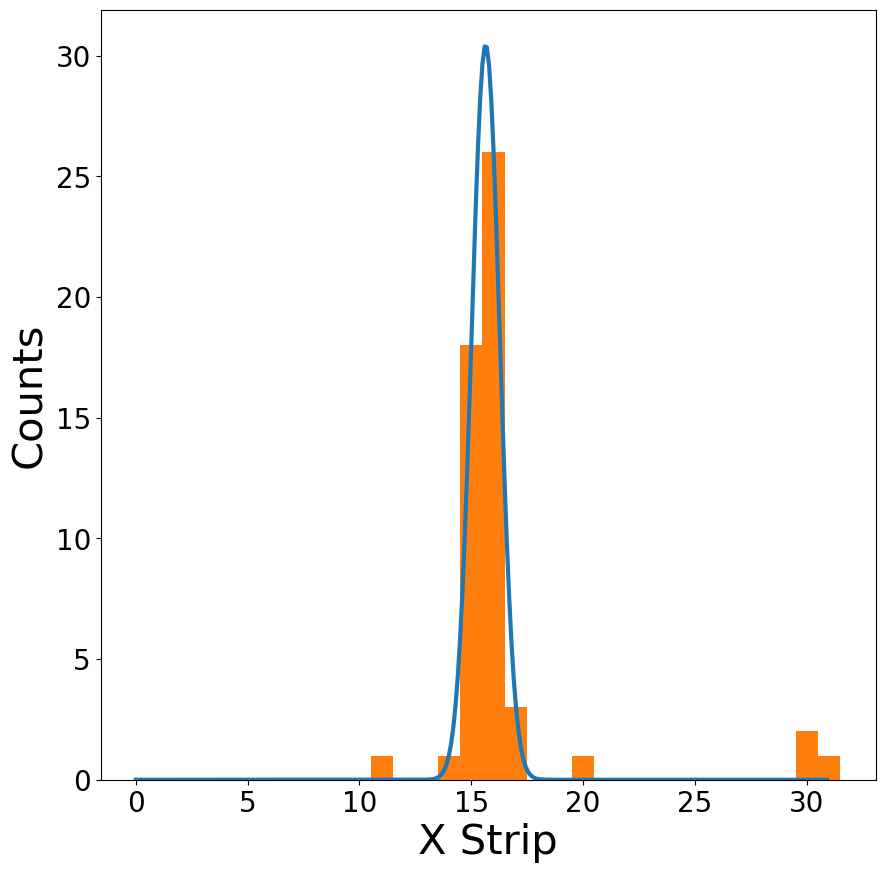

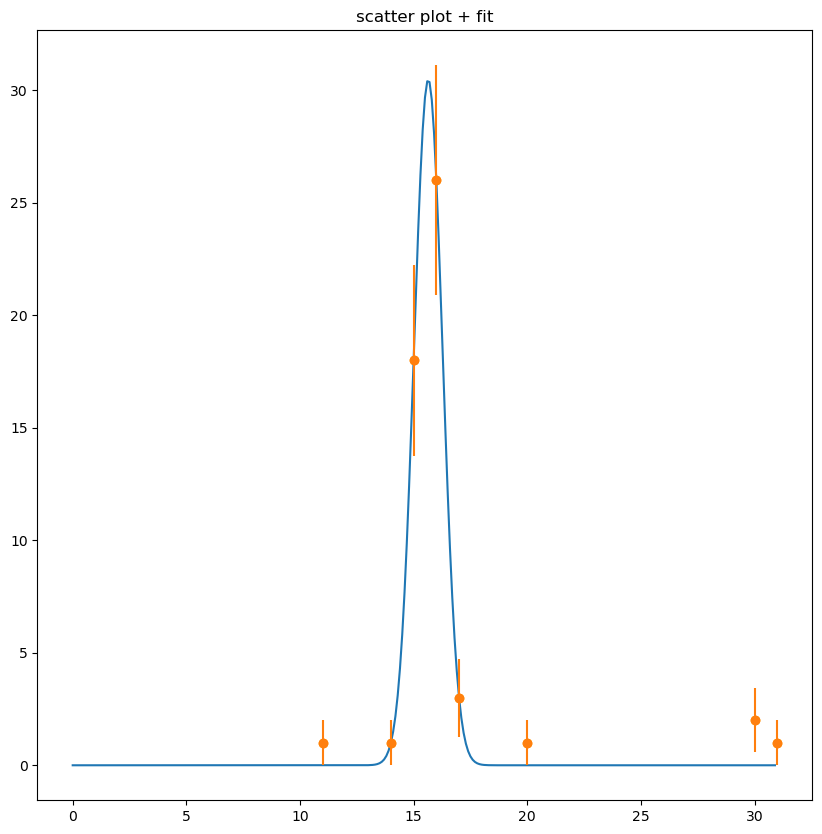

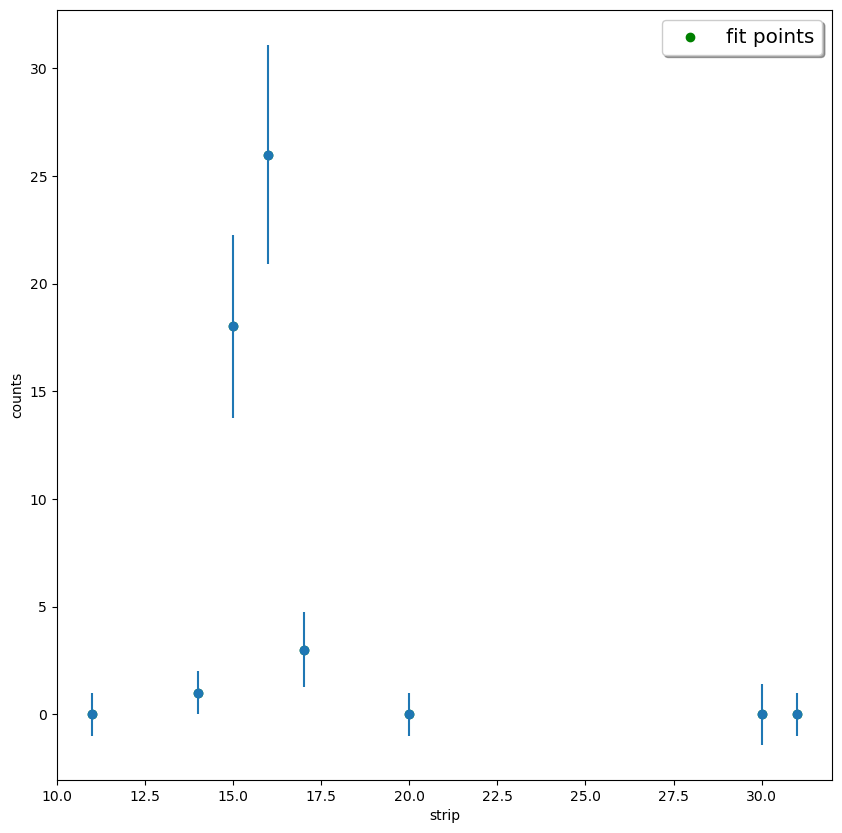

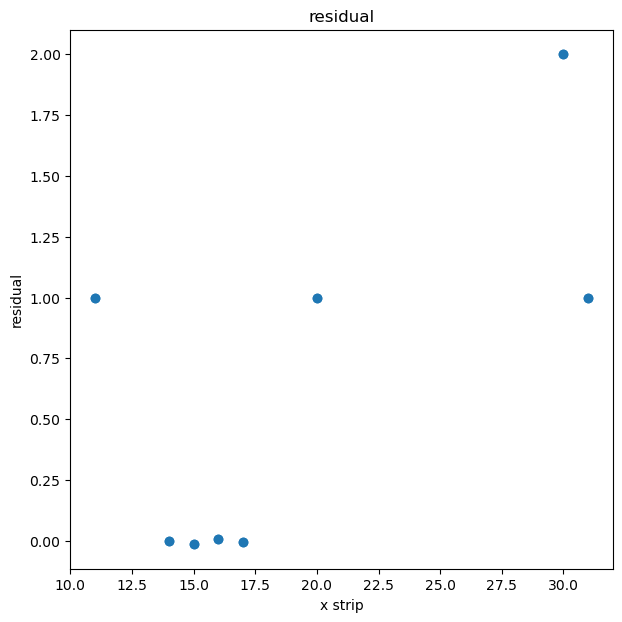

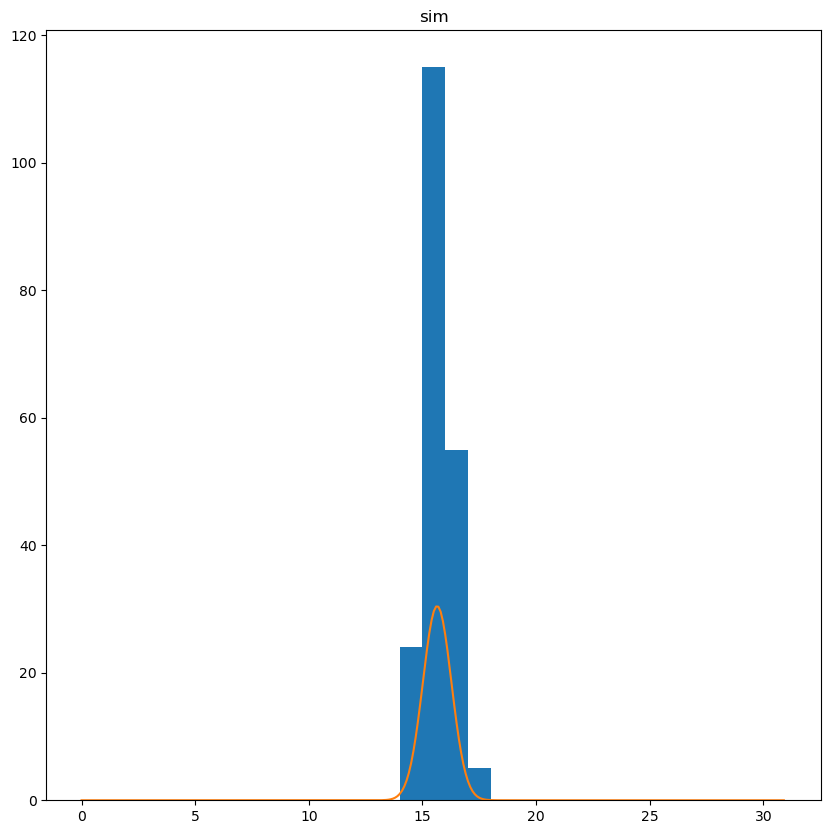

In [59]:
data = pd.read_csv('run231_060_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_060_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7600) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]

bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)



def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,15,1.4)
m.limits=((15,None), (None,None),(0,None))

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth = 3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='right')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")

plt.figure(figsize= (10,10))


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=reserror, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
print(area1)
area_1=area1/total


print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,31,range = (0,31), density=False)



_bins = np.arange(0,31,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,31,.1)
plt.plot(bins_,yy)
plt.title("sim")







### center at 15.65, 338/2, No($N_{2}$)$_{3}$

### f059, , a/q = 300/2

File: run231_059_output.txt
3 2020-03-27 04:34:23
[' mpod = 300/2+', ' checking intermediate masses', ' start at 6:53am']
                   name det            t   evt_num   x   y  nX  nY  \
8069  r231f059_4869.lmd  DS  2177.791482  34235241  17   0   1   1   
8070  r231f059_4869.lmd  DS  2177.840393  34235247  19  25   1   1   
8071  r231f059_4869.lmd  DS  2179.155379  34235397  31   1   1   1   
8072  r231f059_4869.lmd  DS  2179.480810  34235421  18   9   1   1   
8073  r231f059_4869.lmd  DS  2179.500216  34235422   6  22   1   1   

               xE           yE  
8069  5484.186757  5439.016714  
8070  5514.698647  5501.532432  
8071  5487.886065  5501.748588  
8072  5496.787926  5486.826018  
8073  5796.318215  5832.669529  
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.17 (chi2/ndof = 5.4)

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/743968646.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/743968646.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

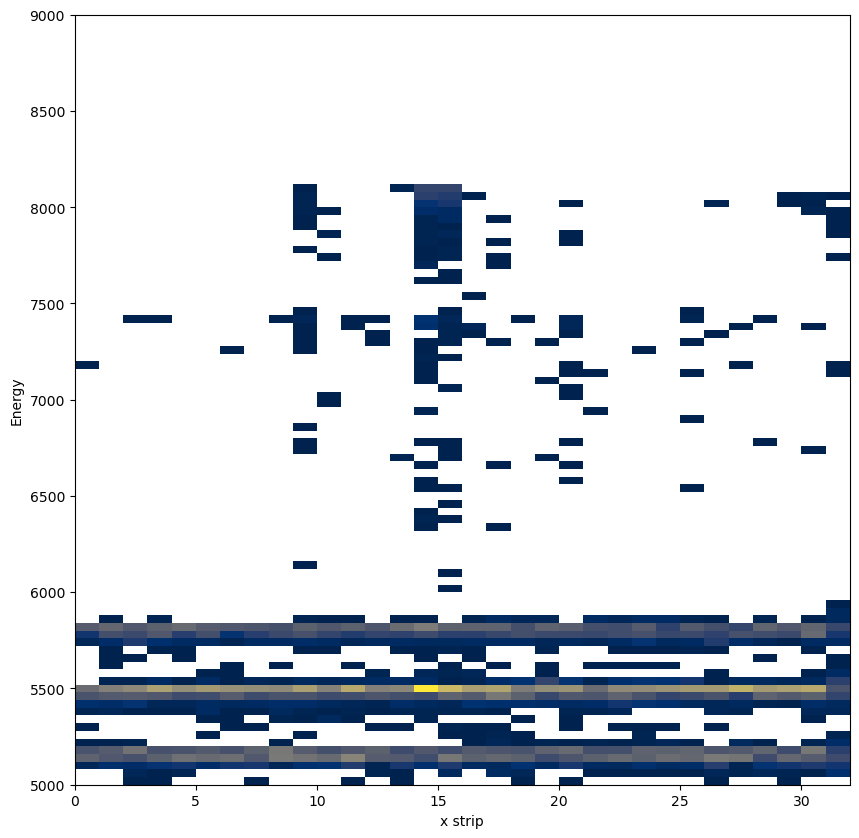

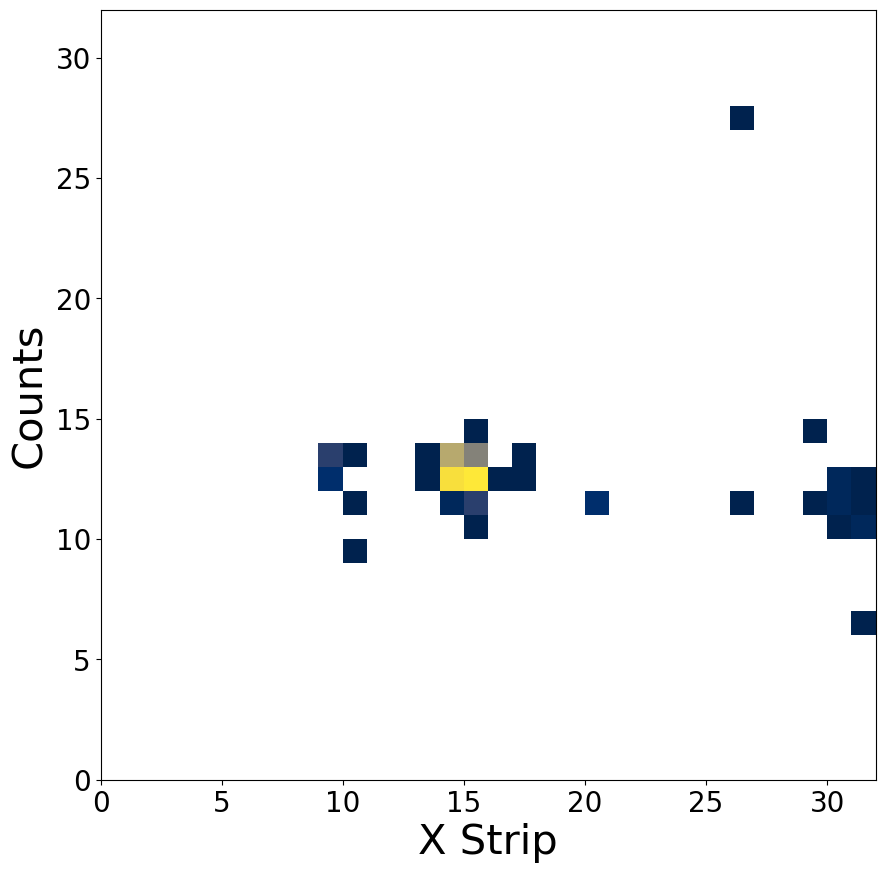

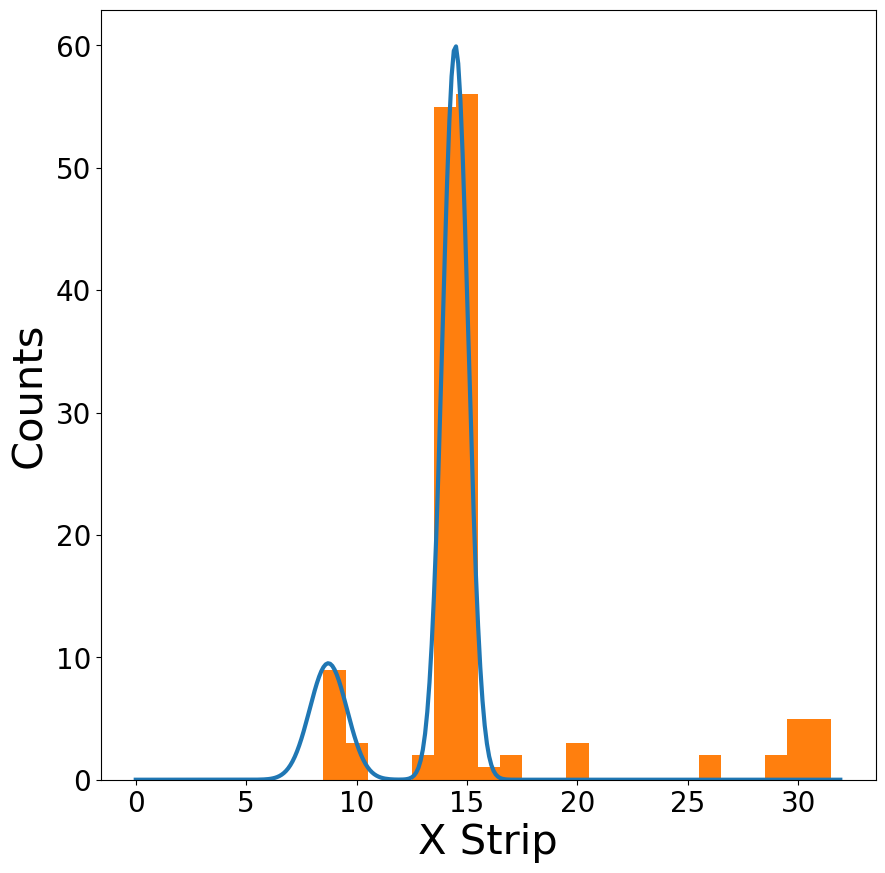

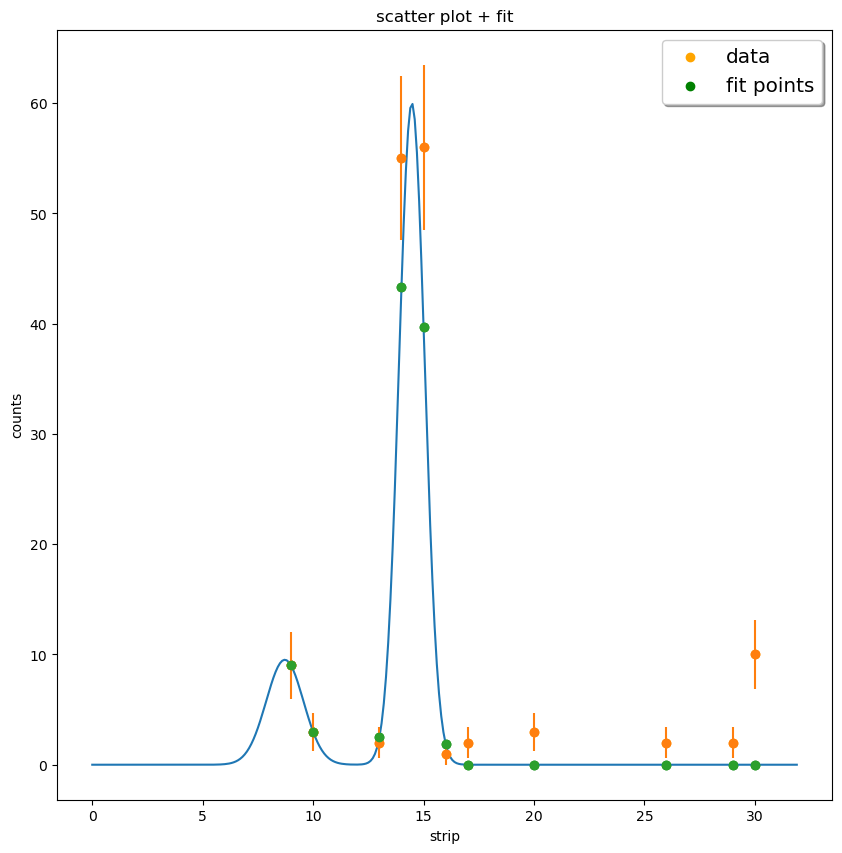

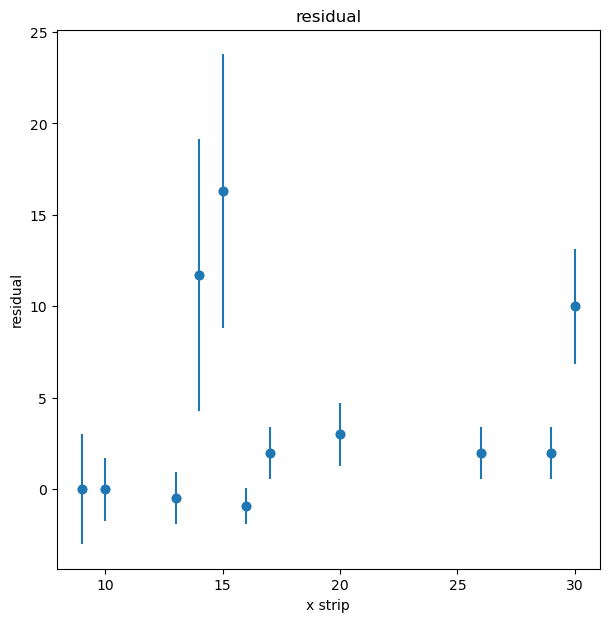

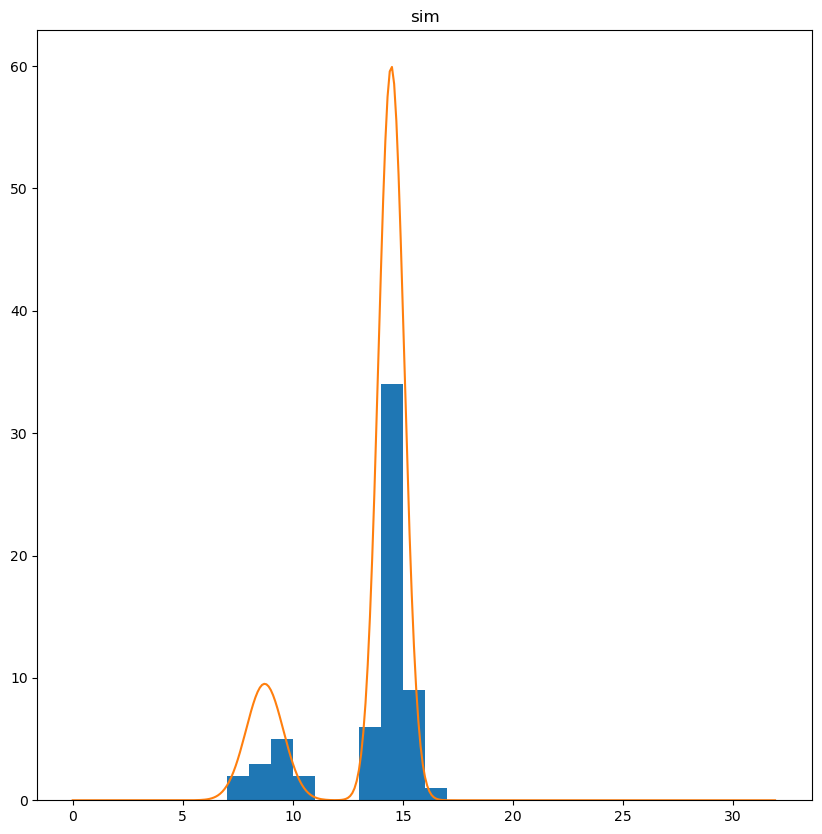

In [62]:
data = pd.read_csv('run231_059_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_059_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7800) & (df['xE']<8400)]
xbins = range(0,32)
newBins = np.delete(bins,0)


bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,17,1.4,530,23,.86)

m.limits = [(None,12),(7,11),(0,None),(50,60), (12,17),(0,None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2)
#print(yy)
plt.figure(figsize = (10,10))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth=3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change+cen_2)/(exp_2))**2))))

print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.ylabel("Counts")
plt.xlabel("X Strip")

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
total= area1+area2+area3
#print (total)
print(area1)
area_1=area1/total
area_2=area2/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1,cen_2]
sigma = [exp_1,exp_2]
area = [area_1,area_2]
n = 62
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")









### 14.47 = centered,astatine file 55 should be 2.60 strips per mass, 300/2, No$H_{2}$0$N_{2}$
### 8.7= 14.47-2.6-2.6 = 298/2, No$N_{2}$O

## -------------------------------------------------

## Now actinium 

### f103, actinium bare spectra
### 212, 7.379 MeV
### 211, 7.477 MeV, 
### 213, 7.36 MeV

### daughers are in 6.9-7.137 range

look at before and after
actually pinpoint energies, not eyeball 

File: run231_103_output.txt
4 2020-03-29 00:35:23
[' with the decent resolution settings', ' scale to 212/2+', ' count on DS', ' see what shows up']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 56.71 (chi2/ndof = 3.3)    │             Nfcn = 2105              │
│ EDM = 0.000187 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└──────────────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1274549206.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1274549206.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

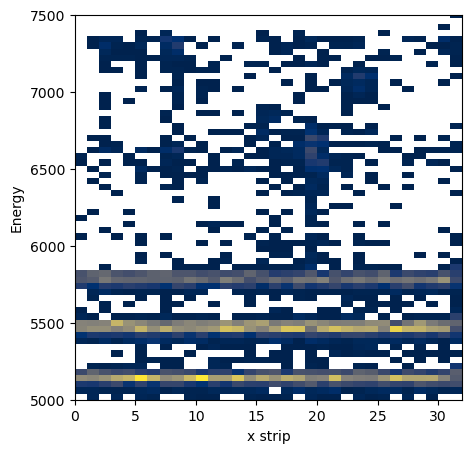

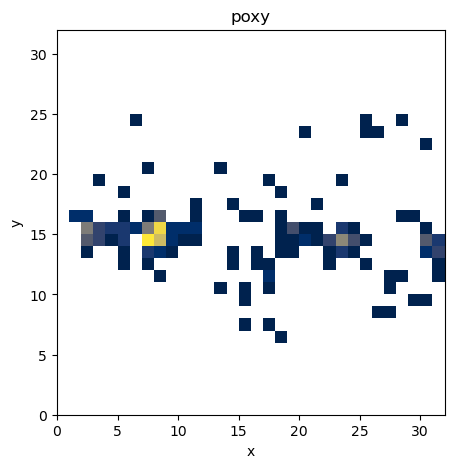

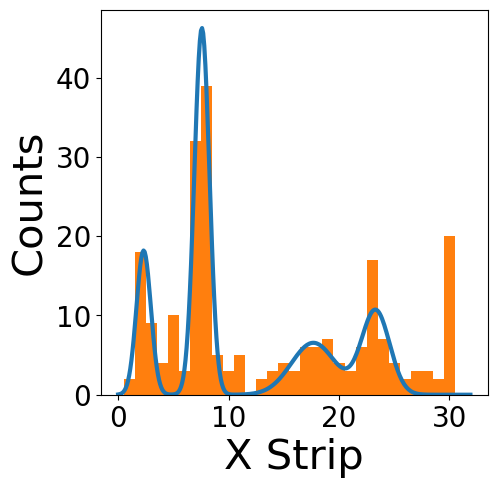

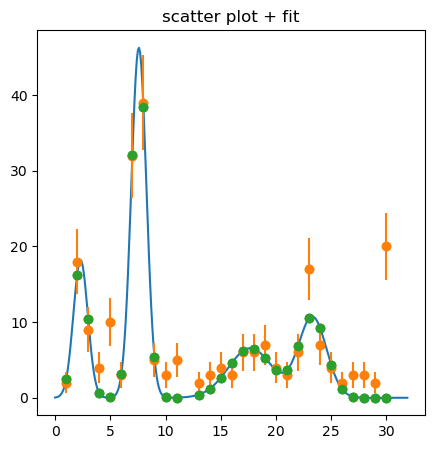

In [33]:
data = pd.read_csv('run231_103_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_103_output.txt', cal)
plt.figure(figsize = (5,5))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
plt.ylim(5000,7500)


gates = df[(df['y'] >=6) & (df['y'] < 25) & (df['xE'] > 7100) & (df['xE']<7500)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (5,5))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,12,1.4,530,16,.86,310,21,1,30,24,1.2)

m.limits = [(0,60),(0,8),(0,2),(10,None), (5,10), (0,2), (None,None ), (16,20), (0, 2),(0,None),(20,25),(0, 2)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (5,5))
#plt.title("histogram+fit")


plt.plot(bins_,yy, linewidth =3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)


plt.figure(figsize= (5,5))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (5,5))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 228
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")





### redoing Po to see where we are centered at

File: run231_105_output.txt
5 2020-03-29 02:00:32
[' confused about the masses I see', ' put beam on beam stop', ' scale mpod to 216/1+', ' put in Po source just for a minute or so', ' start at 4:19am']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.05 (chi2/ndof = 1.7)    │              Nfcn = 147              │
│ EDM = 2.18e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ 

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1877968369.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_62978/1877968369.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

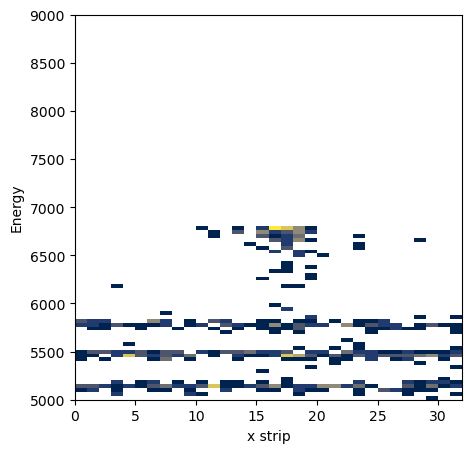

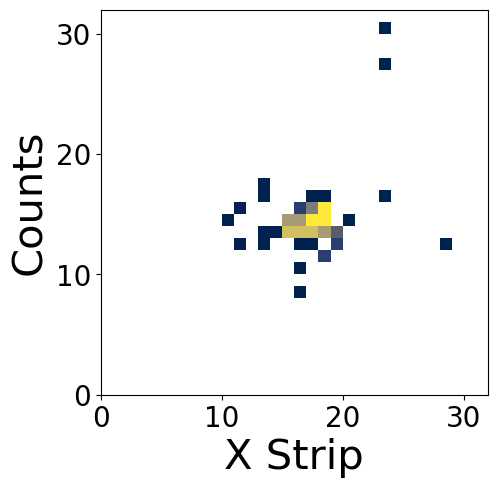

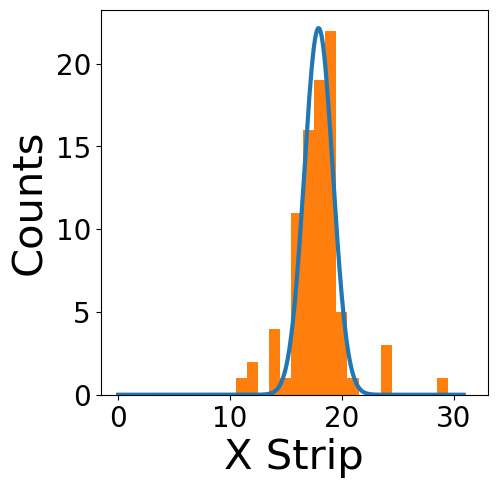

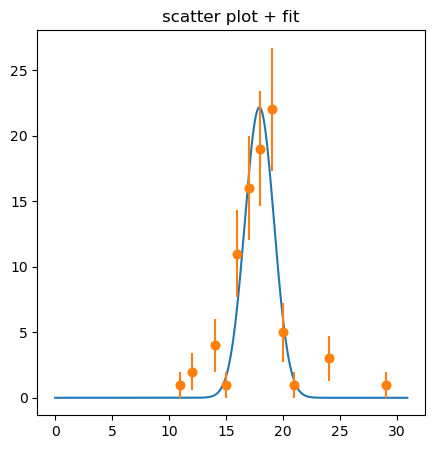

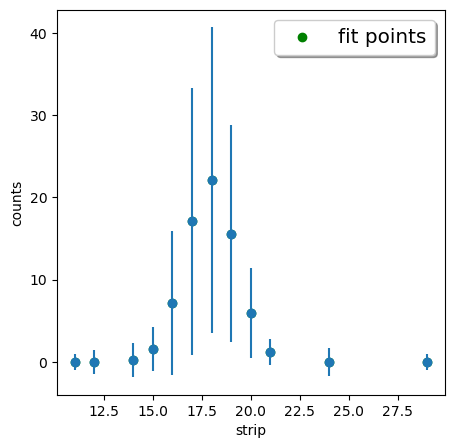

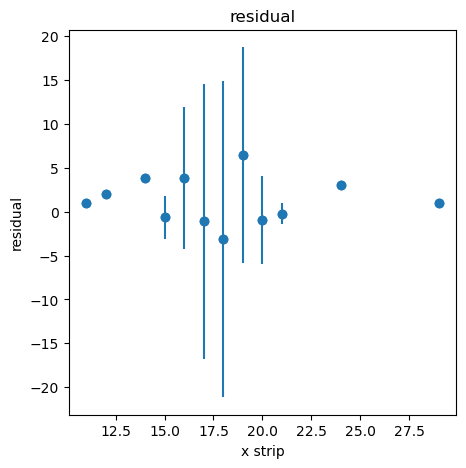

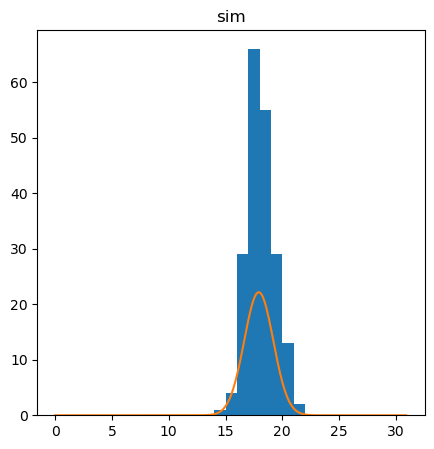

In [34]:
data = pd.read_csv('run231_105_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_105_output.txt', cal)
plt.figure(figsize = (5,5))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 6500) & (df['xE']<7000)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (5,5))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)


newBins_change = newBins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]

bins_=np.arange(0,31,.1)
_bins=np.arange(0,31,1)



def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,15,1.4)
m.limits=((15,None), (None,None),(0,None))

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (5,5))
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.plot(bins_,yy,linewidth = 3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='right')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (5,5))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")

plt.figure(figsize= (5,5))


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=reserror, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz
plt.figure(figsize= (5,5))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=error, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
#print(area1)
area_1=area1/total


print (sum(counts))

plt.figure(figsize = (5,5))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,31,range = (0,31), density=False)



_bins = np.arange(0,31,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,31,.1)
plt.plot(bins_,yy)
plt.title("sim")







### f106, 230/2, 212+water

File: run231_106_output.txt
3 2020-03-29 02:09:53
[' mpod to 230/2+', ' take more stats looking for Ac + water', ' start at 4:28am']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.75 (chi2/ndof = 1.0)    │             Nfcn = 2766              │
│ EDM = 0.000139 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_17765/313416635.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_17765/313416635.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

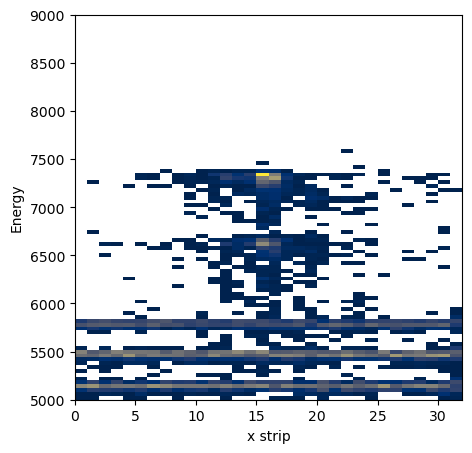

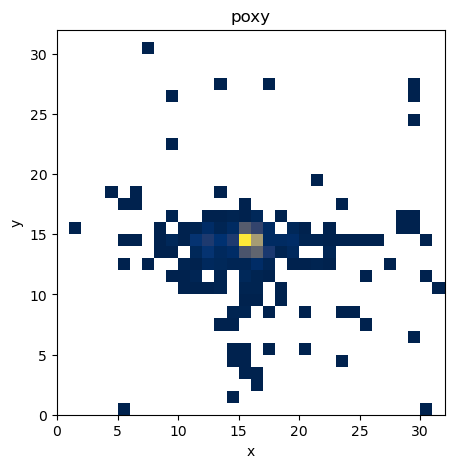

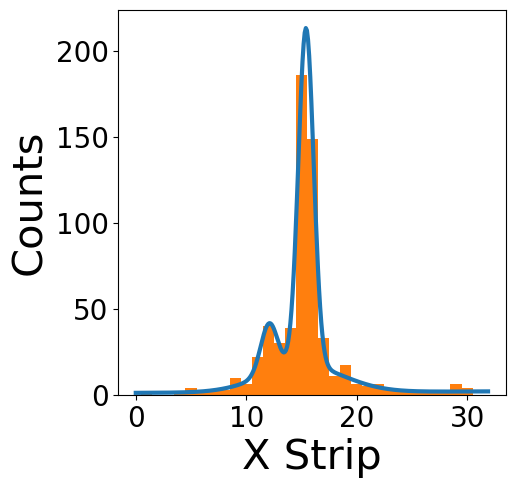

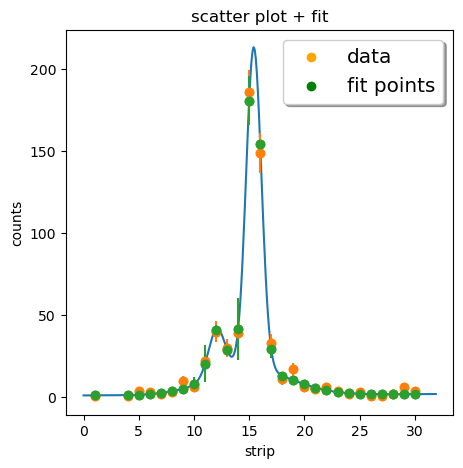

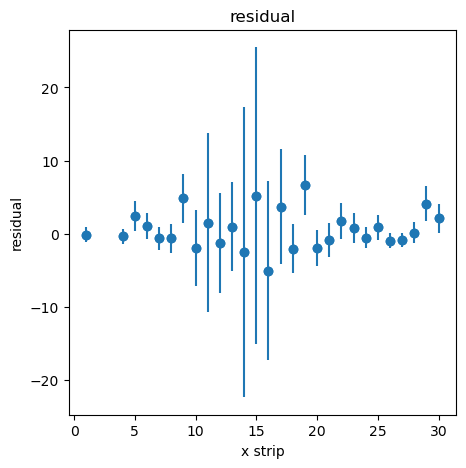

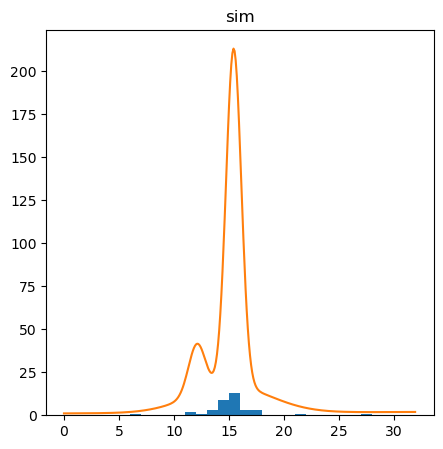

In [21]:
data = pd.read_csv('run231_106_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_106_output.txt', cal)
plt.figure(figsize = (5,5))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')


gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7100) & (df['xE']<7600)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (5,5))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("poxy")
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,12,1.4,530,16,.86,310,21,1,30,24,1.2)

m.limits = [(0,60),(0,13),(0,None),(10,None), (15,20), (0,None), (None,None ), (0,None), (0, None),(0,None),(None,None),(0, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (5,5))
#plt.title("histogram+fit")


plt.plot(bins_,yy, linewidth =3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.tick_params(axis='both', labelsize=20)


plt.figure(figsize= (5,5))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (5,5))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (5,5))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 228
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")





### 230/2, 15.45, so 212Ac + $H_{2}$0, based on Atf082, should be 3.46 strips per mass, or Ac211 H2O+H, or Ac213 +OH
### 12.04, 229/2, 15.45-3.46 = 11.99, Ac212+OH, or Ac211+$H_{2}$O
### 19.013, 231/2, 15.45+3.46= 18.91, Ac212+ H2O+H, or Ac213+H2O

### f107, Ac + 2 waters

File: run231_107_output.txt
3 2020-03-29 02:47:22
[' mpod = 248/2+', ' this would be Ac + 2-waters, if we see 212Ac', ' count on DS starting at 5:06am']
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 27.47 (chi2/ndof = 2.1)    │              Nfcn = 876              │
│ EDM = 6.38e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└──────────

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_17765/1738409158.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_17765/1738409158.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


ValueError: 'yerr' must not contain negative values

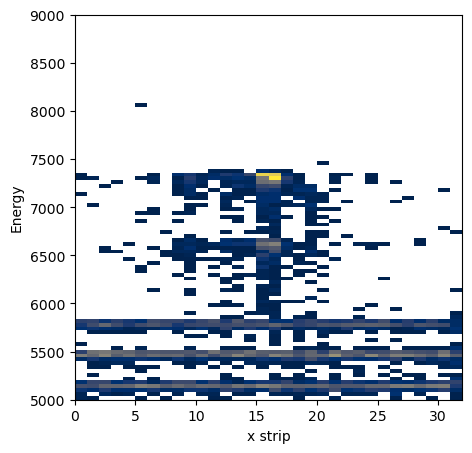

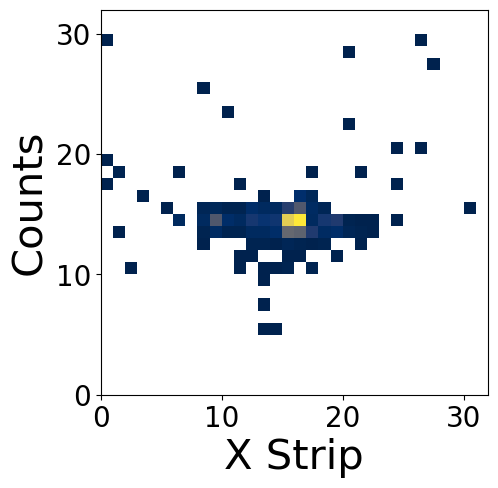

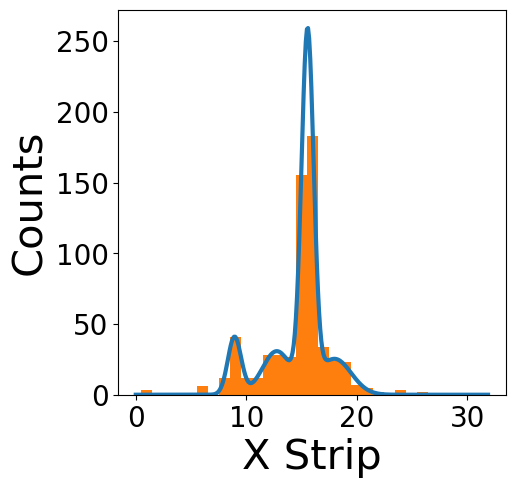

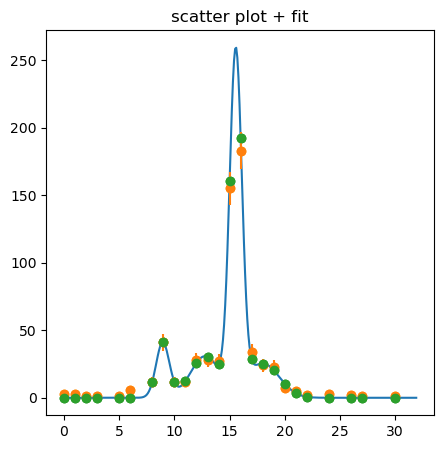

In [20]:
data = pd.read_csv('run231_107_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_107_output.txt', cal)
plt.figure(figsize = (5,5))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')


gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7000) & (df['xE']<7500)]
xbins = range(0,32)
newBins = np.delete(bins,0)




plt.figure(figsize = (5,5))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)
newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3,amp4,cen4,sigma4):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))+amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))+amp4*(np.exp((-1.0/2.0)*(((x-cen4)/sigma4)**2)))


ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,40,10,1.4,530,13,.86,310,16.4,1,30,18,1.2)

m.limits = [(0,None),(7,10),(0,None),(0,50), (10,13), (0,None), (250,325 ), (13,16), (None, None),(0,None),(15,18),(0, None)]
print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]
amp_2=m.values[3]
cen_2=m.values[4]
exp_2=m.values[5]
amp_3=m.values[6]
cen_3=m.values[7]
exp_3=m.values[8]
amp_4=m.values[9]
cen_4=m.values[10]
exp_4=m.values[11]


yy= fourpeaks(bins_,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1, amp_2,cen_2,exp_2,amp_3,cen_3,exp_3,amp_4,cen_4,exp_4)
#print(yy)
plt.figure(figsize = (5,5))
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)


plt.plot(bins_,yy,linewidth = 3)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) +  (m.errors[3]+amp_2)*(1/((m.errors[5]+exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2+m.errors[4])/(m.errors[5]+exp_2))**2)))+ (m.errors[6]+amp_3)*(1/((m.errors[8]+exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3+m.errors[7])/(m.errors[8]+exp_3))**2)))+(m.errors[9]+amp_4)*(1/((m.errors[11]+exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4+m.errors[10])/(m.errors[11]+exp_4))**2)))-((amp_1)*(1/((exp_1)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1)/(exp_1))**2))) +  (amp_2)*(1/((exp_2)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_2)/(exp_2))**2)))+ (amp_3)*(1/((exp_3)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_3)/(exp_3))**2)))+(amp_4)*(1/((exp_4)))*(np.exp((-1.0/2.0)*(((newBins_change-cen_4)/(exp_4))**2))))
print (error)
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)

plt.figure(figsize= (5,5))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')



plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989
area2=amp_2*exp_2/.3989
area3=amp_3*exp_3/.3989
area4=amp_4*exp_4/.3989
total= area1+area2+area3+area4
#print (total)
#print(area1)
area_1=area1/total
area_2=area2/total
area_3=area3/total
area_4=area4/total

print (sum(counts))

plt.figure(figsize = (5,5))


mu = [cen_1,cen_2,cen_3,cen_4]
sigma = [exp_1,exp_2,exp_3,exp_4]
area = [area_1,area_2,area_3,area_4]
n = 650
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




### 15.557, centered, 248/2, should be 3.209 strips per mass Ac212 + 2 H20, Ac211 + 2H20+H, or Ac 213+ H20+OH
### 12.76, 247/2, 15.557-3.209= 12.348, Ac 211+ 2H2O, Ac212+ H20+OH, Ac213+ 2(OH)
### 8.94, 246/2, 15.557-3.209-3.209= 9.139, Ac211+H20+OH, Ac212+ (OH)2
### 18, 248/2, 15.557+3.209= 18.766, Ac213+ 2H20, Ac212+2H20+H

In [ ]:
check what that 6.9 could be
check all exit channels, pxn double check 
check nobelium chain 
212 and 213 same half life and <20 kev
but can rule out 211
look at energy and counts

why is the 211 shoiwing up?
x positoin, energy, mass 


rga for nobelium waters, for the 2 3-water spectra, look at water and nitrogen levels
and for each of them, look the ratios
find counts/ruth

also do file 76, another 290/2
do counts/ruth for all of them 


                 datafile det            t   evt_num   x   y  ychan  xchan  \
0       r231f066_4876.lmd  C2     0.034202  36588450  11  14    906    961   
1       r231f066_4876.lmd  C2     0.056499  36588452  13  16    934    944   
2       r231f066_4876.lmd  C2     0.063606  36588453  17  15    959    633   
3       r231f066_4876.lmd  C2     0.068150  36588454  12  18    905    950   
4       r231f066_4876.lmd  C2     0.084404  36588456   5  17    614    888   
...                   ...  ..          ...       ...  ..  ..    ...    ...   
226010  r231f066_4876.lmd  C2  3634.031193  36931659  13  18    911    937   
226011  r231f066_4876.lmd  C2  3634.037450  36931660  14   4    909    955   
226012  r231f066_4876.lmd  C1  3634.038287  36931661  15  17    819    530   
226013  r231f066_4876.lmd  C2  3634.067477  36931662   3  31    944    913   
226014  r231f066_4876.lmd  C2  3634.073990  36931663   0  10    878   1077   

          0  
0       NaN  
1       NaN  
2       NaN  
3      

/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_11770/4102428710.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
/var/folders/z5/wjs7x0tx3t777dypj187gf_h0000gn/T/ipykernel_11770/4102428710.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')


Text(0.5, 1.0, 'sim')

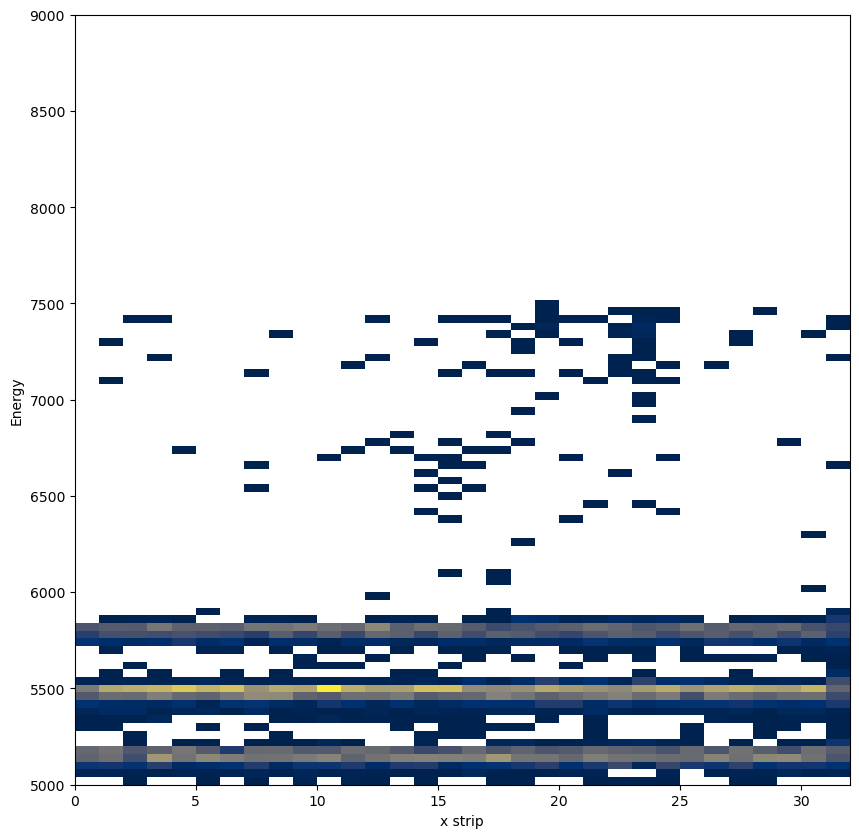

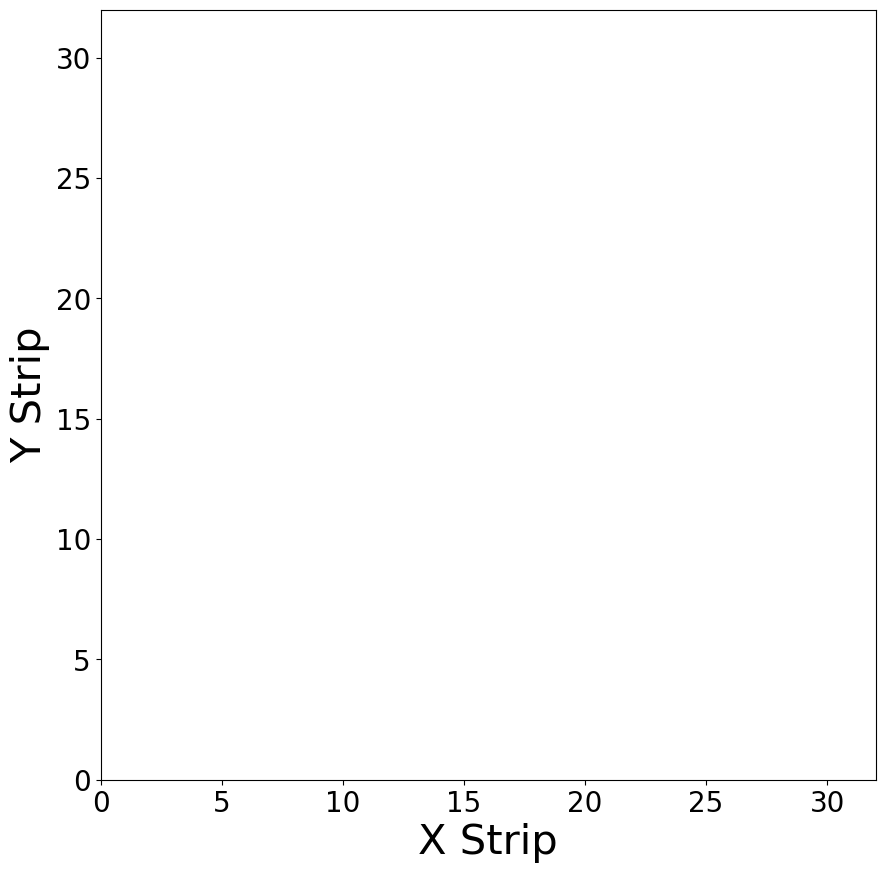

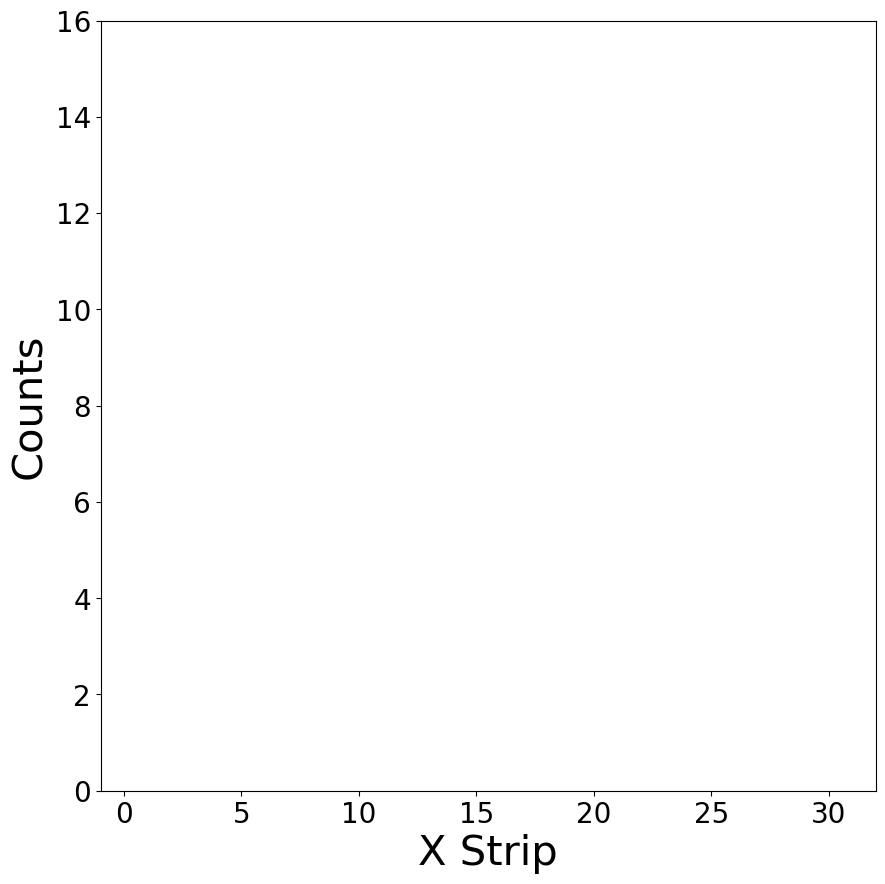

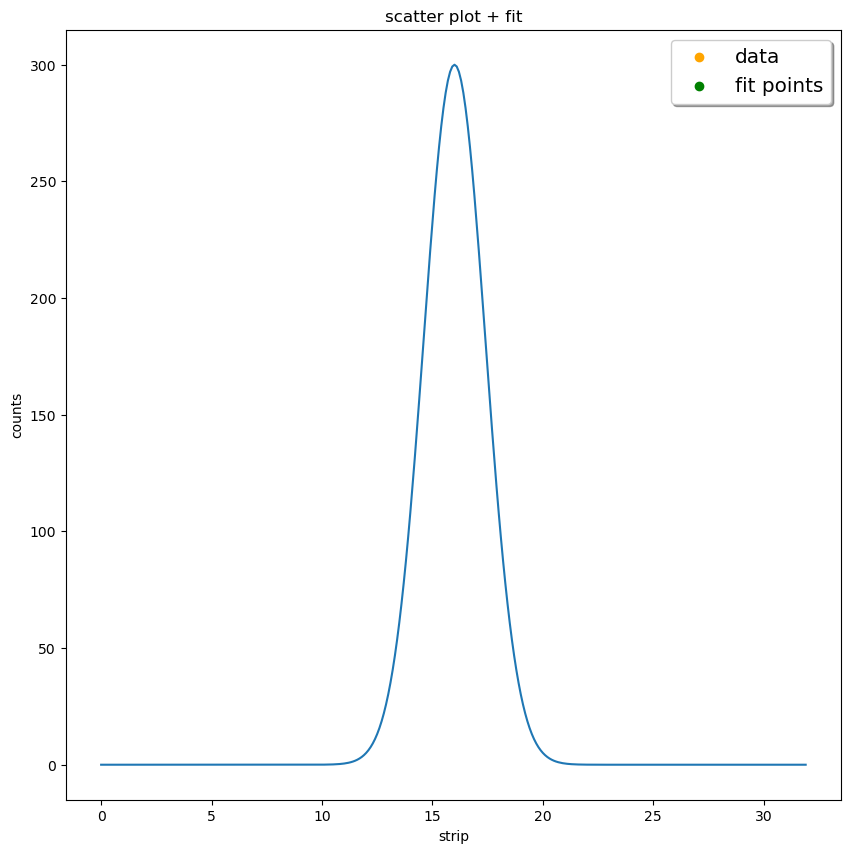

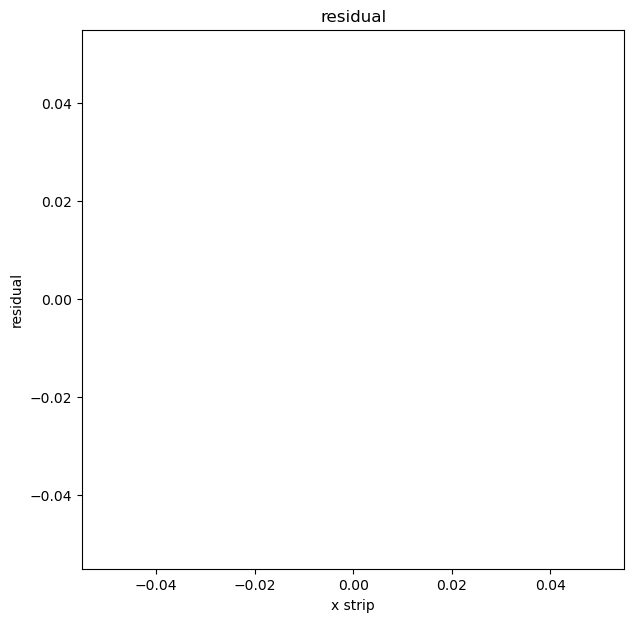

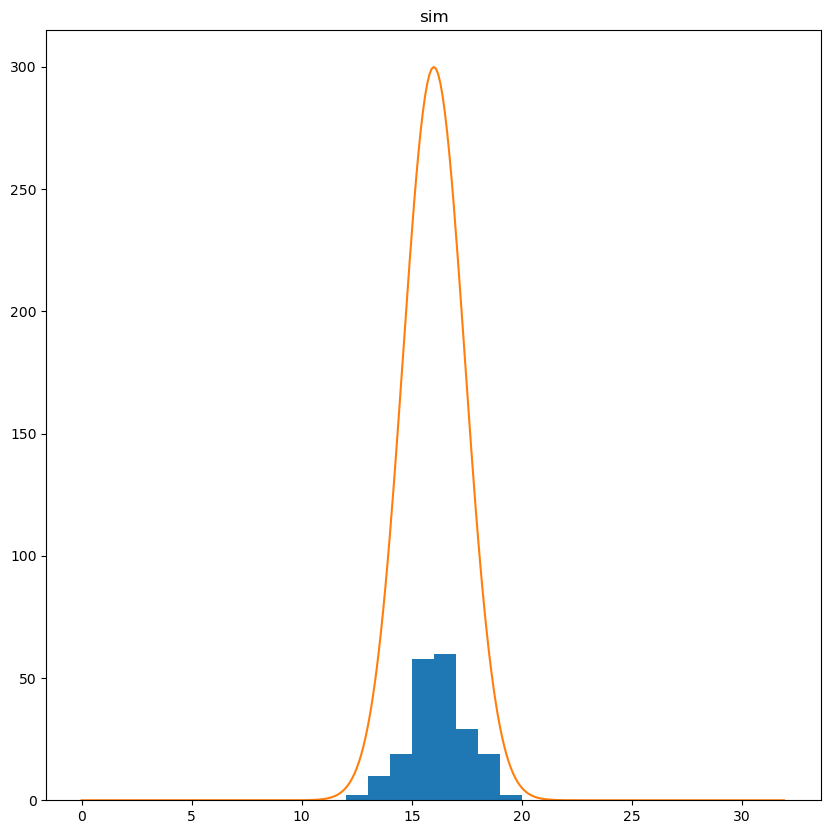

In [16]:
data = pd.read_csv('run231_066_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
print (data)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start


df, t1 = readDS('run231_066_output.txt', cal)
plt.figure(figsize = (10,10))
plt.hist2d(df['x'], df['xE'], range = ((0,32),(5000,9000)), bins = (32,100), cmap = 'cividis', cmin = 1)
plt.xlabel('x strip')
plt.ylabel('Energy')
print (df.tail())

gates = df[(df['y'] >=0) & (df['y'] < 31) & (df['xE'] > 7600) & (df['xE']<8500)]
xbins = range(0,32)
newBins = np.delete(xbins,0)




plt.figure(figsize = (10,10))
plt.hist2d(gates['x'], gates['y'], range = ((0,32),(0,32)), bins = (32,32), cmap = 'cividis', cmin = 1)
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Y Strip',fontsize = 30)
counts,bins = np.histogram(gates['x'],bins = xbins)

bins_=np.arange(0,32,.1)
_bins=np.arange(0,32,1)

newBins_change = _bins[np.where(counts != 0)]
newcounts= counts[np.where(counts!=0)]





def fourpeaks(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

ye = np.sqrt(newcounts)

c = cost.LeastSquares(newBins_change,newcounts,ye,fourpeaks)
m= minuit.Minuit(c,300,16,1.4)

print (m.migrad())
amp_1=m.values[0]
cen_1=m.values[1]
exp_1=m.values[2]



yy= fourpeaks(bins_,amp_1,cen_1,exp_1)
yy_=fourpeaks(newBins_change,amp_1,cen_1,exp_1)
#print(yy)
plt.figure(figsize = (10,10))


#plt.plot(bins_,yy)


c_= np.sqrt(newcounts)
error = (amp_1+m.errors[0])*(1/((exp_1+m.errors[2])))*(np.exp((-1.0/2.0)*(((newBins_change-cen_1+m.errors[1])/(exp_1+m.errors[2]))**2))) 
reserror= np.sqrt(c_**2+error**2)

plt.hist(gates['x'], bins = newBins,align='left')
plt.tick_params(axis='both', labelsize=20)
plt.xlabel('X Strip', fontsize= 30)
plt.ylabel('Counts',fontsize = 30)
plt.ylim(0,16)

plt.figure(figsize= (10,10))
plt.plot(bins_,yy)
plt.title("scatter plot + fit")
plt.scatter(newBins_change,newcounts,label='data',color='orange')
plt.errorbar(newBins_change,newcounts,yerr=c_, fmt= "o")


plt.scatter(newBins_change,yy_,label="fit points", color='green')
plt.errorbar(newBins_change,yy_,yerr=error, fmt= 'o')





plt.ylabel("counts")
plt.xlabel("strip")
legend = plt.legend(loc='upper right', shadow=True, fontsize='x-large')
residual_2lorentz = (newcounts - yy_)
#plt.errorbar(_bins,yy_,yerr=residual_2lorentz, fmt= "o")
#print ( residual_2lorentz)
plt.figure(figsize= (7,7))
plt.title("residual")
plt.scatter(newBins_change,residual_2lorentz)
plt.errorbar(newBins_change,residual_2lorentz, yerr=reserror, fmt= 'o')

plt.xlabel("x strip")
plt.ylabel("residual")


plt.xlabel("x strip")
plt.ylabel("residual")

area1=amp_1*exp_1/.3989

total= area1
#print (total)
print(area1)
area_1=area1/total

print (sum(counts))

plt.figure(figsize = (10,10))


mu = [cen_1]
sigma = [exp_1]
area = [area_1]
n = 199
x=[]
for i in range (n):
    hi = (np.argmax(np.random.multinomial(1,area)))
    hii= (np.random.normal(mu[hi], sigma[hi]))
    x.append(hii)


countss_,bins,ignored = plt.hist(x,32,range = (0,32), density=False)



_bins = np.arange(0,32,1)
    
#def twopeaks(x, alor1, xlor1, alor2, xlor2, wlor1,wlor2):
  #  return ((2/np.pi)*((alor1*wlor1)/(4*((x-xlor1)**2)+wlor1**2))+(2/np.pi)*((alor2*wlor2)/(4*((x-xlor2)**2)+wlor2**2)))
    

bins_=np.arange(0,32,.1)
plt.plot(bins_,yy)
plt.title("sim")




In [6]:
### counts per ruth

In [18]:
data = pd.read_csv('run231_066_output.txt', sep = '\t', skiprows = 24, names = ['datafile', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan','0'])
cal = pd.read_csv('run231_calibration_run037.txt', sep = '\t', index_col = 0)
def readDS(filename, calibration_file):
    print('File:', filename)
    comments = []
    with open(filename) as ff:
        lines = ff.readlines()
        start = pd.to_datetime(lines[14][6:-1])
        commentlength = int(lines[17][-3:-1])
        print(commentlength, start)
        for i in range(0,commentlength):
            comments.append(lines[19+i][9:-1])
        print(comments)
    
    """ read datafile store as dataframe name temp """
    temp = pd.read_csv(filename, sep = '\t', skiprows = 19+commentlength, header = None,usecols = np.arange(0,8))
    temp.columns = ['name', 'det', 't', 'evt_num', 'x', 'y', 'ychan', 'xchan']
    temp = temp.query('det == "DS"')

    """ look for events where more than one strip was hit"""
    temp['nX'] = temp.groupby(['t', 'xchan'])['t'].transform('count')
    temp['nY'] = temp.groupby(['t', 'ychan'])['t'].transform('count')
    #print ('--------before--------')
    #print (temp)

    #apply the calibration file
    #pull the three columns of the cali file, and merge with temp
    """ convert channel number to energy. Using a linear calibration of E = (m*(chan - b) + 89.2)/1.005  """
    """ The factors of 89.2 and 1.005 are just offsets to account for detector dead layer energy loss """
    temp2 = pd.merge(temp, calibration_file[['x', 'mx', 'xint']], on = 'x', how = 'left')
    temp2 = pd.merge(temp2, calibration_file[['y', 'my', 'yint']], on = 'y', how = 'left')
    temp2['xstripE'] = temp2['mx'] * temp2['xchan'] + temp2['xint']
    temp2['ystripE'] = temp2['my'] * temp2['ychan'] + temp2['yint']
    #print ('--------after calibration is applied')
    #print (temp2)



    """ make a flag to identify differences in strips between higher-multiplicity events """
    temp2['xdiff'] = temp2.groupby(['t'])['x'].transform('max') - temp2.groupby(['t'])['x'].transform('min')
    temp2['ydiff'] = temp2.groupby(['t'])['y'].transform('max') - temp2.groupby(['t'])['y'].transform('min')
    
    """ get energy sums for events """
    temp2['xE']= temp2.groupby(['t','nX'])['xstripE'].transform('sum')/(temp2['nX'])
    temp2['yE'] = temp2.groupby(['t', 'nY'])['ystripE'].transform('sum')/temp2['nY']

    """ query out events with multiplicity > 2 and mult = 2 events which aren't in neighbouring strips"""
    temp3 = temp2.query('xdiff < 2 and ydiff < 2')
    
    """ another flag to keep the lowest energy x,y hit of mult = 2 events """
    temp3 = temp3.sort_values(by = ['t','xchan','ychan'], ascending = [True,False,False])
    temp3['xdup'] = temp3.duplicated(['t','xchan'], keep = 'last')#keep = 'first')
    temp3['ydup'] = temp3.duplicated(['t', 'ychan'], keep = 'last') #keep = 'first')
    temp4 = temp3.query('xdup == False and ydup == False').drop(['ychan','xchan', 'xdiff', 'ydiff', 'xdup','ydup'], axis = 1)
    
    #drop these calibration columns if not greater than 0
    """ choose which columns appear in the sorted dataframe """
    result = temp4.drop(['xstripE', 'ystripE', 'mx', 'xint', 'my', 'yint'], axis = 1).query('xE > 0 and yE > 0')
    
    filedur = max(result['t']) - min(result['t'])
    #print('This file calibrated using Edep = 1.005*Einc - 89.2 keV')
    #print('duration = %is = %.2lf min = %.2lf hr \n -----------------------------------------------------------------'%(filedur, filedur/60, filedur/3600))
    
    """ return the final dataframe and the start time from the header"""

    return result, start

